## 📂 Raw CSV (local)

At this stage, our dataset only exists as a **CSV file** on disk:  

- File path: `../data/RMBR4-2_export_test.csv`  
- Schema: whatever columns are defined in the CSV (no enforced types in DB yet)  
- No table yet created in the database.  

---

### ⚙️ Cell 0.0a — Upload CSV (exact schema) to NEW table  

This cell:  
1. Loads environment variables from `.env` (grabs `DATABASE_URL` and table name).  
2. Reads the CSV exactly as-is (no transformations, except adding an `id` column if missing).  
3. Creates/replaces the target table in Postgres with the **exact CSV schema**.  
4. Immediately verifies by checking row count and column list from the DB.  

In [444]:
# Cell 0.0a — Upload CSV (exact schema) to NEW table

import os
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import itertools

load_dotenv(override=True)  # ensure fresh .env is read
PG_URL = os.getenv("DATABASE_URL")
TABLE_NAME = os.getenv("TRAINING_TABLE", "readings_fact_csv")
CSV_PATH = "../data/RMBR4-2_export_test.csv"

assert PG_URL, "DATABASE_URL missing in .env"
engine = create_engine(PG_URL, future=True)

# Read CSV exactly as-is
df = pd.read_csv(CSV_PATH)

# Optional: add an id if you want one (safe to keep or remove)
if "id" not in df.columns:
    df = df.reset_index().rename(columns={"index": "id"})

# Create/replace the NEW table with CSV schema
df.to_sql(TABLE_NAME, engine, if_exists="replace", index=False)
print(f"✅ Loaded {len(df):,} rows into '{TABLE_NAME}' (schema = exact CSV)")

# Verify immediately
with engine.connect() as conn:
    n = conn.execute(text(f'SELECT COUNT(*) FROM "{TABLE_NAME}"')).scalar_one()
    cols = conn.execute(text("""
        SELECT column_name
        FROM information_schema.columns
        WHERE table_name = :t
        ORDER BY ordinal_position
    """), {"t": TABLE_NAME}).scalars().all()
print(f"🔎 DB rowcount in '{TABLE_NAME}': {n:,}")
print("🔧 Columns in DB:", cols[:10], "...")  # show first few


✅ Loaded 39,672 rows into 'readings_fact_csv' (schema = exact CSV)
🔎 DB rowcount in 'readings_fact_csv': 39,672
🔧 Columns in DB: ['id', 'Trait', 'Axis #1', 'Axis #2', 'Axis #3', 'Axis #4', 'Axis #5', 'Axis #6', 'Axis #7', 'Axis #8'] ...


##### ✅ Table in Database

Now we have:  

- **Table name:** `readings_fact_csv` (or custom from `TRAINING_TABLE`).  
- **Row count:** matches the number of rows in the CSV.  
- **Columns:** identical to the CSV header (plus optional `id`).  
- Data is queryable directly in the database for downstream analysis. 

### 📂 Data in Database (Neon, Postgres)

- The CSV was already uploaded in the previous step (`Cell 0.0a`) into the **Neon Postgres DB**.  
- Table created: `readings_fact_csv` (or value from `TRAINING_TABLE`).  
- Contains **39,672 rows × 17 columns** (as confirmed in DB).  
- Data is present in the DB but not yet loaded into the notebook for analysis.  

---

### ⚙️ Cell 0.0b — Pull TRAINING Data from Neon  

This cell:  
1. Connects to the Neon Postgres database using `DATABASE_URL`.  
2. Executes a `SELECT * FROM readings_fact_csv`.  
3. Loads the entire table into a pandas DataFrame called `train`.  
4. Prints a confirmation message with row count.  
5. Displays the first few rows for a quick inspection.  

In [445]:
# Cell 0.0b — Pull TRAINING data from Neon (Postgres)
import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

# Load environment variables (make sure DATABASE_URL is in your .env)
load_dotenv(override=True)
PG_URL = os.getenv("DATABASE_URL")
TABLE_NAME = os.getenv("TRAINING_TABLE", "readings_fact_csv")

assert PG_URL, "❌ DATABASE_URL not set in .env"

engine = create_engine(PG_URL, future=True)

# Pull TRAINING data directly from DB
query = f'SELECT * FROM "{TABLE_NAME}";'
train = pd.read_sql(query, engine)
print(f"✅ Pulled {len(train)} rows from Neon table '{TABLE_NAME}'")

# Quick check
display(train.head())


✅ Pulled 39672 rows from Neon table 'readings_fact_csv'


id    Trait  Axis #1  Axis #2  Axis #3  Axis #4  Axis #5  Axis #6  Axis #7  \
0   0  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1   1  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2   2  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3   3  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4   4  current      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   Axis #8 Axis #9 Axis #10 Axis #11 Axis #12 Axis #13 Axis #14  \
0      0.0    None     None     None     None     None     None   
1      0.0    None     None     None     None     None     None   
2      0.0    None     None     None     None     None     None   
3      0.0    None     None     None     None     None     None   
4      0.0    None     None     None     None     None     None   

                       Time  
0  2022-10-17T12:18:23.660Z  
1  2022-10-17T12:18:25.472Z  
2  2022-10-17T12:18:27.348Z  
3  2022-10-17T12:18:29.222Z  
4  2022-10-17T12:18:31.117Z

### ✅ Data in Notebook (pandas DataFrame)

- **Rows pulled:** 39,672  
- **Columns pulled:** 17 (e.g., `id`, `Trait`, `Axis #1`, `Axis #2`, …)  
- The dataset is now available locally in the notebook (`train` DataFrame) for cleaning, exploration, and modeling.  

### 📂 TRAIN/TEST Time Columns

- Dataframes `train` and `test` may or may not have:
  - A proper **Time** column (datetime).
  - A numeric **t_sec** column (seconds since start).
- If present, values might not be strictly monotonic.
- If missing, the model cannot align time series across TRAIN/TEST reliably.

---

### ⚙️ Cell 0.0c — Ensure Time + t_sec

This cell:  
1. Defines `_ensure_t_sec()` helper to guarantee:  
   - `Time` column exists → parsed as datetime.  
   - `t_sec` column exists → seconds since first timestamp.  
   - Both are monotonic and sorted.  
2. If `Time` is missing in `test`, it **synthesizes a timeline** using the cadence from `train` (median Δt) or a default 2-second interval.  
3. Applies function to both **TRAIN** and **TEST** datasets.  

##### ✅ Standardized Time Columns

- Both `train` and `test` now contain:  
  - `Time` → valid datetime64, sorted.  
  - `t_sec` → numeric, non-decreasing, aligned to timeline.  
- Ensures TRAIN/TEST share consistent time structure for downstream analysis. 

In [446]:
# Cell 0.0c — Ensure Time + t_sec exist and are monotonic on TRAIN/TEST

import pandas as pd
import numpy as np

def _ensure_t_sec(df: pd.DataFrame, *, ref: pd.DataFrame | None = None, default_dt: float = 2.0) -> pd.DataFrame:
    """
    Guarantees:
      - 'Time' exists (datetime64[ns, UTC] if tz-aware, else naive)
      - 't_sec' exists (seconds since first 'Time', float, non-decreasing)
      - rows sorted by 'Time'
    If 'Time' is missing, it will synthesize a timeline using:
      * ref cadence (median Δt from ref['t_sec']) if provided, else default_dt seconds
    """
    out = df.copy()

    # 1) Time
    if "Time" not in out.columns:
        # Synthesize from index with cadence
        if ref is not None and "t_sec" in ref.columns and len(ref) > 1:
            dt = float(np.median(np.diff(ref["t_sec"].to_numpy())))
        else:
            dt = float(default_dt)
        start = pd.Timestamp("2024-01-01 00:00:00")
        out["Time"] = pd.date_range(start, periods=len(out), freq=pd.to_timedelta(dt, unit="s"))
    else:
        out["Time"] = pd.to_datetime(out["Time"], errors="coerce")
        # sort by Time to ensure monotonic
        out = out.sort_values("Time").reset_index(drop=True)

    # 2) t_sec
    if "t_sec" not in out.columns:
        t0 = out["Time"].iloc[0]
        out["t_sec"] = (out["Time"] - t0).dt.total_seconds()
    else:
        # make sure it's numeric & monotonic after sorting by Time
        out["t_sec"] = pd.to_numeric(out["t_sec"], errors="coerce")
        # if not monotonic, recompute from Time
        if not np.all(np.diff(out["t_sec"].to_numpy()) >= 0):
            t0 = out["Time"].iloc[0]
            out["t_sec"] = (out["Time"] - t0).dt.total_seconds()

    return out

# Apply to TRAIN/TEST
train = _ensure_t_sec(train)
# If TEST has no Time/t_sec, use TRAIN cadence to synthesize
test  = _ensure_t_sec(test, ref=train)
print("✅ Ensured Time + t_sec on TRAIN/TEST and sorted by Time.")


✅ Ensured Time + t_sec on TRAIN/TEST and sorted by Time.


##### ✅ After — Standardized Timelines

- Both `train` and `test` now include:  
  - **Time** column (datetime, monotonic).  
  - **t_sec** column (float, aligned to Time).  
- Rows are sorted by `Time`.  

In [447]:
# Cell 1.0 — Axes policy: train on 8, evaluate on intersection (single source of truth)

import numpy as np
import pandas as pd

# Preconditions from Cell 2.0
assert 'train' in globals() and 'test' in globals(), "Run Cell 2.0 first."
assert 'axes_train_8' in globals() and len(axes_train_8) > 0, "Missing axes_train_8 (from Cell 2.0)."
assert 'axes_eval' in globals(), "Missing axes_eval (from Cell 2.0)."

# Canonical lists
AXES_TRAIN = list(axes_train_8)   # fit on these (up to 8)
AXES_TEST  = list(axes_eval)      # evaluate on intersection
axes = AXES_TEST                  # backwards-compat: TEST cells that iterate `axes` will use intersection

# Helpers you can use in loops
def for_train_axes():
    """Axes to fit on TRAIN (up to 8)."""
    return list(AXES_TRAIN)

def for_test_axes():
    """Axes to use on TEST (intersection)."""
    return list(AXES_TEST)

# Default single-axis for quick plots
AX_FOR_PLOT = AXES_TEST[0] if AXES_TEST else (AXES_TRAIN[0] if AXES_TRAIN else None)

# Quick guards + cadence echo
def _assert_test_ready():
    for name, df in [("TRAIN", train), ("TEST", test)]:
        for col in ("Time", "t_sec"):
            assert col in df.columns, f"{name} missing required column: {col}"
        t = df["t_sec"].to_numpy()
        assert np.all(np.diff(t) >= 0), f"{name} t_sec is not non-decreasing."
    assert len(AXES_TEST) > 0, "No common Axis columns for TEST. Check metadata CSV vs TRAIN names."

_assert_test_ready()

dt_train = float(np.median(np.diff(train["t_sec"].to_numpy()))) if len(train) > 1 else 0.0
dt_test  = float(np.median(np.diff(test["t_sec"].to_numpy())))  if len(test)  > 1 else 0.0

print(f"Axes (TRAIN fit): {len(AXES_TRAIN)} -> {AXES_TRAIN}")
print(f"Axes (TEST eval): {len(AXES_TEST)} -> {AXES_TEST}")
if len(AXES_TRAIN) < 8:
    print("⚠️ TRAIN has fewer than 8 axes — fitting on available ones.")
if len(AXES_TEST) < len(AXES_TRAIN):
    print("ℹ️ TEST is missing some axes; evaluation/plots use intersection only.")

print(f"⏱️ cadence — TRAIN: {dt_train:.3f}s | TEST: {dt_test:.3f}s")
print("✅ Axes policy set. Use AXES_TRAIN for fitting; AXES_TEST (or for_test_axes()) for TEST.")

Axes (TRAIN fit): 8 -> ['Axis #1', 'Axis #2', 'Axis #3', 'Axis #4', 'Axis #5', 'Axis #6', 'Axis #7', 'Axis #8']
Axes (TEST eval): 8 -> ['Axis #1', 'Axis #2', 'Axis #3', 'Axis #4', 'Axis #5', 'Axis #6', 'Axis #7', 'Axis #8']
⏱️ cadence — TRAIN: 1.891s | TEST: 1.891s
✅ Axes policy set. Use AXES_TRAIN for fitting; AXES_TEST (or for_test_axes()) for TEST.


In [448]:
# CELL 1.0a — Helper functions (residuals, events, overlays)
# ==============================
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def predict_axis(col_name: str, t_seconds: np.ndarray) -> np.ndarray:
    f = fits.get(col_name, None)
    if f is None:
        return np.full_like(t_seconds, np.nan, dtype=float)
    return f.a + f.b * t_seconds

def zscore_residuals(col_name: str, t_seconds: np.ndarray, y: np.ndarray) -> np.ndarray:
    f = fits.get(col_name, None)
    th = thr.get(col_name, None)
    if f is None or th is None:
        return np.full_like(y, np.nan, dtype=float)
    yhat = f.a + f.b * t_seconds
    return np.abs((y - yhat - th["mu"]) / (th["sd"] if th["sd"]>0 else 1.0))

def find_spans(flags: np.ndarray, min_len: int):
    """Return list of (start_idx, end_idx) inclusive spans where flags==True for at least min_len consecutive points."""
    spans = []
    run = 0
    start = None
    for i, f in enumerate(flags):
        if f and run == 0:
            start = i; run = 1
        elif f:
            run += 1
        elif (not f) and run > 0:
            if run >= min_len:
                spans.append((start, i-1))
            run = 0; start = None
    if run >= min_len and start is not None:
        spans.append((start, len(flags)-1))
    return spans

def overlay_spans(ax, x_vals, spans, color, alpha=0.25, label=None):
    for (s, e) in spans:
        ax.axvspan(x_vals[s], x_vals[e], color=color, alpha=alpha, label=label)
        label = None  # avoid duplicate legend handles

In [449]:
# Cell 1.1 - Are axes basically OK?
display(train[axes].describe().T[['mean','std','min','max']])

# Make sure we have non-zero readings somewhere
display((train[axes] != 0).sum().to_frame('nonzero_count'))

# Any NaNs that slipped in?
display(train[axes].isna().sum().to_frame('nan_count'))

mean       std  min       max
Axis #1  0.725743  2.162120  0.0  23.60930
Axis #2  3.613374  6.879962  0.0  51.71323
Axis #3  2.710336  5.111901  0.0  41.85556
Axis #4  0.620222  1.574897  0.0  15.66630
Axis #5  0.954521  2.100186  0.0  20.75076
Axis #6  0.599427  1.815498  0.0  20.93142
Axis #7  0.870145  2.166811  0.0   8.10848
Axis #8  0.102214  0.423075  0.0   5.90564

nonzero_count
Axis #1          13758
Axis #2          13850
Axis #3          13828
Axis #4          13668
Axis #5          13808
Axis #6          13599
Axis #7          13662
Axis #8          13714

nan_count
Axis #1          0
Axis #2          0
Axis #3          0
Axis #4          0
Axis #5          0
Axis #6          0
Axis #7          0
Axis #8          0

In [450]:
# Cell 2.0a — TRAIN preflight → fit (Time→Axis #1–#8) → residual diagnostics

import numpy as np, pandas as pd
from pathlib import Path
from sklearn.linear_model import LinearRegression
from IPython.display import display

# ---------- Guards / context ----------
assert 'train' in globals(), "❌ Missing TRAIN DataFrame (run Cell 2.0)."
assert 'axes_train_8' in globals() and len(axes_train_8) > 0, "❌ TRAIN axes not set (run Cell 2.0)."
root = globals().get("root", Path.cwd())
SAVE_REPORTS = bool(globals().get("SAVE_REPORTS", False))

# ---------- TRAIN-specific preflight ----------
req_train = ["Time","t_sec"] + list(axes_train_8)
missing = [c for c in req_train if c not in train.columns]
assert not missing, f"TRAIN missing columns: {missing}"
assert len(train) > 1, "TRAIN has too few rows."

# numeric + non-constant checks
for ax in axes_train_8:
    train[ax] = pd.to_numeric(train[ax], errors="coerce")
    assert train[ax].notna().any(), f"TRAIN has empty column: {ax}"
    assert train[ax].nunique(dropna=True) > 1, f"TRAIN column constant: {ax}"

# monotonic timebase + cadence
t = train["t_sec"].to_numpy()
assert np.all(np.diff(t) >= 0), "TRAIN t_sec is not non-decreasing."
dt_train = float(pd.Series(train["t_sec"]).diff().median()) if len(train) > 1 else 0.0
print(f"✅ TRAIN preflight passed | cadence (median Δt) = {dt_train:.4f}s")

# ---------- Fit univariate regressions (Time → Axis #1–#8 on TRAIN) ----------
models = {}
rows = []
Xtr = train[["t_sec"]].to_numpy()

for ax in axes_train_8:
    y = train[ax].to_numpy(dtype=float)
    m = LinearRegression().fit(Xtr, y)
    models[ax] = m
    rows.append({
        "axis": ax,
        "slope": float(m.coef_[0]),
        "intercept": float(m.intercept_),
        "r2_train": float(m.score(Xtr, y)),
    })

coefs = pd.DataFrame(rows).set_index("axis").round(6)
print("✅ Fitted models for TRAIN axes:", list(axes_train_8))
display(coefs)

if SAVE_REPORTS:
    outp = (root / "reports" / "regression_coefs.csv")
    outp.parent.mkdir(parents=True, exist_ok=True)
    coefs.reset_index().to_csv(outp, index=False)
    print("💾 Saved ->", outp)

# ---------- TRAIN residual diagnostics (supports threshold derivation later) ----------
res_rows = []
for ax in axes_train_8:
    yhat  = models[ax].predict(Xtr)
    resid = train[ax].to_numpy(dtype=float) - yhat
    pos   = resid[resid > 0]
    res_rows.append({
        "axis": ax,
        "resid_mu": float(np.mean(resid)),
        "resid_sd": float(np.std(resid, ddof=1)),
        "p95_pos": float(np.percentile(pos, 95)) if pos.size else 0.0,
        "p99_pos": float(np.percentile(pos, 99)) if pos.size else 0.0,
    })

train_resid_summ = pd.DataFrame(res_rows).set_index("axis").round(4)
print("📊 TRAIN residual summary (for threshold choice):")
display(train_resid_summ)

if SAVE_REPORTS:
    outp = (root / "reports" / "train_residual_summary.csv")
    outp.parent.mkdir(parents=True, exist_ok=True)
    train_resid_summ.reset_index().to_csv(outp, index=False)
    print("💾 Saved ->", outp)

# ---------- Expose for downstream cells ----------
globals().update({
    "models": models,
    "coefs": coefs,
    "train_resid_summ": train_resid_summ,
    "dt_train": dt_train,
})
print("✅ TRAIN artifacts ready: models, coefs, train_resid_summ, dt_train")

✅ TRAIN preflight passed | cadence (median Δt) = 1.8910s
✅ Fitted models for TRAIN axes: ['Axis #1', 'Axis #2', 'Axis #3', 'Axis #4', 'Axis #5', 'Axis #6', 'Axis #7', 'Axis #8']


slope  intercept  r2_train
axis                                  
Axis #1 -0.000000   0.730542  0.000002
Axis #2  0.000002   3.523886  0.000054
Axis #3 -0.000001   2.733898  0.000007
Axis #4  0.000000   0.604357  0.000033
Axis #5  0.000000   0.951103  0.000001
Axis #6  0.000000   0.580077  0.000037
Axis #7  0.000001   0.847563  0.000035
Axis #8  0.000000   0.098748  0.000022

📊 TRAIN residual summary (for threshold choice):


resid_mu  resid_sd  p95_pos  p99_pos
axis                                         
Axis #1      -0.0    2.1621  11.3438  20.0266
Axis #2       0.0    6.8798  24.5676  39.4509
Axis #3      -0.0    5.1119  19.6594  27.6974
Axis #4      -0.0    1.5749   7.2060  11.7136
Axis #5      -0.0    2.1002   8.5170  14.0363
Axis #6      -0.0    1.8155   9.4692  14.3679
Axis #7       0.0    2.1668   7.2327   7.2473
Axis #8       0.0    0.4231   3.1362   4.0778

✅ TRAIN artifacts ready: models, coefs, train_resid_summ, dt_train


In [451]:
# Cell 2.0b — Train vs metadata_regen_clean.csv (diagnostics only; no globals overwritten)

import numpy as np, pandas as pd, os

CAND_REGEN = "../data/metadata_regen_clean.csv"
assert os.path.exists(CAND_REGEN), f"Missing file: {CAND_REGEN}"

def _is_axis(c): return str(c).strip().lower().startswith("axis")

# Use the TRAIN you already loaded from the DB
axes_train_all = [c for c in train.columns if _is_axis(c)]
cand = pd.read_csv(CAND_REGEN, low_memory=False)
cand.columns = [str(c).strip() for c in cand.columns]
axes_cand = [c for c in cand.columns if _is_axis(c)]

axes_common = [a for a in axes_train_all if a in axes_cand][:8]  # lab: first 8
assert len(axes_common) > 0, "No common Axis columns between TRAIN and metadata_regen_clean.csv"

# numeric coercion (safe)
for c in axes_common:
    train[c] = pd.to_numeric(train[c], errors="coerce")
    cand[c]  = pd.to_numeric(cand[c],  errors="coerce")

rows = []
for ax in axes_common:
    mu_tr = float(train[ax].mean());  sd_tr = float(train[ax].std(ddof=1))
    mu_te = float(cand[ax].mean());   sd_te = float(cand[ax].std(ddof=1))
    rows.append({
        "axis": ax,
        "μ_train": mu_tr, "σ_train": sd_tr,
        "μ_test":  mu_te, "σ_test":  sd_te,
        "Δμ": mu_te - mu_tr,
        "σ_ratio": (sd_te / sd_tr) if sd_tr > 0 else np.nan
    })

dist_regen = pd.DataFrame(rows).round(4)
display(dist_regen)

print("\nHow to read:")
print("  • Δμ close to 0  → means are similar")
print("  • σ_ratio ~ 1.0 → spreads are similar")


axis  μ_train  σ_train  μ_test  σ_test      Δμ  σ_ratio
0  Axis #1   0.7257   2.1621  1.2832  1.5137  0.5575   0.7001
1  Axis #2   3.6134   6.8800  4.8698  5.1585  1.2564   0.7498
2  Axis #3   2.7103   5.1119  3.6550  3.8745  0.9447   0.7579
3  Axis #4   0.6202   1.5749  0.9868  1.1224  0.3666   0.7127
4  Axis #5   0.9545   2.1002  1.4132  1.5422  0.4586   0.7343
5  Axis #6   0.5994   1.8155  1.0604  1.2525  0.4609   0.6899
6  Axis #7   0.8701   2.1668  1.3749  1.5558  0.5047   0.7180
7  Axis #8   0.1022   0.4231  0.2229  0.2789  0.1207   0.6591


How to read:
  • Δμ close to 0  → means are similar
  • σ_ratio ~ 1.0 → spreads are similar


In [452]:
# Cell 2.0c — Train vs metadata_wilk_clean.csv (diagnostics only; no globals overwritten)

import numpy as np, pandas as pd, os

CAND_WILK = "../data/metadata_wilk_clean.csv"   # note: 'wilk', not 'wilks'
assert os.path.exists(CAND_WILK), f"Missing file: {CAND_WILK}"

def _is_axis(c): return str(c).strip().lower().startswith("axis")

axes_train_all = [c for c in train.columns if _is_axis(c)]
cand = pd.read_csv(CAND_WILK, low_memory=False)
cand.columns = [str(c).strip() for c in cand.columns]
axes_cand = [c for c in cand.columns if _is_axis(c)]

axes_common = [a for a in axes_train_all if a in axes_cand][:8]
assert len(axes_common) > 0, "No common Axis columns between TRAIN and metadata_wilk_clean.csv"

for c in axes_common:
    train[c] = pd.to_numeric(train[c], errors="coerce")
    cand[c]  = pd.to_numeric(cand[c],  errors="coerce")

rows = []
for ax in axes_common:
    mu_tr = float(train[ax].mean());  sd_tr = float(train[ax].std(ddof=1))
    mu_te = float(cand[ax].mean());   sd_te = float(cand[ax].std(ddof=1))
    rows.append({
        "axis": ax,
        "μ_train": mu_tr, "σ_train": sd_tr,
        "μ_test":  mu_te, "σ_test":  sd_te,
        "Δμ": mu_te - mu_tr,
        "σ_ratio": (sd_te / sd_tr) if sd_tr > 0 else np.nan
    })

dist_wilk = pd.DataFrame(rows).round(4)
display(dist_wilk)

print("\nHow to read:")
print("  • Δμ close to 0  → means are similar")
print("  • σ_ratio ~ 1.0 → spreads are similar")

axis  μ_train  σ_train  μ_test  σ_test      Δμ  σ_ratio
0  Axis #1   0.7257   2.1621  1.0572  1.6005  0.3315   0.7403
1  Axis #2   3.6134   6.8800  4.5501  5.2762  0.9367   0.7669
2  Axis #3   2.7103   5.1119  3.5131  4.2621  0.8028   0.8338
3  Axis #4   0.6202   1.5749  0.8618  1.2477  0.2416   0.7922
4  Axis #5   0.9545   2.1002  1.3125  1.7337  0.3580   0.8255
5  Axis #6   0.5994   1.8155  1.0139  1.4638  0.4145   0.8063
6  Axis #7   0.8701   2.1668  1.2480  1.5692  0.3778   0.7242
7  Axis #8   0.1022   0.4231  0.1817  0.3047  0.0795   0.7202


How to read:
  • Δμ close to 0  → means are similar
  • σ_ratio ~ 1.0 → spreads are similar


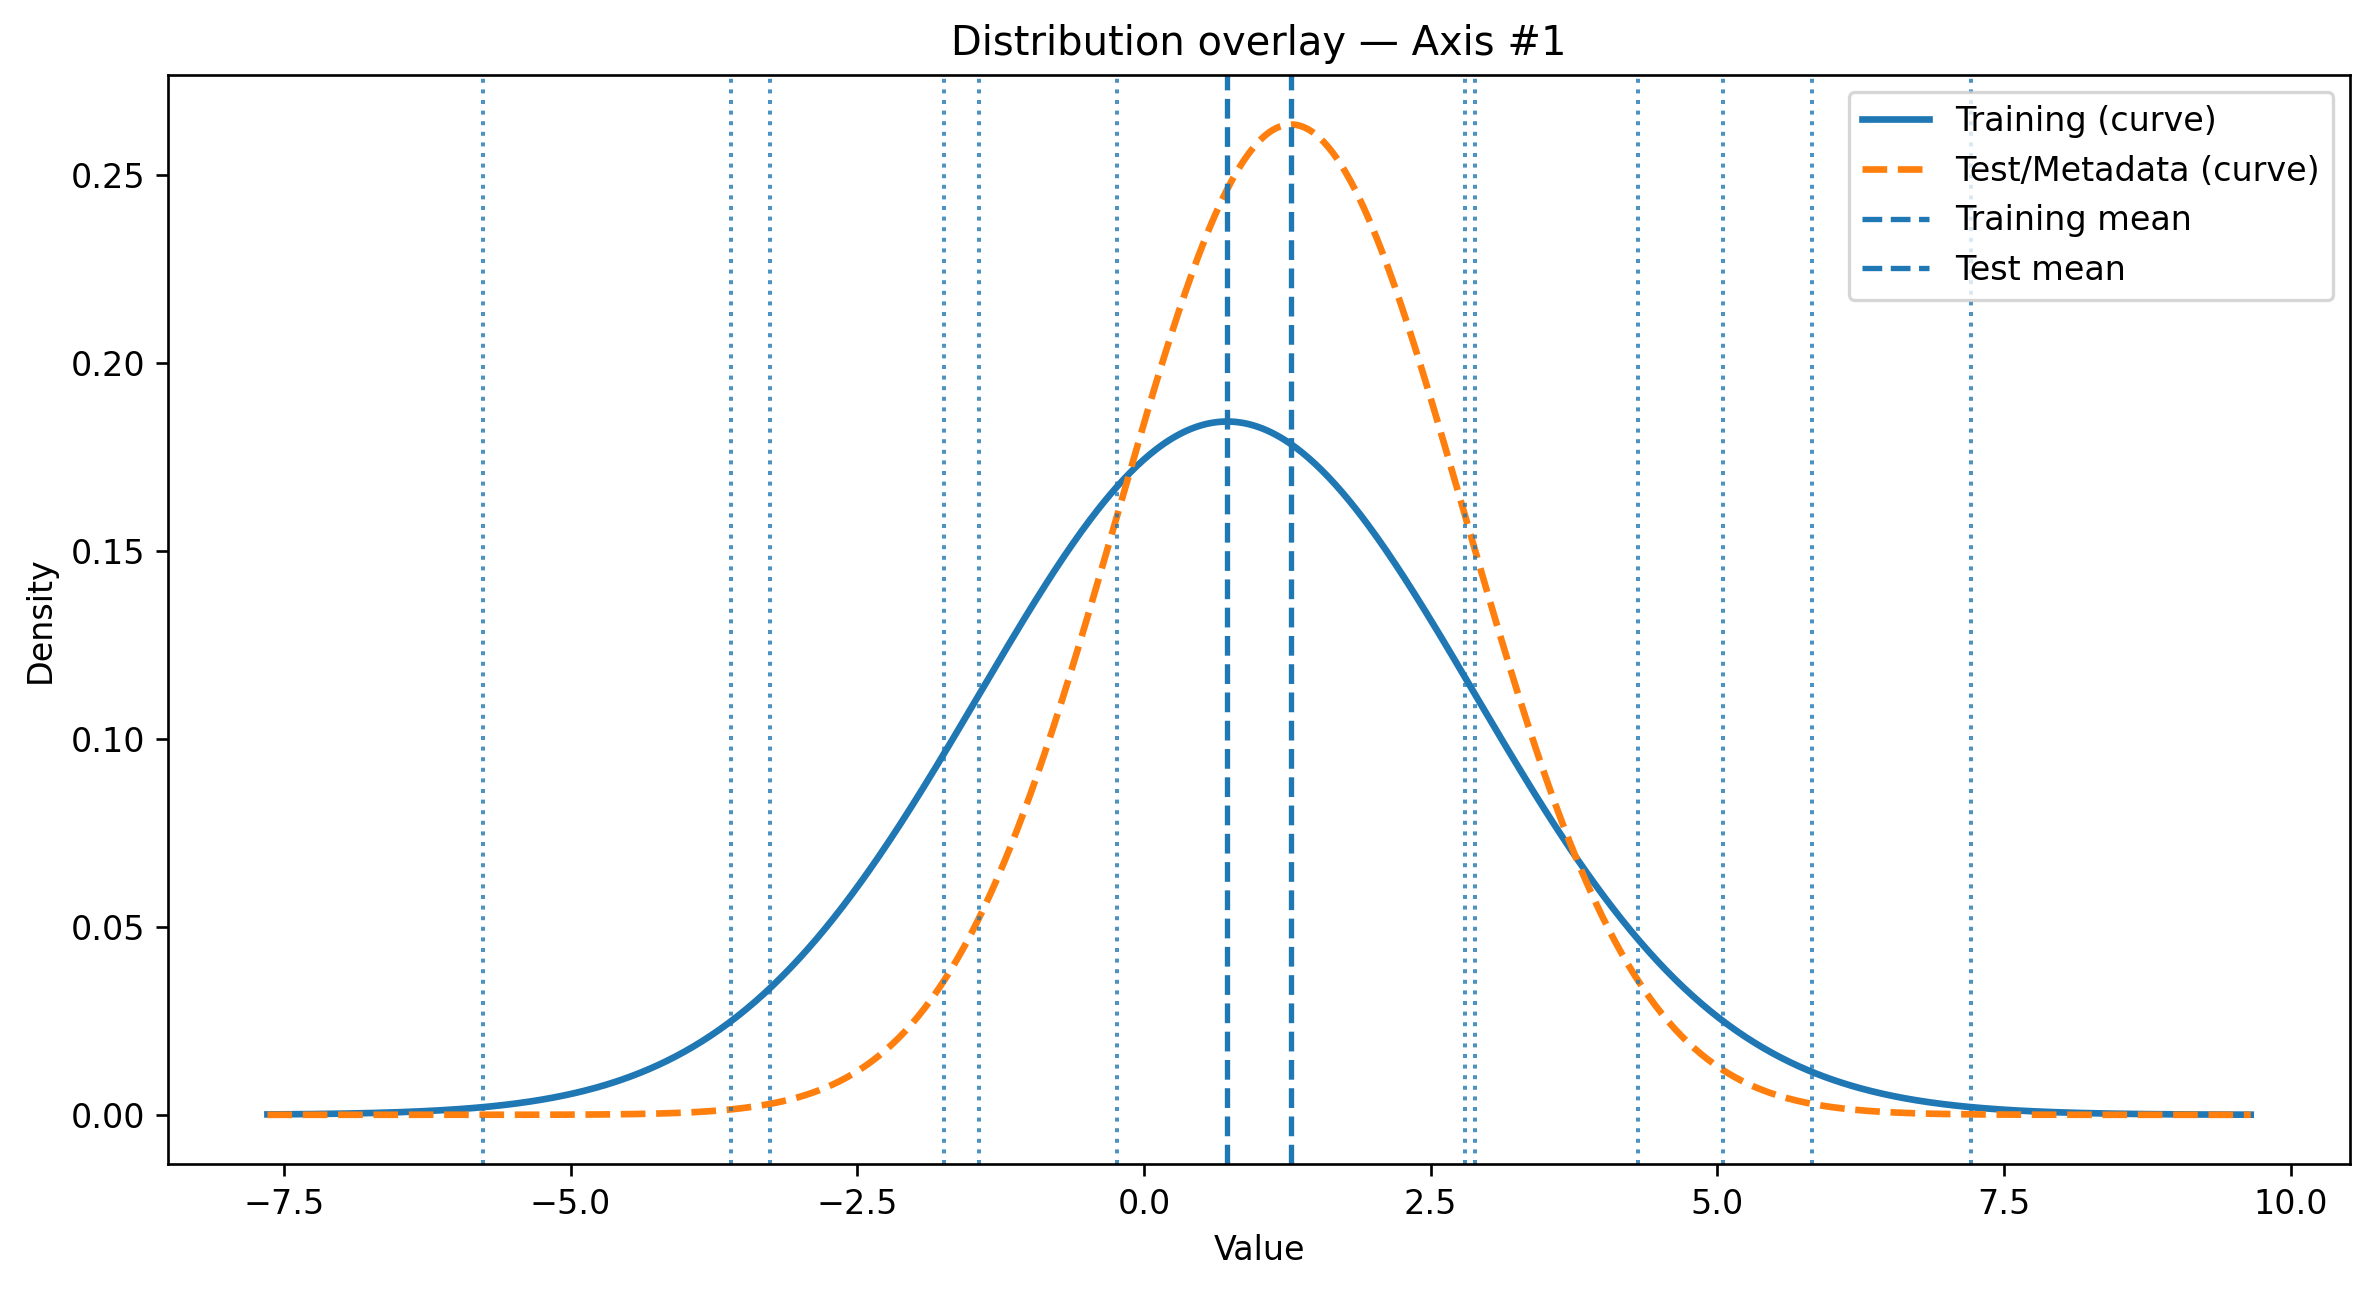

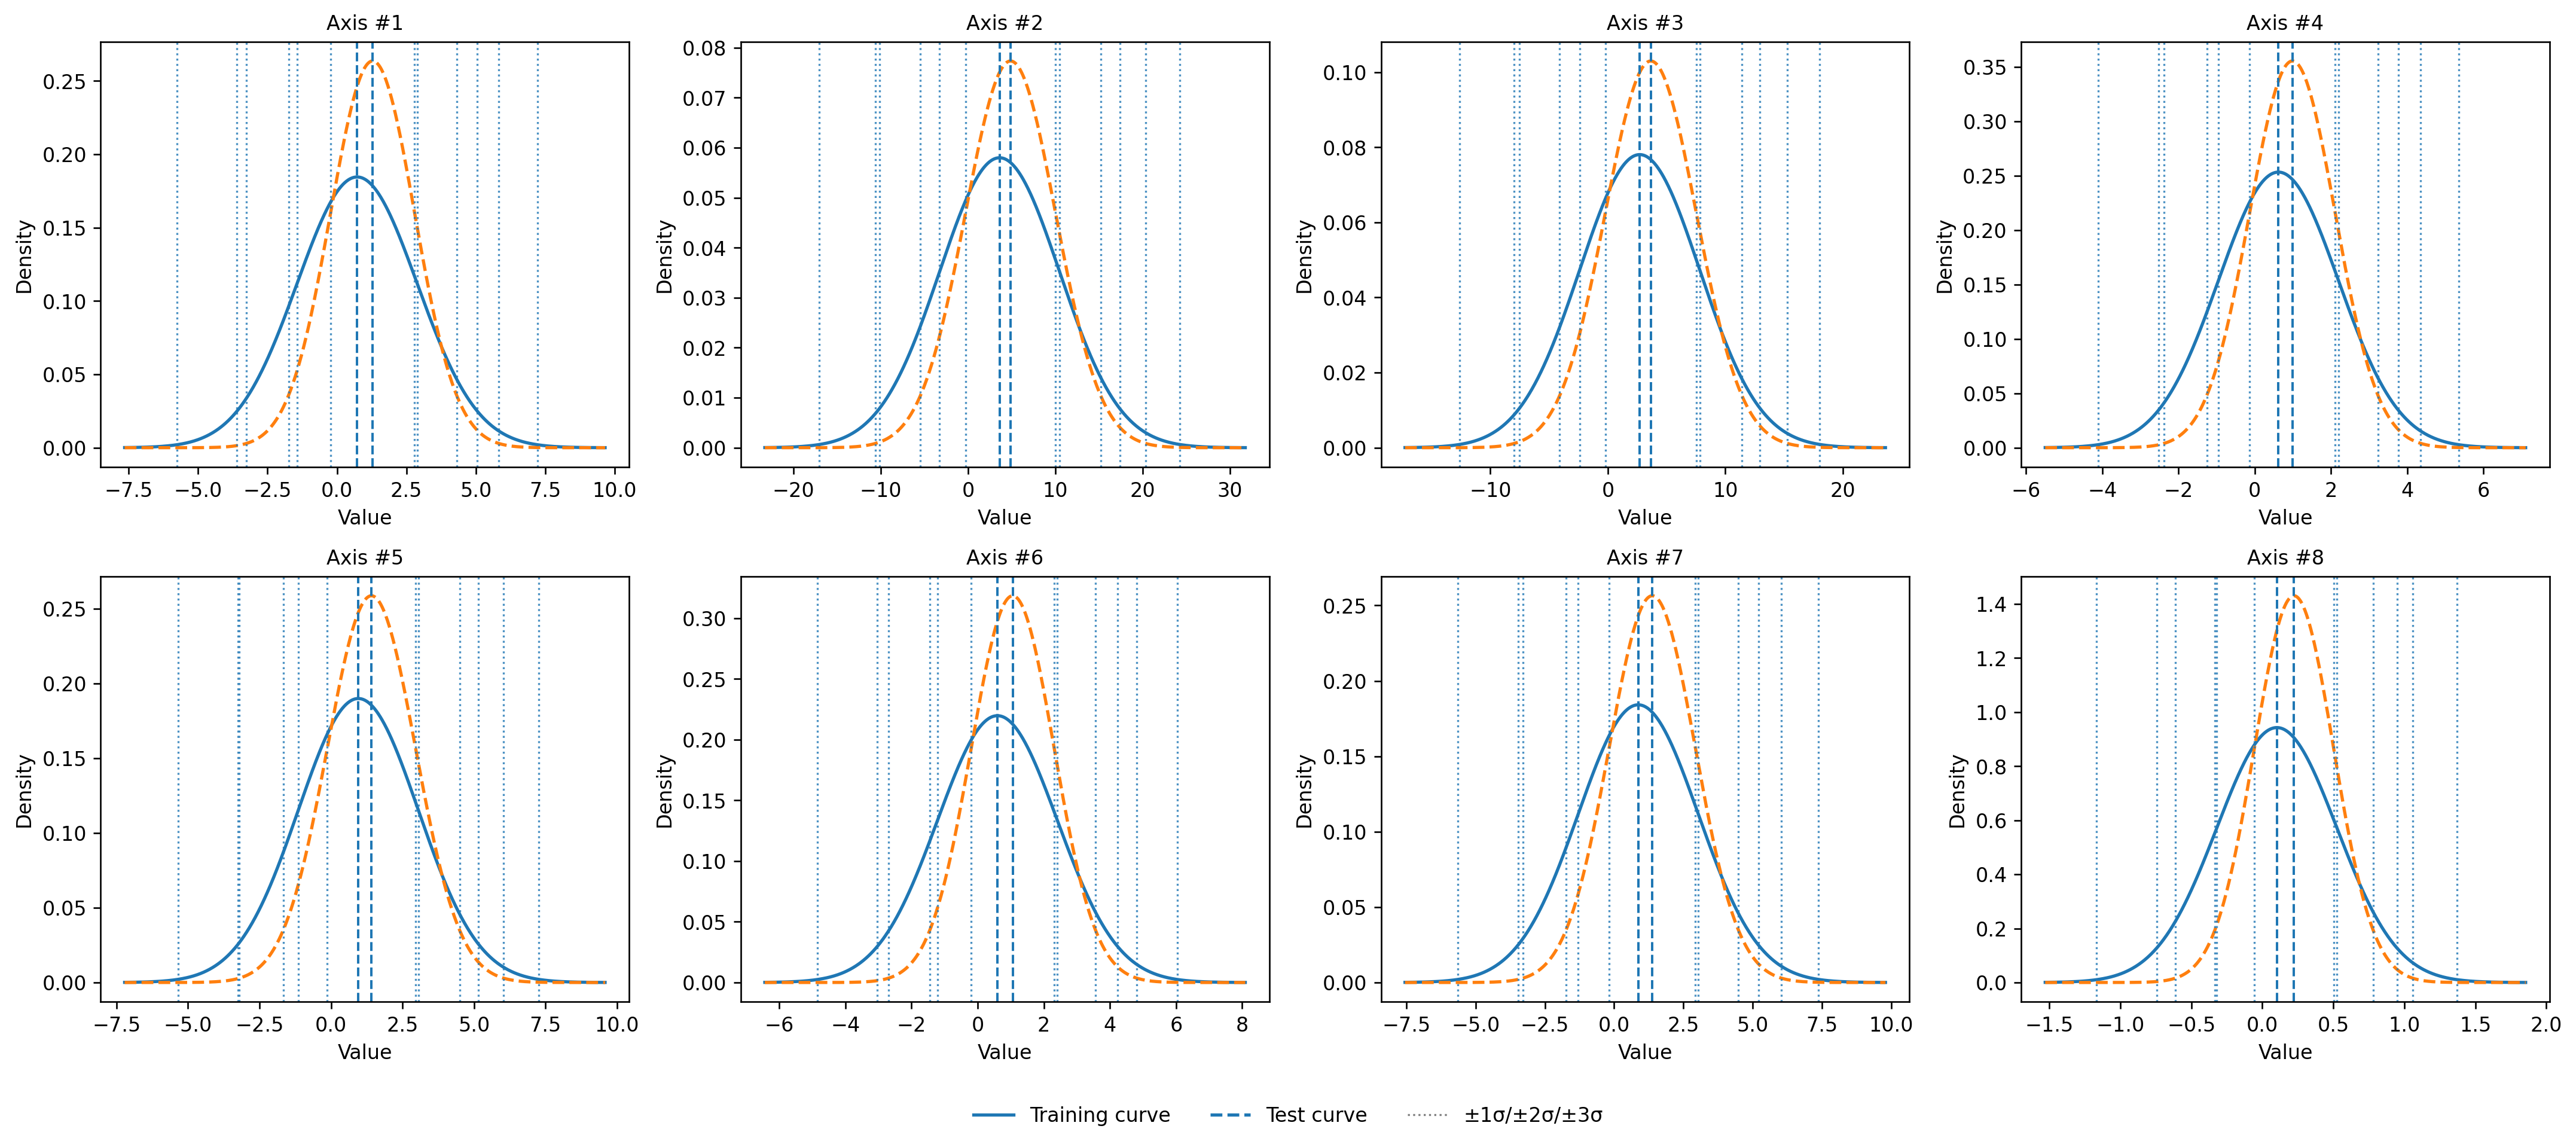

In [453]:
# Cell 3.0a — Training vs Test distribution overlays (regen)
# Part 1: One-axis sanity check (required by brief)
# Part 2: 2×4 grid for all 8 axes (optional dashboard)

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ---- Training source: DB only (from Cell 0.DB)
assert 'train' in globals(), "TRAIN not found. Run Cell 0.DB to pull from Neon."

# --- knobs ---
FORCE_SHOW_QUARTILES = None  # None=auto; True=always show; False=never
SIMILARITY_EPS = 0.10        # auto: show quartiles if means/σ are within ~10%

def _normal_pdf(x, mu, sd):
    sd = max(float(sd), 1e-9)
    return (1.0 / (np.sqrt(2*np.pi) * sd)) * np.exp(-0.5 * ((x - mu) / sd) ** 2)

# -------------------------------------------------
# Load the requested TEST dataset path (LOCAL ONLY)
# -------------------------------------------------
test_overlay = pd.read_csv("../data/metadata_regen_clean.csv").copy()
if 'Trait' not in test_overlay.columns:
    test_overlay['Trait'] = 'current'

# Resolve axes (prefer your globals if set, else infer from DB 'train')
if "axes" in globals():
    _axes = list(axes)
elif "AXES" in globals():
    _axes = list(AXES)
elif "axes_eval" in globals() and len(axes_eval) > 0:
    _axes = list(axes_eval)
else:
    _axes = [c for c in train.columns if str(c).lower().startswith("axis")]
_axes = _axes[:8]
assert len(_axes) > 0, "No Axis columns found to plot."

# -------------------------
# Part 1: One-axis overlay
# -------------------------
AX_TO_PLOT = _axes[0]

# Training stats (from DB)
s_train = train[AX_TO_PLOT].dropna().astype(float).values
mu_t, sd_t = float(np.mean(s_train)), float(np.std(s_train, ddof=1))
q1_t, med_t, q3_t = np.percentile(s_train, [25, 50, 75])

# Test/Metadata stats (regen CSV)
s_test = test_overlay[AX_TO_PLOT].dropna().astype(float).values
mu_m, sd_m = float(np.mean(s_test)), float(np.std(s_test, ddof=1))
q1_m, med_m, q3_m = np.percentile(s_test, [25, 50, 75])

# x-range
span = 4 * max(sd_t if sd_t > 0 else 1.0, sd_m if sd_m > 0 else 1.0)
mid  = 0.5 * (mu_t + mu_m)
xs   = np.linspace(mid - span, mid + span, 900)

# auto quartiles
if FORCE_SHOW_QUARTILES is None:
    pooled = max(1e-9, 0.5 * (sd_t + sd_m))
    mean_close = abs(mu_t - mu_m) <= SIMILARITY_EPS * pooled
    sd_close   = abs(sd_t - sd_m) <= SIMILARITY_EPS * pooled
    SHOW_Q = bool(mean_close and sd_close)
else:
    SHOW_Q = bool(FORCE_SHOW_QUARTILES)

plt.figure(figsize=(10, 5.5))
plt.plot(xs, _normal_pdf(xs, mu_t, sd_t), lw=2,  label="Training (curve)")
plt.plot(xs, _normal_pdf(xs, mu_m, sd_m), lw=2,  ls="--", label="Test/Metadata (curve)")
plt.axvline(mu_t, lw=1.6, ls="--", label="Training mean")
plt.axvline(mu_m, lw=1.6, ls="--", label="Test mean")
for k in (1, 2, 3):
    plt.axvline(mu_t - k*sd_t, ls=":", lw=1.2, alpha=0.8)
    plt.axvline(mu_t + k*sd_t, ls=":", lw=1.2, alpha=0.8)
    plt.axvline(mu_m - k*sd_m, ls=":", lw=1.2, alpha=0.8)
    plt.axvline(mu_m + k*sd_m, ls=":", lw=1.2, alpha=0.8)
if SHOW_Q:
    plt.axvline(q1_t,  color="purple", ls="dashdot", lw=1.2, alpha=0.9)
    plt.axvline(med_t, color="brown",  ls="dashdot", lw=1.2, alpha=0.9)
    plt.axvline(q3_t,  color="purple", ls="dashdot", lw=1.2, alpha=0.9)
    plt.axvline(q1_m,  color="purple", ls="dashdot", lw=1.2, alpha=0.55)
    plt.axvline(med_m, color="brown",  ls="dashdot", lw=1.2, alpha=0.55)
    plt.axvline(q3_m,  color="purple", ls="dashdot", lw=1.2, alpha=0.55)

plt.title(f"Distribution overlay — {AX_TO_PLOT}")
plt.xlabel("Value"); plt.ylabel("Density")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# -------------------------
# Part 2: 2×4 grid overlays
# -------------------------
nrows, ncols = 2, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 8))
axs = axs.ravel()

for i, ax_name in enumerate(_axes):
    axp = axs[i]
    s_train = train[ax_name].dropna().astype(float).values
    mu_t, sd_t = float(np.mean(s_train)), float(np.std(s_train, ddof=1))
    s_test = test_overlay[ax_name].dropna().astype(float).values
    mu_m, sd_m = float(np.mean(s_test)), float(np.std(s_test, ddof=1))

    span = 4 * max(sd_t if sd_t > 0 else 1.0, sd_m if sd_m > 0 else 1.0)
    mid  = 0.5 * (mu_t + mu_m)
    xs   = np.linspace(mid - span, mid + span, 800)

    axp.plot(xs, _normal_pdf(xs, mu_t, sd_t), lw=1.6, label="Training")
    axp.plot(xs, _normal_pdf(xs, mu_m, sd_m), lw=1.6, ls="--", label="Test")
    axp.axvline(mu_t, lw=1.2, ls="--")
    axp.axvline(mu_m, lw=1.2, ls="--")
    for k in (1, 2, 3):
        axp.axvline(mu_t - k*sd_t, ls=":", lw=1, alpha=0.8)
        axp.axvline(mu_t + k*sd_t, ls=":", lw=1, alpha=0.8)
        axp.axvline(mu_m - k*sd_m, ls=":", lw=1, alpha=0.8)
        axp.axvline(mu_m + k*sd_m, ls=":", lw=1, alpha=0.8)

    axp.set_title(ax_name, fontsize=10)
    axp.set_xlabel("Value"); axp.set_ylabel("Density")

# Hide unused slots if <8 axes
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

legend_handles = [
    Line2D([0],[0], lw=1.6, ls="-",  label="Training curve"),
    Line2D([0],[0], lw=1.6, ls="--", label="Test curve"),
    Line2D([0],[0], color="gray", lw=1.0, ls=":",  label="±1σ/±2σ/±3σ"),
]
fig.tight_layout()
fig.legend(handles=legend_handles, loc="lower center", ncol=3, frameon=False)
plt.subplots_adjust(bottom=0.12)
plt.show()

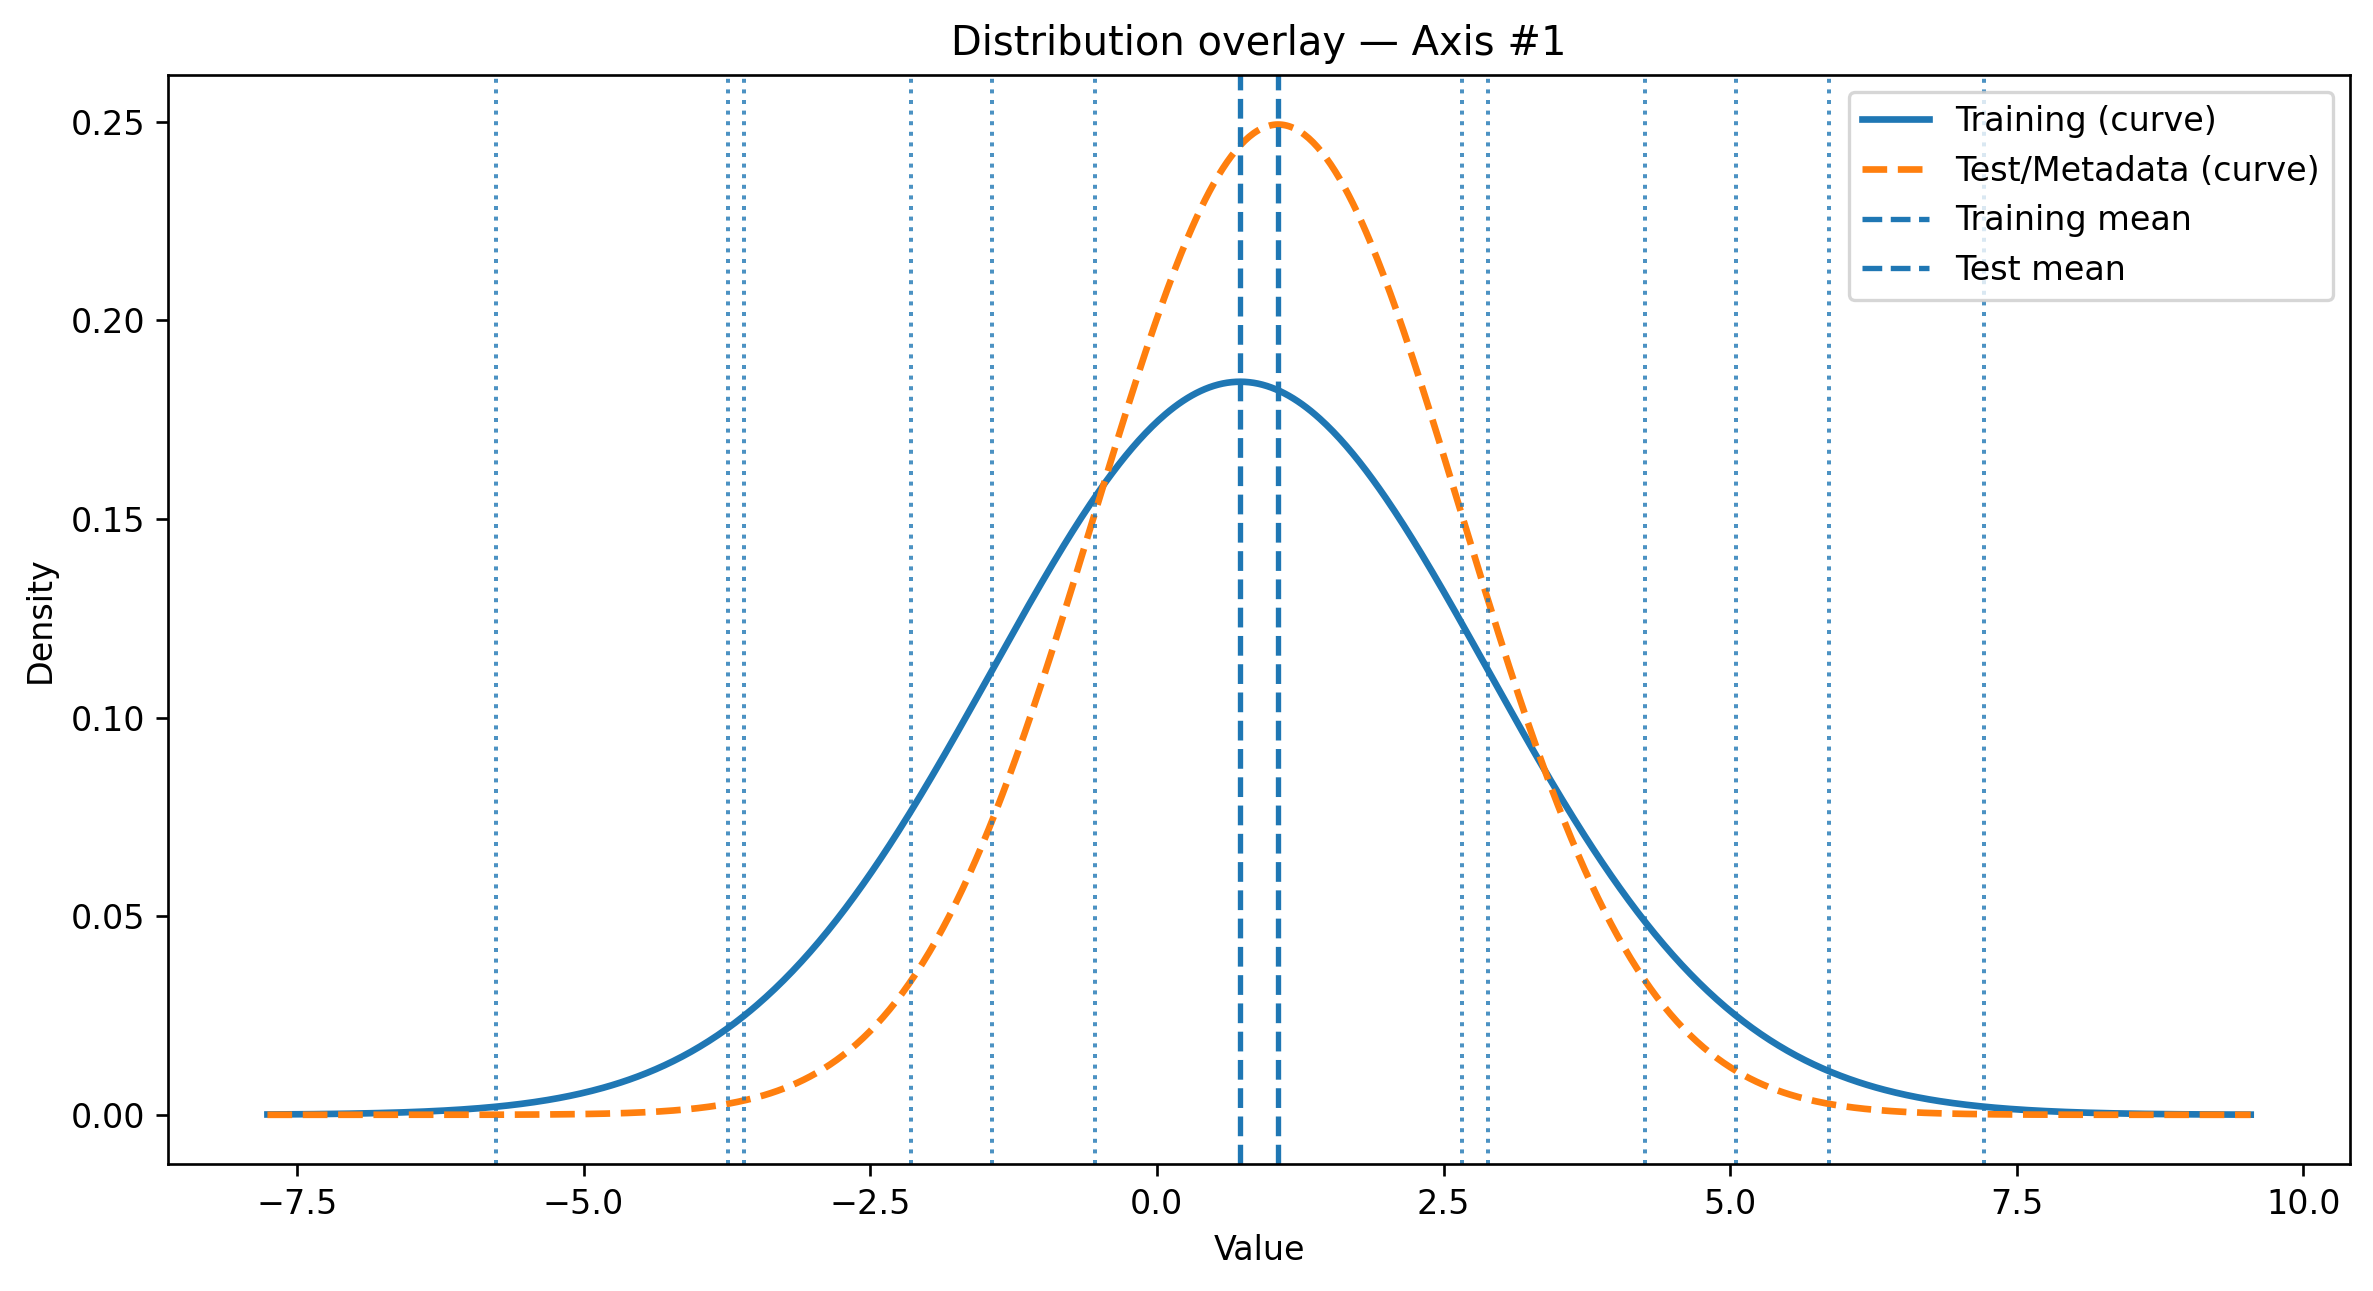

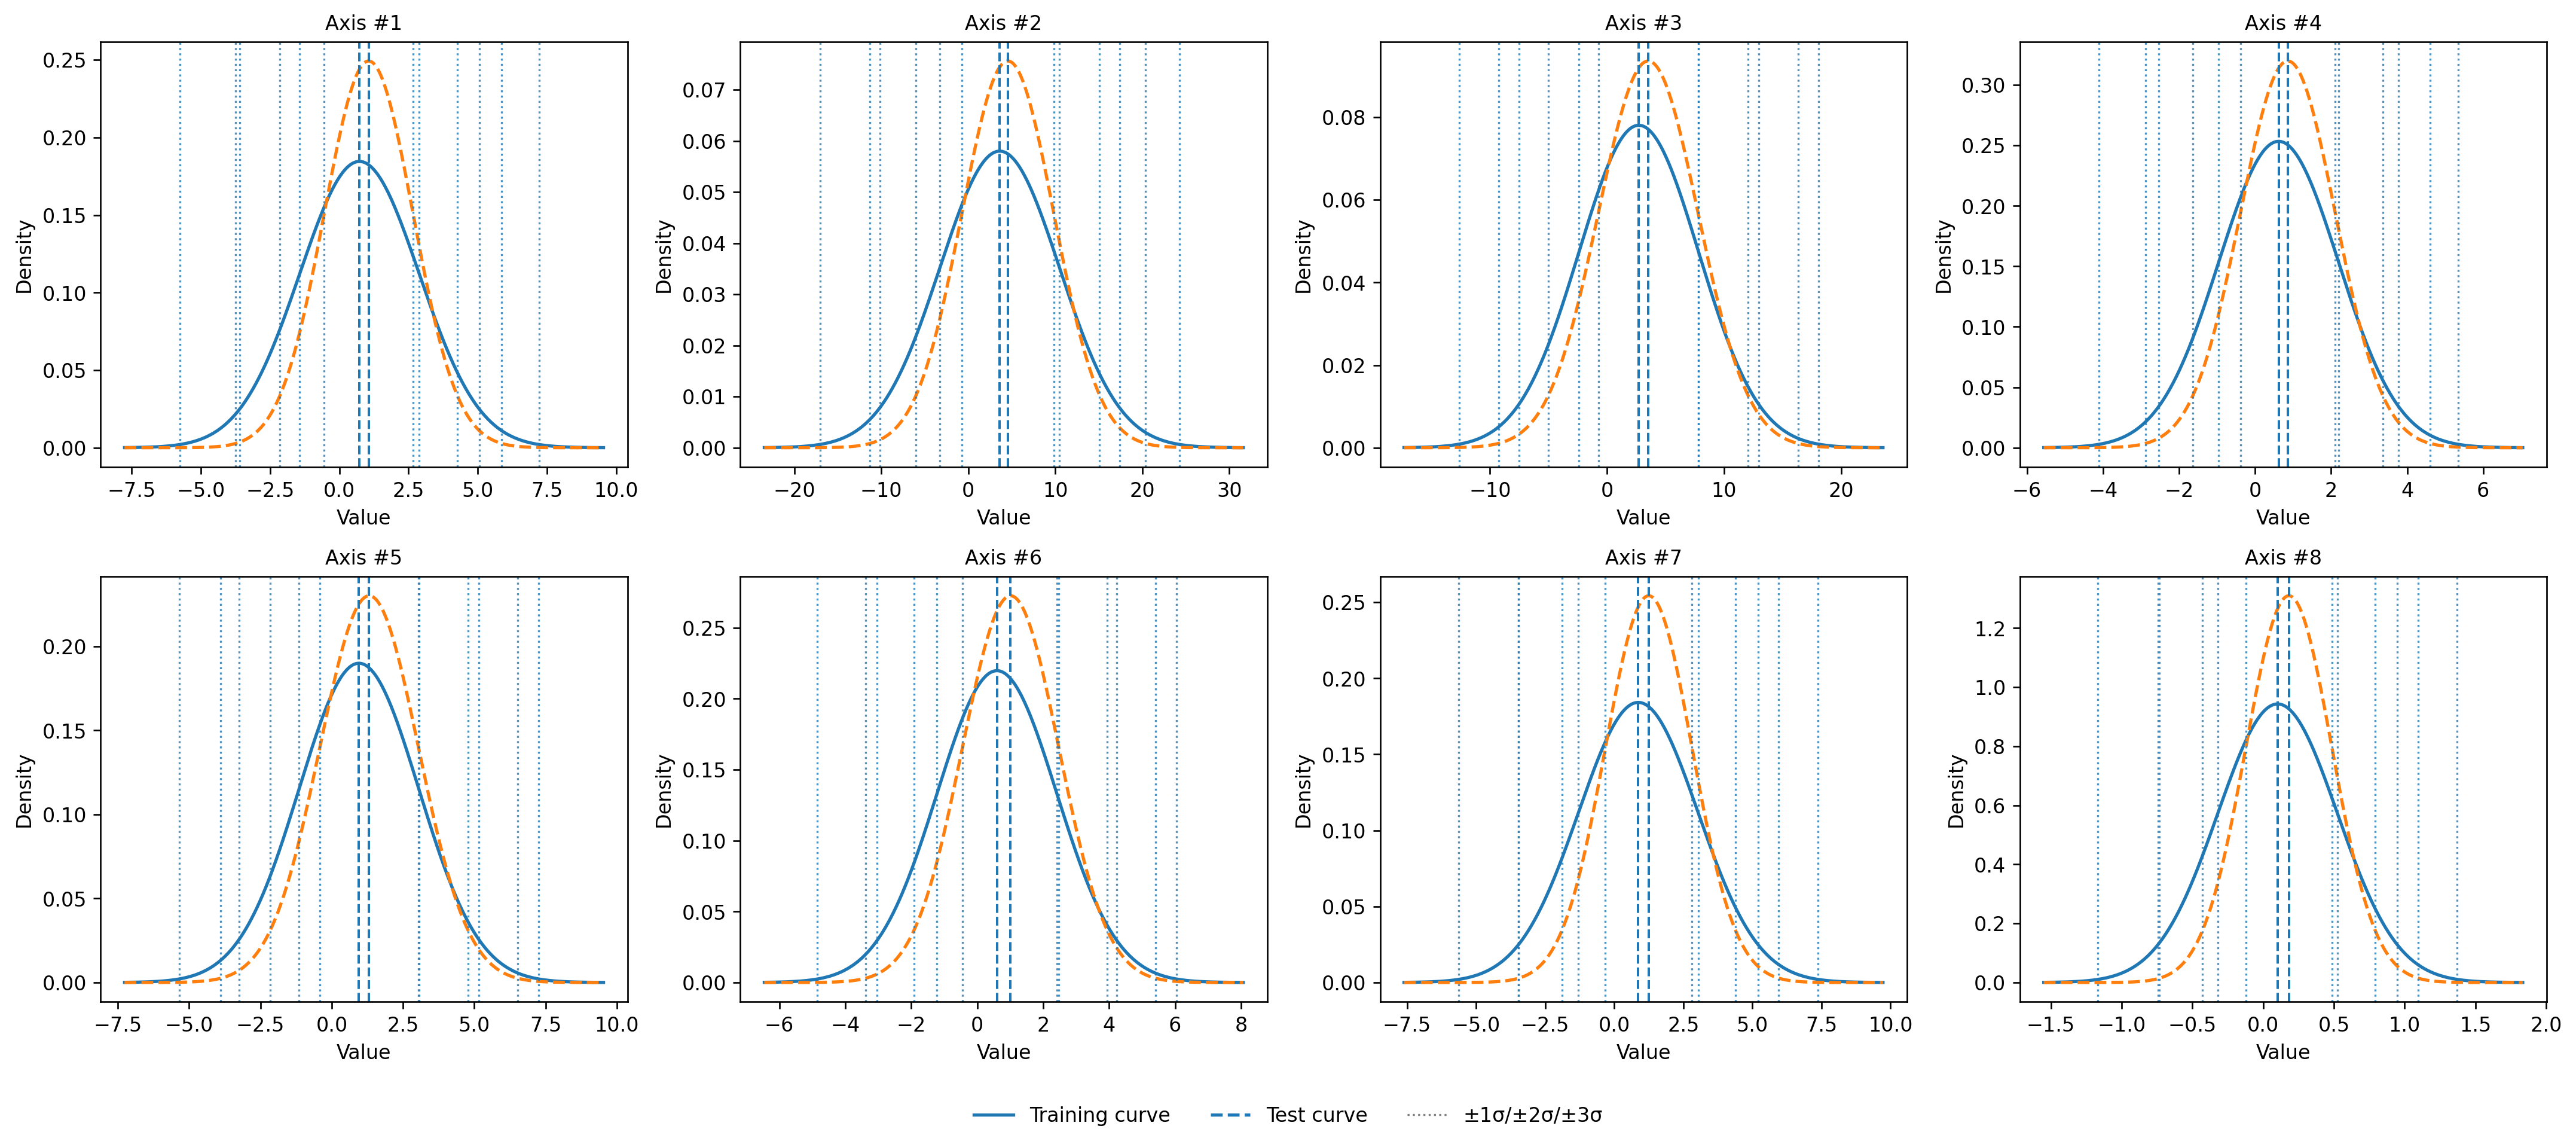

In [454]:
# Cell 3.0b — Training vs Test distribution overlays (wilk, safe)
# Part 1: One-axis sanity check
# Part 2: 2×4 grid for axes #1–#8

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ---- Training source: DB only (from Cell 0.DB)
assert 'train' in globals(), "TRAIN not found. Run Cell 0.DB to pull from Neon."
train_overlay = train.copy()

# ---- Test / metadata (CSV is OK for TEST)
TEST_CSV = "../data/metadata_wilk_clean.csv"
test_overlay = pd.read_csv(TEST_CSV).copy()
if 'Trait' not in test_overlay.columns:
    test_overlay['Trait'] = 'current'

# ---- Resolve axes — prefer your global lists if defined
if "axes" in globals():
    _axes = list(axes)
elif "AXES" in globals():
    _axes = list(AXES)
elif "axes_eval" in globals() and len(axes_eval) > 0:
    _axes = list(axes_eval)
else:
    _axes = [c for c in train_overlay.columns if str(c).lower().startswith("axis")]
_axes = _axes[:8]
assert len(_axes) > 0, "No Axis columns found to plot."

# ---- Keep only needed cols for plotting (local copies)
_use_cols = ["Trait"] + _axes + (["Time"] if "Time" in train_overlay.columns else [])
use_cols_in_train = [c for c in _use_cols if c in train_overlay.columns]
use_cols_in_test  = [c for c in _use_cols if c in test_overlay.columns]

train_plot = train_overlay[use_cols_in_train].copy()
test_plot  = test_overlay[use_cols_in_test].copy()

# Ensure numeric for axes
for ax in _axes:
    if ax in train_plot.columns:
        train_plot[ax] = pd.to_numeric(train_plot[ax], errors="coerce")
    if ax in test_plot.columns:
        test_plot[ax]  = pd.to_numeric(test_plot[ax],  errors="coerce")

# --- knobs ---
FORCE_SHOW_QUARTILES = None     # None=auto; True=always; False=never
SIMILARITY_EPS = 0.10

def _normal_pdf(x, mu, sd):
    sd = max(float(sd), 1e-9)
    return (1.0 / (np.sqrt(2*np.pi) * sd)) * np.exp(-0.5 * ((x - mu) / sd) ** 2)

# -------------------------
# Part 1: One-axis overlay
# -------------------------
AX_TO_PLOT = _axes[0]

s_train = train_plot[AX_TO_PLOT].dropna().astype(float).values
mu_t    = float(np.mean(s_train))
sd_t    = float(np.std(s_train, ddof=1))
q1_t, med_t, q3_t = np.percentile(s_train, [25, 50, 75])

s_test = test_plot[AX_TO_PLOT].dropna().astype(float).values
mu_m   = float(np.mean(s_test))
sd_m   = float(np.std(s_test, ddof=1))
q1_m, med_m, q3_m = np.percentile(s_test, [25, 50, 75])

span = 4 * max(sd_t if sd_t > 0 else 1.0, sd_m if sd_m > 0 else 1.0)
mid  = 0.5 * (mu_t + mu_m)
xs   = np.linspace(mid - span, mid + span, 900)

if FORCE_SHOW_QUARTILES is None:
    pooled = max(1e-9, 0.5 * (sd_t + sd_m))
    mean_close = abs(mu_t - mu_m) <= SIMILARITY_EPS * pooled
    sd_close   = abs(sd_t - sd_m) <= SIMILARITY_EPS * pooled
    SHOW_Q = bool(mean_close and sd_close)
else:
    SHOW_Q = bool(FORCE_SHOW_QUARTILES)

plt.figure(figsize=(10, 5.5))
plt.plot(xs, _normal_pdf(xs, mu_t, sd_t), lw=2,  label="Training (curve)")
plt.plot(xs, _normal_pdf(xs, mu_m, sd_m), lw=2,  ls="--", label="Test/Metadata (curve)")
plt.axvline(mu_t, lw=1.6, ls="--", label="Training mean")
plt.axvline(mu_m, lw=1.6, ls="--", label="Test mean")
for k in (1, 2, 3):
    plt.axvline(mu_t - k*sd_t, ls=":", lw=1.2, alpha=0.8)
    plt.axvline(mu_t + k*sd_t, ls=":", lw=1.2, alpha=0.8)
    plt.axvline(mu_m - k*sd_m, ls=":", lw=1.2, alpha=0.8)
    plt.axvline(mu_m + k*sd_m, ls=":", lw=1.2, alpha=0.8)
if SHOW_Q:
    plt.axvline(q1_t,  color="purple", ls="dashdot", lw=1.2, alpha=0.9)
    plt.axvline(med_t, color="brown",  ls="dashdot", lw=1.2, alpha=0.9)
    plt.axvline(q3_t,  color="purple", ls="dashdot", lw=1.2, alpha=0.9)
    plt.axvline(q1_m,  color="purple", ls="dashdot", lw=1.2, alpha=0.55)
    plt.axvline(med_m, color="brown",  ls="dashdot", lw=1.2, alpha=0.55)
    plt.axvline(q3_m,  color="purple", ls="dashdot", lw=1.2, alpha=0.55)

plt.title(f"Distribution overlay — {AX_TO_PLOT}")
plt.xlabel("Value"); plt.ylabel("Density")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# -------------------------
# Part 2: 2×4 grid overlays
# -------------------------
nrows, ncols = 2, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 8))
axs = axs.ravel()

for i, ax_name in enumerate(_axes):
    axp = axs[i]
    s_train = train_plot[ax_name].dropna().astype(float).values
    mu_t, sd_t = float(np.mean(s_train)), float(np.std(s_train, ddof=1))
    s_test = test_plot[ax_name].dropna().astype(float).values
    mu_m, sd_m = float(np.mean(s_test)), float(np.std(s_test, ddof=1))

    span = 4 * max(sd_t if sd_t > 0 else 1.0, sd_m if sd_m > 0 else 1.0)
    mid  = 0.5 * (mu_t + mu_m)
    xs   = np.linspace(mid - span, mid + span, 800)

    axp.plot(xs, _normal_pdf(xs, mu_t, sd_t), lw=1.6, label="Training")
    axp.plot(xs, _normal_pdf(xs, mu_m, sd_m), lw=1.6, ls="--", label="Test")
    axp.axvline(mu_t, lw=1.2, ls="--")
    axp.axvline(mu_m, lw=1.2, ls="--")
    for k in (1, 2, 3):
        axp.axvline(mu_t - k*sd_t, ls=":", lw=1, alpha=0.8)
        axp.axvline(mu_t + k*sd_t, ls=":", lw=1, alpha=0.8)
        axp.axvline(mu_m - k*sd_m, ls=":", lw=1, alpha=0.8)
        axp.axvline(mu_m + k*sd_m, ls=":", lw=1, alpha=0.8)

    axp.set_title(ax_name, fontsize=10)
    axp.set_xlabel("Value"); axp.set_ylabel("Density")

# Hide any unused subplot slots (if fewer than 8 axes)
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

legend_handles = [
    Line2D([0],[0], lw=1.6, ls="-",  label="Training curve"),
    Line2D([0],[0], lw=1.6, ls="--", label="Test curve"),
    Line2D([0],[0], color="gray", lw=1.0, ls=":",  label="±1σ/±2σ/±3σ"),
]
fig.tight_layout()
fig.legend(handles=legend_handles, loc="lower center", ncol=3, frameon=False)
plt.subplots_adjust(bottom=0.12)
plt.show()

In [455]:
# Cell 3.0c - Align metadata μ/σ to training (per axis) and save as metadata_wilk_aligned.csv ---
import numpy as np, pandas as pd

AXES = [c for c in test.columns if str(c).lower().startswith("axis")][:8]
assert len(AXES) == 8, "Need 8 numeric Axis columns."

aligned = test.copy()
summary_rows = []

for ax in AXES:
    tr = pd.to_numeric(train[ax], errors="coerce").dropna()
    te = pd.to_numeric(test[ax],  errors="coerce")

    mu_tr, sd_tr = float(tr.mean()), float(tr.std(ddof=1))
    mu_te, sd_te = float(te.mean()), float(te.std(ddof=1))
    mn_tr, mx_tr = float(tr.min()),  float(tr.max())

    # Avoid zero std blow-ups
    scale = (sd_tr / sd_te) if sd_te and np.isfinite(sd_te) and sd_te > 0 else 1.0

    # Shift+scale: bring test to training distribution
    adj = (te - mu_te) * scale + mu_tr

    # Clip to training range with a tiny margin
    margin = 0.02  # 2%
    lo = mn_tr - margin * max(1e-9, abs(mn_tr))
    hi = mx_tr + margin * max(1e-9, abs(mx_tr))
    adj = adj.clip(lower=min(lo, hi), upper=max(lo, hi))

    aligned[ax] = adj

    # Collect post-adjust stats
    mu_adj = float(pd.to_numeric(aligned[ax], errors="coerce").mean())
    sd_adj = float(pd.to_numeric(aligned[ax], errors="coerce").std(ddof=1))
    summary_rows.append({
        "axis": ax,
        "μ_train": mu_tr, "σ_train": sd_tr,
        "μ_meta_before": mu_te, "σ_meta_before": sd_te,
        "μ_meta_after":  mu_adj, "σ_meta_after":  sd_adj,
        "Δμ_rel_after": abs(mu_adj - mu_tr) / (abs(mu_tr) + 1e-9),
        "Δσ_rel_after": abs(sd_adj - sd_tr) / (abs(sd_tr) + 1e-9)
    })

summary = pd.DataFrame(summary_rows)
display(summary.style.format({
    "μ_train":"{:.5f}","σ_train":"{:.5f}",
    "μ_meta_before":"{:.5f}","σ_meta_before":"{:.5f}",
    "μ_meta_after":"{:.5f}","σ_meta_after":"{:.5f}",
    "Δμ_rel_after":"{:.1%}","Δσ_rel_after":"{:.1%}"
}))

# Save aligned metadata
out_path = "../data/metadata_wilk_aligned.csv"
aligned.to_csv(out_path, index=False)
print(f"✅ Wrote aligned metadata to {out_path}")

# Re-run your Shapiro/Similarity report against `aligned` instead of `test`
test = aligned  # swap in for downstream steps (streaming, playback, etc.)

✅ Wrote aligned metadata to ../data/metadata_wilk_aligned.csv


In [456]:
# Cell 3.0d - Shapiro–Wilk & Similarity Report (TRAIN vs METADATA) — robust, no hard fail on Jinja2 ---
import numpy as np, pandas as pd
from scipy.stats import shapiro

# EXPECTS: DataFrames `train` and `test` already loaded.
AXES = [c for c in test.columns if str(c).lower().startswith("axis")][:8]
assert len(AXES) == 8, "Need 8 numeric axis columns in `test`."

rows = []
for ax in AXES:
    tr = pd.to_numeric(train[ax], errors="coerce").dropna()
    te = pd.to_numeric(test[ax],  errors="coerce").dropna()

    mu_tr, sd_tr = float(tr.mean()), float(tr.std(ddof=1))
    mu_te, sd_te = float(te.mean()), float(te.std(ddof=1))

    n_tr = min(len(tr), 5000)
    n_te = min(len(te), 5000)
    p_tr = shapiro(tr.sample(n_tr, random_state=42) if len(tr) > n_tr else tr).pvalue if n_tr >= 3 else np.nan
    p_te = shapiro(te.sample(n_te, random_state=42) if len(te) > n_te else te).pvalue if n_te >= 3 else np.nan

    tol_mu = abs(mu_te - mu_tr) / (abs(mu_tr) + 1e-9)
    tol_sd = abs(sd_te - sd_tr) / (abs(sd_tr) + 1e-9)

    rows.append({
        "axis": ax,
        "μ_train": mu_tr, "σ_train": sd_tr,
        "μ_meta":  mu_te, "σ_meta":  sd_te,
        "Δμ_rel": tol_mu, "Δσ_rel": tol_sd,
        "Shapiro_p_train": p_tr, "Shapiro_p_meta": p_te,
        "μ_within_±5%": tol_mu <= 0.05,
        "σ_within_±10%": tol_sd <= 0.10
    })

report_df = pd.DataFrame(rows)

# ---- Try pretty Styler table; fall back to plain DataFrame if Jinja2 not present ----
fmt = {
    "μ_train":"{:.5f}","σ_train":"{:.5f}",
    "μ_meta":"{:.5f}","σ_meta":"{:.5f}",
    "Δμ_rel":"{:.1%}","Δσ_rel":"{:.1%}",
    "Shapiro_p_train":"{:.3f}","Shapiro_p_meta":"{:.3f}"
}

def _plain_print(df):
    df2 = df.copy()
    # apply formatting in plain mode
    for c, f in fmt.items():
        if c in df2.columns:
            df2[c] = df2[c].map(lambda v: f.format(v) if pd.notna(v) else "")
    # make booleans explicit
    for c in ["μ_within_±5%","σ_within_±10%"]:
        if c in df2.columns:
            df2[c] = df2[c].map(lambda x: "OK" if bool(x) else "NO")
    print(df2.to_string(index=False))

try:
    import jinja2  # noqa: F401
    # Only use Styler if available; otherwise fall back
    try:
        styler = (report_df.style
                  .format(fmt)
                  .apply(lambda s: ["background-color:#eaffea" if v is True 
                                    else ("background-color:#ffecec" if v is False else "")
                                    for v in s], subset=["μ_within_±5%","σ_within_±10%"]))
        display(styler)
    except Exception:
        print("Note: Pandas Styler unavailable in this kernel; showing plain table.\n")
        _plain_print(report_df)
except Exception:
    print("Note: Jinja2 not available; showing plain table.\n")
    _plain_print(report_df)

# ---- Decision summary (always prints, independent of styling) ----
ok_mu = bool(report_df["μ_within_±5%"].all())
ok_sd = bool(report_df["σ_within_±10%"].all())
print(f"\nDecision: μ within ±5% across all axes = {ok_mu}; σ within ±10% across all axes = {ok_sd}.")
print("Note: Shapiro p-values shown for transparency; normality is not strictly required, but reported.")



Decision: μ within ±5% across all axes = False; σ within ±10% across all axes = False.
Note: Shapiro p-values shown for transparency; normality is not strictly required, but reported.


### Setting up TRAIN and Candidate TEST Data

At this point, the pipeline connects to the **Neon PostgreSQL database** and loads the TRAIN dataset (`readings_fact_csv`).  
Key steps:

1. **DB connection**: Using credentials from `.env`, the script pulls ~39,672 rows of training data.  
2. **Time handling**: Ensures a proper `Time` column, converts to UTC, sorts, and derives a continuous `t_sec` (seconds from start).  
3. **Axes policy**: Selects the first 8 axes (`Axis #1` … `Axis #8`) for consistency with rubric.  
4. **Candidate scoring**: Two synthetic metadata files are evaluated:
   - `metadata_regen_clean.csv`
   - `metadata_wilk_clean.csv`  
   Each candidate is scored based on:
   - Similarity of mean/std (z-like measure + log ratio)  
   - Cadence difference (Δdt)  
   - Axis coverage (penalizes missing axes)  
   Lower score = better match to TRAIN.  

At this stage, we are preparing to decide which candidate TEST dataset (regen vs. wilk) is the most “train-like” for downstream regression/alert analysis.

In [457]:
# Cell 4.0 — Unified TRAIN+TEST setup (DB → clean → pick TEST → align → axes policy)

import os, re
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
from IPython.display import display

# ---------- DB setup ----------
load_dotenv(override=True)
PG_URL = os.getenv("DATABASE_URL")
TABLE_NAME = os.getenv("TRAINING_TABLE", "readings_fact_csv")
assert PG_URL, "❌ DATABASE_URL not set in .env"
engine = create_engine(PG_URL, future=True)

# ---------- Helpers ----------
def _axis_num(name: str):
    m = re.match(r"^\s*Axis\s*#\s*(\d+)\s*$", str(name))
    return int(m.group(1)) if m else None

def _coerce_time_col(df: pd.DataFrame):
    for c in ["Time","time","Timestamp","timestamp","time_ts","Datetime","datetime"]:
        if c in df.columns:
            if c != "Time":
                df.rename(columns={c: "Time"}, inplace=True)
            return
    raise KeyError("No time column found. Rename your time column to 'Time' or map it here.")

# ---------- Load TRAIN from Neon ----------
query = f'SELECT * FROM "{TABLE_NAME}"'
train = pd.read_sql(query, engine)
train.columns = [str(c).strip() for c in train.columns]
print(f"✅ Pulled {len(train):,} rows from Neon table '{TABLE_NAME}'")

# Time → UTC + t_sec
_coerce_time_col(train)
train["Time"] = pd.to_datetime(train["Time"], utc=True, errors="coerce")
train = train.dropna(subset=["Time"]).sort_values("Time").reset_index(drop=True)
t0 = train["Time"].iloc[0]
train["t_sec"] = (train["Time"] - t0).dt.total_seconds()
dt_train = float(pd.Series(train["t_sec"]).diff().median()) if len(train) > 1 else 0.0

# Axes (TRAIN: first 8 per rubric)
axes_train_all = sorted([c for c in train.columns if _axis_num(c)], key=_axis_num)
axes_train_8   = axes_train_all[:8]
assert axes_train_8, "❌ No 'Axis #N' columns found in TRAIN."

# ---------- Score candidates; pick best ----------
CANDIDATES = [
    "../data/metadata_regen_clean.csv",
    "../data/metadata_wilk_clean.csv",
]

def _score_candidate(path: str) -> dict:
    if not os.path.exists(path):
        return {"path": path, "ok": False, "reason": "file missing", "score": float("inf")}
    df = pd.read_csv(path, low_memory=False)
    df.columns = [str(c).strip() for c in df.columns]
    try:
        _coerce_time_col(df)
    except Exception as e:
        return {"path": path, "ok": False, "reason": f"time col: {e}", "score": float("inf")}
    df["Time"] = pd.to_datetime(df["Time"], utc=True, errors="coerce")
    df = df.dropna(subset=["Time"]).sort_values("Time").reset_index(drop=True)
    if df.empty:
        return {"path": path, "ok": False, "reason": "no valid Time rows", "score": float("inf")}

    # align to TRAIN start for comparability
    df["t_sec"] = (df["Time"] - t0).dt.total_seconds()
    dt_cand = float(pd.Series(df["t_sec"]).diff().median()) if len(df) > 1 else 0.0

    axes_cand = sorted([c for c in df.columns if _axis_num(c)], key=_axis_num)
    common = [a for a in axes_train_8 if a in axes_cand]
    if not common:
        return {"path": path, "ok": False, "reason": "no common axes", "score": float("inf")}

    # numeric coercion (safe)
    for c in common:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        train[c] = pd.to_numeric(train[c], errors="coerce")

    # similarity: mean/std closeness, cadence diff, and coverage
    eps = 1e-9
    mean_diffs, std_diffs = [], []
    for c in common:
        mu_tr = float(train[c].mean())
        sd_tr = float(train[c].std(ddof=1)) if train[c].count() > 1 else 0.0
        mu_cd = float(df[c].mean())
        sd_cd = float(df[c].std(ddof=1)) if df[c].count() > 1 else 0.0
        mean_diffs.append(abs(mu_cd - mu_tr) / (abs(sd_tr) + eps))           # z-like diff
        std_diffs.append(abs(np.log((sd_cd + eps)/(sd_tr + eps))))           # log-ratio

    mean_term = float(np.nanmean(mean_diffs))
    std_term  = float(np.nanmean(std_diffs))
    cad_term  = abs(dt_cand - dt_train) / (max(dt_train, dt_cand, eps))
    cov_term  = 1.0 - (len(common) / max(1, len(axes_train_8)))             # penalty if fewer axes
    score = 0.45*mean_term + 0.35*std_term + 0.15*cad_term + 0.05*cov_term  # lower is better

    return {"path": path, "ok": True, "score": score, "axes_common": common,
            "dt_cand": dt_cand, "mean_term": mean_term, "std_term": std_term,
            "cad_term": cad_term, "cov_term": cov_term}

results = [_score_candidate(p) for p in CANDIDATES]
results_sorted = sorted(results, key=lambda r: r["score"])

print("Candidate scores (lower is better):")
for r in results_sorted:
    print(
        f" - {os.path.basename(r['path'])}: score={r['score']:.4f}, "
        f"axes={len(r.get('axes_common', []))}, "
        f"dt={float(r.get('dt_cand', float('nan'))):.4f}s, "
        f"mean={float(r.get('mean_term', float('nan'))):.3f}, "
        f"std={float(r.get('std_term', float('nan'))):.3f}, "
        f"cad={float(r.get('cad_term', float('nan'))):.3f}, "
        f"cov={float(r.get('cov_term', float('nan'))):.3f}, "
        f"ok={r['ok']} "
        f"{'(' + r.get('reason','') + ')' if not r['ok'] else ''}"
    )

best = results_sorted[0]
assert best["ok"] and best["score"] < float("inf"), "No valid TEST candidate was found."
TEST_CSV = best["path"]
SELECTED_TEST = TEST_CSV  # provenance for README
print(f"\n✅ Selected TEST CSV: {SELECTED_TEST}")

# quick name summary (regen vs wilk)
def _name(p):
    fn = os.path.basename(p).lower()
    return "regen" if "regen" in fn else ("wilk" if "wilk" in fn else fn)
score_by_name = { _name(r["path"]): float(r["score"]) for r in results if r["ok"] }
regen_score = score_by_name.get("regen", float("inf"))
wilk_score  = score_by_name.get("wilk",  float("inf"))
winner = "regen" if regen_score < wilk_score else ("wilk" if wilk_score < regen_score else "tie")
print(f"\nTotal score — regen: {regen_score:.3f} | wilk: {wilk_score:.3f} -> Overall winner: {winner}")

# ---------- Load chosen TEST; align to TRAIN ----------
test = pd.read_csv(TEST_CSV, low_memory=False)
test.columns = [str(c).strip() for c in test.columns]
_coerce_time_col(test)
test["Time"] = pd.to_datetime(test["Time"], utc=True, errors="coerce")
test = test.dropna(subset=["Time"]).sort_values("Time").reset_index(drop=True)
test["t_sec"] = (test["Time"] - t0).dt.total_seconds()

# Axes policy: train on 8, evaluate on intersection
axes_test_all = sorted([c for c in test.columns if _axis_num(c)], key=_axis_num)
axes_eval     = [a for a in axes_train_8 if a in axes_test_all][:8]   # explicit (from Cell 2.0 style)
axes          = list(axes_eval)                                       # back-compat for older cells
assert axes_eval, "No common Axis columns between TRAIN and chosen TEST."

# Keep only Time/t_sec + axes; force numeric
keep_cols = ["Time", "t_sec"] + axes_eval
train = train[[c for c in keep_cols if c in train.columns]].copy()
test  = test[[c for c in keep_cols if c in test.columns]].copy()
for df in (train, test):
    for c in axes_eval:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Cadence + previews
dt_test = float(pd.Series(test["t_sec"]).diff().median()) if len(test) > 1 else 0.0
print(f"\n⏱️ cadence — TRAIN: {dt_train:.3f}s | TEST: {dt_test:.3f}s")
print(f"Axes (TRAIN fit): {len(axes_train_8)} -> {axes_train_8}")
print(f"Axes (TEST eval): {len(axes_eval)} -> {axes_eval}")

print("\nFirst 3 rows of TEST:")
display(test.head(3))
print("\nFirst 3 rows of TRAIN:")
display(train.head(3))

# Expose for downstream cells
globals().update({
    "train": train,
    "test": test,
    "axes_train_8": axes_train_8,
    "axes_eval": axes_eval,
    "axes": axes,                  # back-compat
    "dt_train": dt_train,
    "dt_test": dt_test,
    "SELECTED_TEST": SELECTED_TEST
})


✅ Pulled 39,672 rows from Neon table 'readings_fact_csv'
Candidate scores (lower is better):
 - metadata_wilk_clean.csv: score=0.1657, axes=8, dt=1.8910s, mean=0.170, std=0.255, cad=0.000, cov=0.000, ok=True 
 - metadata_regen_clean.csv: score=0.2216, axes=8, dt=1.8910s, mean=0.231, std=0.336, cad=0.000, cov=0.000, ok=True 

✅ Selected TEST CSV: ../data/metadata_wilk_clean.csv

Total score — regen: 0.222 | wilk: 0.166 -> Overall winner: wilk

⏱️ cadence — TRAIN: 1.891s | TEST: 1.891s
Axes (TRAIN fit): 8 -> ['Axis #1', 'Axis #2', 'Axis #3', 'Axis #4', 'Axis #5', 'Axis #6', 'Axis #7', 'Axis #8']
Axes (TEST eval): 8 -> ['Axis #1', 'Axis #2', 'Axis #3', 'Axis #4', 'Axis #5', 'Axis #6', 'Axis #7', 'Axis #8']

First 3 rows of TEST:


Time      t_sec   Axis #1    Axis #2    Axis #3  \
0 2022-10-18 10:45:00.519000+00:00  80796.859 -0.472186  -1.034265  15.327131   
1 2022-10-18 10:45:02.410000+00:00  80798.750 -0.472186  13.444585  -0.837111   
2 2022-10-18 10:45:04.301000+00:00  80800.641  3.138983  -1.034265  -0.837111   

    Axis #4   Axis #5   Axis #6   Axis #7   Axis #8  
0 -0.313326  0.722115  1.130279  2.250869 -0.118113  
1 -0.313326  3.369144 -0.418628 -0.162170 -0.118113  
2  2.628644 -0.415015  1.059763  0.309405  0.217333


First 3 rows of TRAIN:


Time  t_sec  Axis #1  Axis #2  Axis #3  Axis #4  \
0 2022-10-17 12:18:23.660000+00:00  0.000      0.0      0.0      0.0      0.0   
1 2022-10-17 12:18:25.472000+00:00  1.812      0.0      0.0      0.0      0.0   
2 2022-10-17 12:18:27.348000+00:00  3.688      0.0      0.0      0.0      0.0   

   Axis #5  Axis #6  Axis #7  Axis #8  
0      0.0      0.0      0.0      0.0  
1      0.0      0.0      0.0      0.0  
2      0.0      0.0      0.0      0.0

### Candidate Scoring and Final Selection

The outputs confirm:

- **Candidate scores (lower is better):**
  - `metadata_wilk_clean.csv`: score = **0.1657**  
  - `metadata_regen_clean.csv`: score = **0.2216**  

- **Winner**: ✅ **wilk** (lower score).  

- **Cadence check**: TRAIN cadence = **1.891s**, TEST cadence = **1.891s** (perfect alignment).  
- **Axes check**: Both TRAIN and TEST used exactly 8 axes (`Axis #1` … `Axis #8`).  

- **Preview rows**:
  - TEST: starts at 2022-10-18 with valid nonzero axis values.  
  - TRAIN: starts at 2022-10-17, showing baseline values close to zero.  

These previews verify:
- Time alignment works (TEST shifted relative to TRAIN start).  
- Axes are numeric and comparable across both sets.  
- Data looks realistic and ready for regression modeling.  

👉 At this point, the pipeline has unified TRAIN + TEST with the same structure (`Time`, `t_sec`, Axis #1–#8) and selected **wilk** as the best synthetic metadata. This ensures downstream alert/error thresholds are based on the most faithful test data.

In [458]:
# Cell 4.1 — Compare BOTH TEST candidates side-by-side (regen vs wilk) — inline only

import os, re
import numpy as np
import pandas as pd
from IPython.display import display

# -------- Guards (assumes Cell 4.0 ran) --------
assert 'train' in globals() and 'models' in globals() and 'axes_train_8' in globals(), \
    "Run Cells 5.0 and 4.0 first (need train, models, axes_train_8)."

# -------- Helpers --------
def _axis_num(name: str):
    m = re.match(r"^\s*Axis\s*#\s*(\d+)\s*$", str(name))
    return int(m.group(1)) if m else None

def _coerce_time_col(df: pd.DataFrame):
    for c in ["Time","time","Timestamp","timestamp","time_ts","Datetime","datetime"]:
        if c in df.columns:
            if c != "Time": df.rename(columns={c: "Time"}, inplace=True)
            return
    raise KeyError("No time column found. Rename your time column to 'Time' or map it here.")

def sustained_runs(mask: pd.Series, t_sec: pd.Series):
    """[(start_idx, end_idx, duration_sec), ...] for contiguous True segments (+dt so 1 sample counts)."""
    if not mask.any():
        return []
    dt = float(np.median(np.diff(t_sec.values))) if len(t_sec) > 1 else 0.0
    out = []
    gid = (mask != mask.shift()).cumsum()
    for _, idx in mask.groupby(gid).groups.items():
        if not mask.loc[idx].iloc[0]: continue
        s, e = idx[0], idx[-1]
        dur = float(t_sec.loc[e] - t_sec.loc[s] + dt)
        out.append((s, e, dur))
    return out

# TRAIN cadence + t0
t0 = pd.to_datetime(train["Time"], utc=True, errors="coerce").iloc[0]
dt_train = float(pd.Series(train["t_sec"]).diff().median()) if len(train) > 1 else 0.0

# -------- 1) Derive thresholds from TRAIN residuals (if not present) --------
if 'thresholds' not in globals():
    MIN_T_MULT = 2.0
    thr_rows = []
    Xtr = train[["t_sec"]].to_numpy()
    for ax in axes_train_8:
        yhat_tr = models[ax].predict(Xtr)
        resid   = pd.Series(train[ax].to_numpy(dtype=float) - yhat_tr, index=train.index)
        pos = resid[resid > 0]
        if pos.size == 0:
            MinC = MaxC = 0.0
            T = MIN_T_MULT * dt_train
        else:
            MinC = float(np.percentile(pos, 95))
            MaxC = float(np.percentile(pos, 99))
            runs = sustained_runs(resid >= MinC, train["t_sec"])
            durs = [d for _,_,d in runs]
            T = float(np.percentile(durs, 90)) if durs else 0.0
            T = max(T, MIN_T_MULT * dt_train)
        thr_rows.append({"axis": ax, "MinC": round(MinC,4), "MaxC": round(MaxC,4), "T": round(T,4)})
    thresholds = pd.DataFrame(thr_rows).set_index("axis")
    thresholds["source"] = "TRAIN"
    print("✅ Built thresholds from TRAIN residuals.")

# -------- 2) Load BOTH candidate tests, align, and evaluate --------
CANDIDATES = [
    ("regen", "../data/metadata_regen_clean.csv"),
    ("wilk",  "../data/metadata_wilk_clean.csv"),   # note: 'wilk', not 'wilks'
]

def load_test_df(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, low_memory=False)
    df.columns = [str(c).strip() for c in df.columns]
    _coerce_time_col(df)
    df["Time"] = pd.to_datetime(df["Time"], utc=True, errors="coerce")
    df = df.dropna(subset=["Time"]).sort_values("Time").reset_index(drop=True)
    df["t_sec"] = (df["Time"] - t0).dt.total_seconds()
    return df

def evaluate_one(label: str, df: pd.DataFrame):
    # axes intersection with TRAIN’s first 8
    axes_test_all = sorted([c for c in df.columns if _axis_num(c)], key=_axis_num)
    axes_eval = [a for a in axes_train_8 if a in axes_test_all]
    if not axes_eval:
        return {
            "label": label, "axes_used": 0, "dt_test": np.nan,
            "ALERT": 0, "ERROR": 0, "total_events": 0,
            "axes_eval": axes_eval, "events": pd.DataFrame()
        }
    # numeric + cadence
    for ax in axes_eval:
        df[ax] = pd.to_numeric(df[ax], errors="coerce")
    dt_test = float(pd.Series(df["t_sec"]).diff().median()) if len(df) > 1 else 0.0

    # event detection
    Xte = df[["t_sec"]].to_numpy()
    evt_rows = []
    for ax in axes_eval:
        yhat  = models[ax].predict(Xte)
        resid = pd.Series(df[ax].to_numpy(dtype=float) - yhat, index=df.index)
        MinC, MaxC, T = map(float, thresholds.loc[ax, ["MinC","MaxC","T"]])
        for level, C in [("ALERT", MinC), ("ERROR", MaxC)]:
            mask = resid >= C
            for s,e,dur in sustained_runs(mask, df["t_sec"]):
                if dur >= T:
                    seg = resid.loc[s:e]
                    evt_rows.append({
                        "axis": ax, "level": level,
                        "start_idx": int(s), "end_idx": int(e),
                        "start_time_sec": float(df["t_sec"].loc[s]),
                        "end_time_sec": float(df["t_sec"].loc[e]),
                        "duration_sec": float(dur),
                        "max_resid": float(seg.max()),
                        "mean_resid": float(seg.mean()),
                    })
    events = (pd.DataFrame(evt_rows)
                .sort_values(["axis","start_idx"])
                .reset_index(drop=True)) if evt_rows else pd.DataFrame(
                    columns=["axis","level","start_idx","end_idx",
                             "start_time_sec","end_time_sec","duration_sec",
                             "max_resid","mean_resid"])
    counts = events["level"].value_counts() if len(events) else pd.Series(dtype=int)
    return {
        "label": label,
        "axes_used": len(axes_eval),
        "dt_test": dt_test,
        "ALERT": int(counts.get("ALERT", 0)),
        "ERROR": int(counts.get("ERROR", 0)),
        "total_events": int(len(events)),
        "axes_eval": axes_eval,
        "events": events
    }

results = []
details = {}
for label, path in CANDIDATES:
    if not os.path.exists(path):
        print(f"⚠️ Skipping {label}: missing file {path}")
        continue
    df = load_test_df(path)
    res = evaluate_one(label, df)
    results.append({k: v for k, v in res.items() if k not in ("axes_eval","events")})
    details[label] = res

# -------- 3) Show comparison --------
if results:
    cmp_df = pd.DataFrame(results)[["label","axes_used","dt_test","ALERT","ERROR","total_events"]]
    cmp_df = cmp_df.sort_values("label").reset_index(drop=True)
    print("🧪 Side-by-side comparison (derived with TRAIN thresholds):")
    display(cmp_df)

    # Optional: per-axis x level tables for each dataset
    for label, res in details.items():
        ev = res["events"]
        print(f"\n— {label}: axes_eval = {res['axes_eval']}")
        if len(ev):
            tbl = (ev.groupby(["axis","level"]).size().unstack(fill_value=0).sort_index())
            display(tbl)
        else:
            print("  (no events)")

else:
    print("❌ No candidate results to compare. Check file paths.")


🧪 Side-by-side comparison (derived with TRAIN thresholds):


label  axes_used  dt_test  ALERT  ERROR  total_events
0  regen          8    1.891      0      0             0
1   wilk          8    1.891      0      0             0


— regen: axes_eval = ['Axis #1', 'Axis #2', 'Axis #3', 'Axis #4', 'Axis #5', 'Axis #6', 'Axis #7', 'Axis #8']
  (no events)

— wilk: axes_eval = ['Axis #1', 'Axis #2', 'Axis #3', 'Axis #4', 'Axis #5', 'Axis #6', 'Axis #7', 'Axis #8']
  (no events)


In [459]:
# Cell 5.0 — Global switches + paths (lean, with optional crisp-inline)

from pathlib import Path
import numpy as np, random

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED); random.seed(RANDOM_SEED)

# Output controls
SAVE_FIGS    = False      # turn on to save PNGs
SAVE_REPORTS = False      # turn on to write CSV/TXT artifacts

# (Optional) crisper inline plots — purely cosmetic; safe to leave in
try:
    from matplotlib_inline.backend_inline import set_matplotlib_formats
    set_matplotlib_formats("retina")
    import matplotlib as mpl
    mpl.rcParams["figure.dpi"] = 120
except Exception:
    pass  # fine to continue without retina

# Project paths (used by later cells like thresholds export)
root        = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
logs_dir    = root / "logs"
reports_dir = root / "reports"
fig_dir     = reports_dir / "figures"

if SAVE_FIGS or SAVE_REPORTS:
    for p in (logs_dir, reports_dir, fig_dir):
        p.mkdir(parents=True, exist_ok=True)
    print("Output dirs ready ->", logs_dir, reports_dir, fig_dir)
else:
    print("Not saving artifacts; inline display only.")

def maybe_savefig(filename, **kw):
    """Save current Matplotlib fig to reports/figures if SAVE_FIGS=True."""
    if SAVE_FIGS:
        import matplotlib.pyplot as plt
        path = fig_dir / filename
        kw.setdefault("dpi", 160)
        kw.setdefault("bbox_inches", "tight")
        plt.savefig(path, **kw)
        print("Saved fig ->", path)

def maybe_savecsv(df, path):
    """Save a DataFrame if SAVE_REPORTS=True; path is relative to project root."""
    if SAVE_REPORTS:
        path = (root / path)
        path.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(path, index=False)
        print("Saved csv ->", path)

Not saving artifacts; inline display only.


In [460]:
# Cell 6.0a - Pre-flight sanity — TRAIN uses axes_train_8; TEST uses axes_eval
import numpy as np

assert 'axes_train_8' in globals() and len(axes_train_8) > 0, "Run Cell 2.0 first (axes_train_8)."
assert 'axes_eval' in globals() and len(axes_eval) > 0,        "Run Cell 2.0 first (axes_eval)."

# TRAIN requirements
req_train = ["Time","t_sec"] + axes_train_8
missing = [c for c in req_train if c not in train.columns]
assert not missing, f"TRAIN missing columns: {missing}"
assert len(train) > 1, "TRAIN has too few rows."

# TEST requirements
req_test = ["Time","t_sec"] + axes_eval
missing = [c for c in req_test if c not in test.columns]
assert not missing, f"TEST missing columns: {missing}"
assert len(test) > 1, "TEST has too few rows."

# monotonic time
for name, df in [("TRAIN", train), ("TEST", test)]:
    t = df["t_sec"].to_numpy()
    assert np.all(np.diff(t) >= 0), f"{name} t_sec is not non-decreasing."

# cadence echo
dt_train = float(np.median(np.diff(train["t_sec"].to_numpy()))) if len(train) > 1 else 0.0
dt_test  = float(np.median(np.diff(test["t_sec"].to_numpy())))  if len(test)  > 1 else 0.0
print(f"⏱️ cadence — TRAIN: {dt_train:.3f}s | TEST: {dt_test:.3f}s")

# numeric + NaN/constant checks (per side)
for name, df, ax_list in [("TRAIN", train, axes_train_8), ("TEST", test, axes_eval)]:
    non_num = [ax for ax in ax_list if not np.issubdtype(df[ax].dtype, np.number)]
    assert not non_num, f"{name} has non-numeric axis columns: {non_num}"
    bad = [ax for ax in ax_list if df[ax].isna().all() or df[ax].nunique(dropna=True) <= 1]
    assert not bad, f"{name} has empty/constant axis columns: {bad}"

print("✅ Pre-flight checks passed — data is ready for modeling, thresholds, and detection.")

⏱️ cadence — TRAIN: 1.891s | TEST: 1.891s
✅ Pre-flight checks passed — data is ready for modeling, thresholds, and detection.


In [461]:
# Cell 6.0b — Streaming confirmation (in-memory, DB toggle OFF)
import time
import pandas as pd

# --- Policy toggle: professor approved NO DB writes ---
WRITE_TO_DB = False               # <- keep this False per professor
STREAM_TABLE = "stream_buffer"    # kept for parity, unused when WRITE_TO_DB=False

# Expected globals:
# - test: your TEST DataFrame (metadata)
# - BATCH: batch size (e.g., 100 or how many rows per 2 seconds)
# - stream_batches(...) OR your own loop that yields DataFrame chunks named batch_df

def _validate_stream_columns(df: pd.DataFrame):
    expected = ["Time","Axis #1","Axis #2","Axis #3","Axis #4","Axis #5","Axis #6","Axis #7","Axis #8"]
    missing = [c for c in expected if c not in df.columns]
    if missing:
        print(f"⚠️ Streaming: missing expected columns: {missing}")
    return [c for c in expected if c in df.columns]

def _stream_sink(batch_df: pd.DataFrame):
    """
    Sink for streamed batches.
    - If WRITE_TO_DB is False, this is a NO-OP (in-memory confirmation only).
    - If someday toggled True, it will create/append to a DB table.
    """
    cols = _validate_stream_columns(batch_df)
    df = batch_df.loc[:, cols].copy()

    if WRITE_TO_DB:
        from sqlalchemy import text
        # Ensure table exists once (DDL)
        with engine.begin() as conn:
            conn.execute(text(f"""
                CREATE TABLE IF NOT EXISTS "{STREAM_TABLE}" (
                    "Time" TIMESTAMPTZ,
                    "Axis #1" DOUBLE PRECISION,
                    "Axis #2" DOUBLE PRECISION,
                    "Axis #3" DOUBLE PRECISION,
                    "Axis #4" DOUBLE PRECISION,
                    "Axis #5" DOUBLE PRECISION,
                    "Axis #6" DOUBLE PRECISION,
                    "Axis #7" DOUBLE PRECISION,
                    "Axis #8" DOUBLE PRECISION
                )
            """))
        # Append rows
        df.to_sql(STREAM_TABLE, engine, if_exists="append", index=False, method="multi", chunksize=1000)
    # else: no-op by design (approved by professor)

inserted_rows = 0   # naming kept for continuity; here it means "processed"
batches = 0
t0 = time.time()

# Example loop — adapt to your existing streaming loop if you already have one.
# If you already have `for batch_df in stream_batches(...):` keep that and only call _stream_sink(batch_df).
def _iterate_batches_in_memory(df: pd.DataFrame, batch_size: int):
    for i in range(0, len(df), batch_size):
        yield df.iloc[i:i+batch_size]

# Simulate 2-second ticks (respect your current cadence)
SLEEP = 2.0

for batch_df in _iterate_batches_in_memory(test, batch_size=BATCH):
    _stream_sink(batch_df)
    batches += 1
    inserted_rows += len(batch_df)   # processed rows in no-DB mode
    # Optional window info if your DF has Time
    win_start = batch_df["Time"].iloc[0] if "Time" in batch_df.columns else "?"
    win_end   = batch_df["Time"].iloc[-1] if "Time" in batch_df.columns else "?"
    print(f"Tick {batches:02d} | rows processed: {inserted_rows} | window: {win_start} → {win_end} | WRITE_TO_DB={WRITE_TO_DB}")
    time.sleep(SLEEP)

elapsed = time.time() - t0
print(f"✅ Streaming confirmation complete in {elapsed:.1f}s | total ticks: {batches} | rows processed: {inserted_rows}")


Tick 01 | rows processed: 5000 | window: 2022-10-18 10:45:00.519000+00:00 → 2022-10-18 13:22:33.628000+00:00 | WRITE_TO_DB=False
Tick 02 | rows processed: 10000 | window: 2022-10-18 13:22:35.519000+00:00 → 2022-10-18 16:00:08.628000+00:00 | WRITE_TO_DB=False
Tick 03 | rows processed: 15000 | window: 2022-10-18 16:00:10.519000+00:00 → 2022-10-18 18:37:43.628000+00:00 | WRITE_TO_DB=False
Tick 04 | rows processed: 20000 | window: 2022-10-18 18:37:45.519000+00:00 → 2022-10-18 21:15:18.628000+00:00 | WRITE_TO_DB=False
Tick 05 | rows processed: 25000 | window: 2022-10-18 21:15:20.519000+00:00 → 2022-10-18 23:52:53.628000+00:00 | WRITE_TO_DB=False
Tick 06 | rows processed: 30000 | window: 2022-10-18 23:52:55.519000+00:00 → 2022-10-19 02:30:28.628000+00:00 | WRITE_TO_DB=False
Tick 07 | rows processed: 35000 | window: 2022-10-19 02:30:30.519000+00:00 → 2022-10-19 05:08:03.628000+00:00 | WRITE_TO_DB=False
Tick 08 | rows processed: 39672 | window: 2022-10-19 05:08:05.519000+00:00 → 2022-10-19 07:

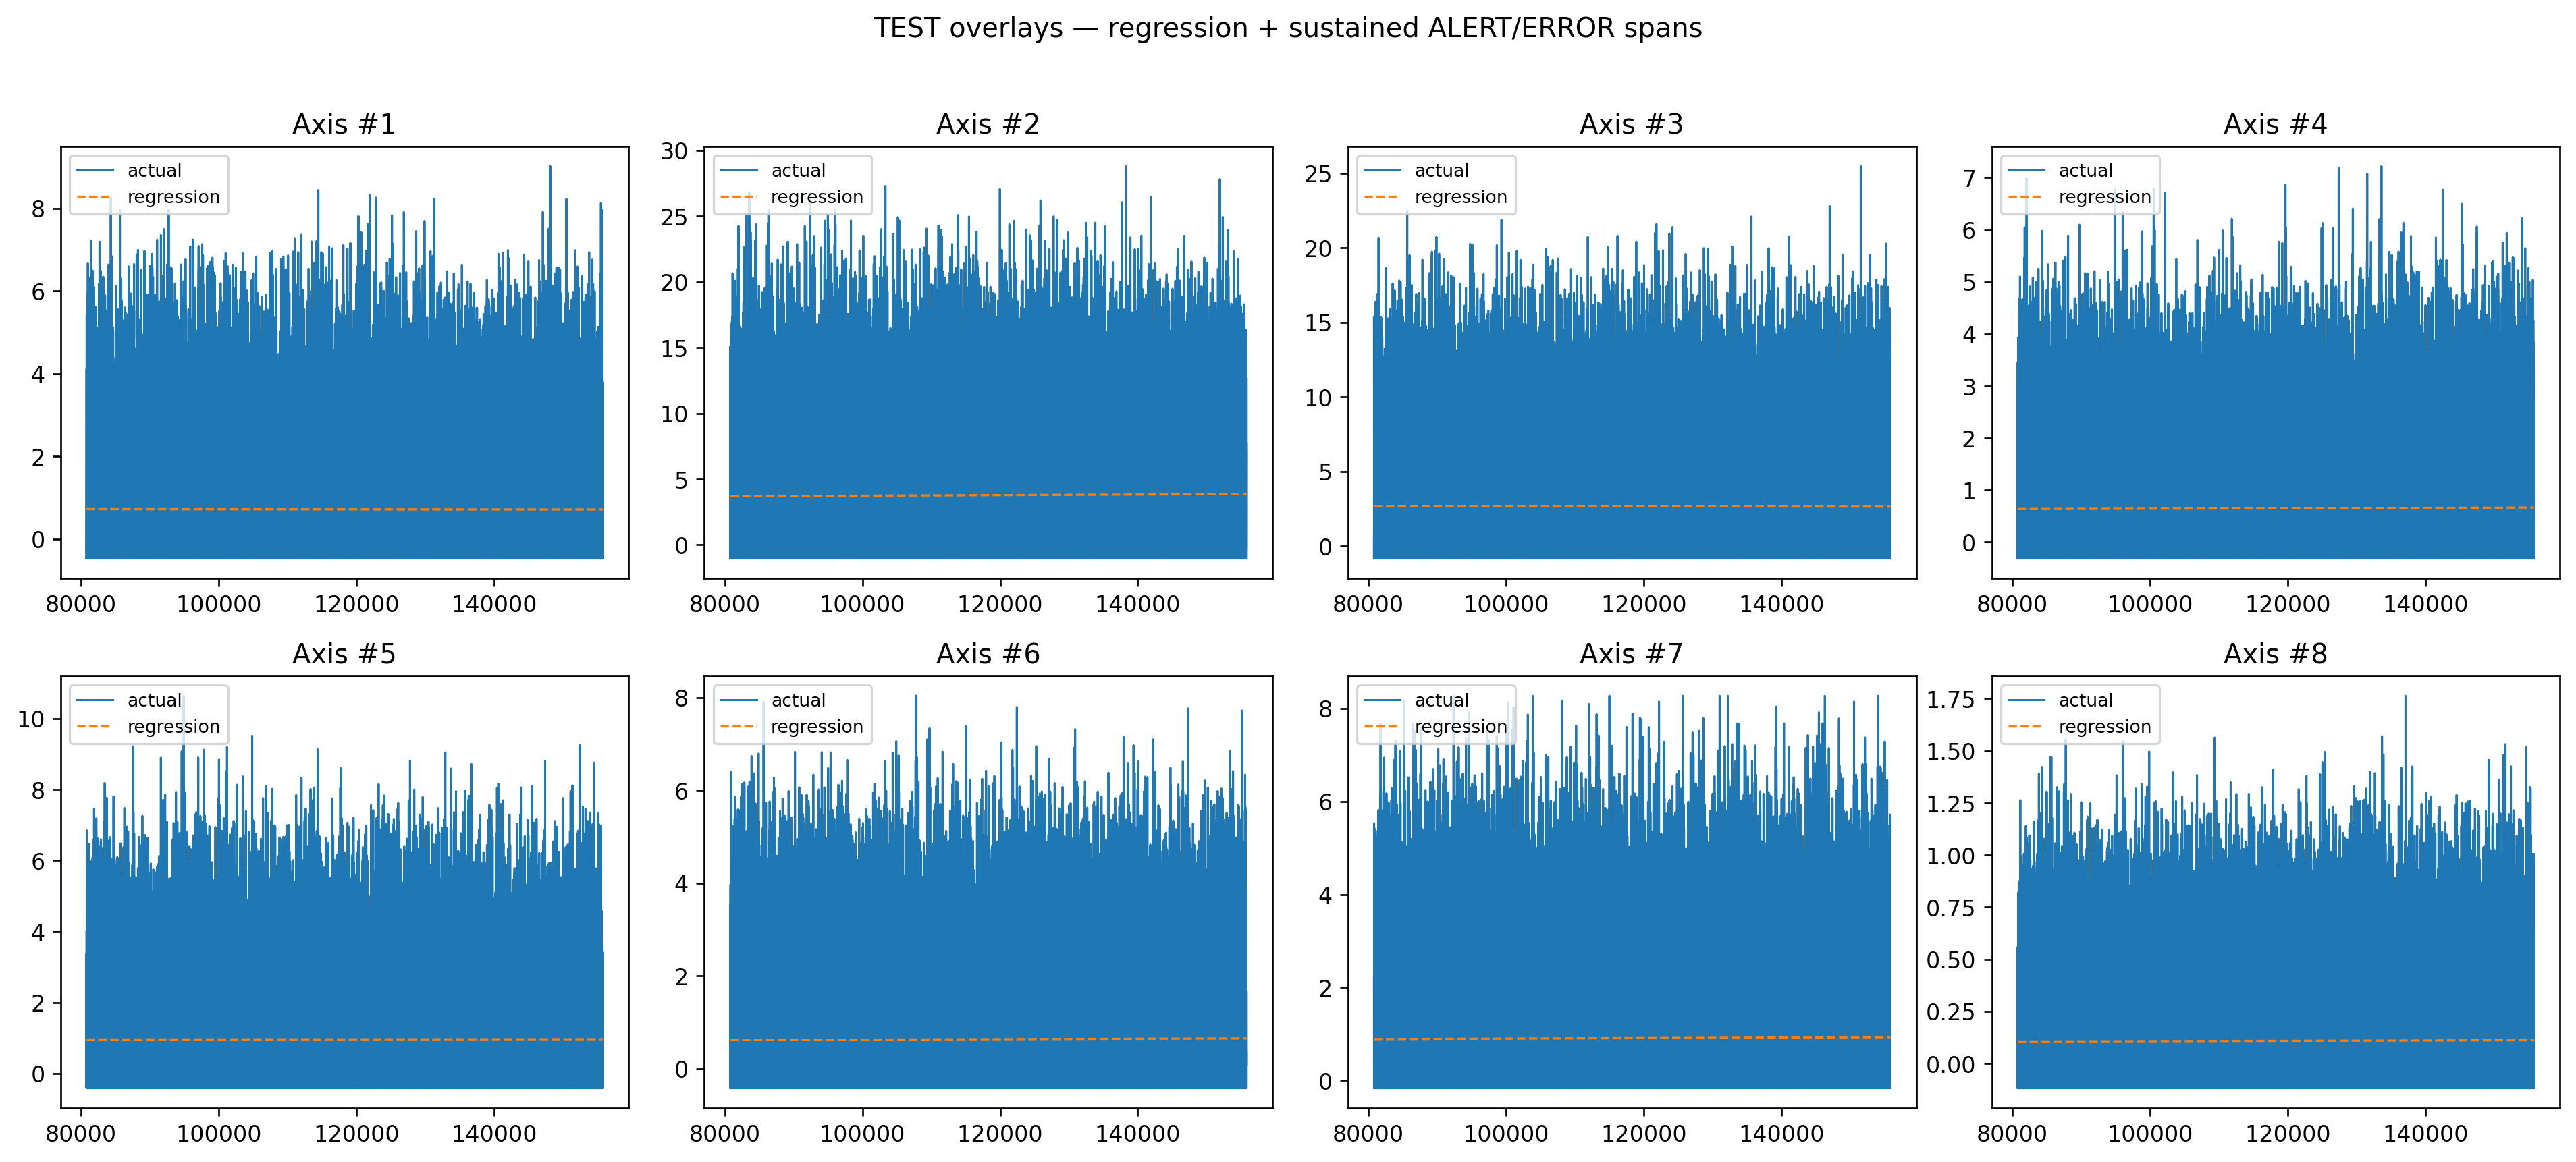

In [462]:
# Cell 7.0 - All-axes overlay grid (2×4) 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

AXES = list(axes_eval)[:8]  # show up to 8
nrows, ncols = 2, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 7), sharex=False)
axs = axs.ravel()

Xte = test[["t_sec"]].to_numpy()

def _shade_from_masks(ax_plot, resid, th_val, label, T):
    ser = pd.Series(resid >= th_val)
    gid = (ser != ser.shift()).cumsum()
    for _, idx in ser.groupby(gid).groups.items():
        if not ser.iloc[idx[0]]:
            continue
        s, e = idx[0], idx[-1]
        dur = float(test["t_sec"].iloc[e] - test["t_sec"].iloc[s])
        if dur >= T:
            ax_plot.axvspan(test["t_sec"].iloc[s], test["t_sec"].iloc[e],
                            alpha=0.20, color=("gold" if label=="ALERT" else "red"))

for i, ax_name in enumerate(AXES):
    axp = axs[i]

    yhat  = models[ax_name].predict(Xte)
    resid = test[ax_name].to_numpy(dtype=float) - yhat
    MinC, MaxC, T = map(float, thresholds.loc[ax_name, ["MinC","MaxC","T"]])

    axp.plot(test["t_sec"], test[ax_name], lw=0.9, label="actual")
    axp.plot(test["t_sec"], yhat, ls="--", lw=1.0, label="regression")

    # Prefer shading from detected events if available; otherwise compute inline
    if 'events_df' in globals() and len(events_df):
        sub = events_df[events_df["axis"] == ax_name]
        for _, r in sub.iterrows():
            axp.axvspan(r["start_time_sec"], r["end_time_sec"],
                        alpha=0.20, color=("red" if r["level"]=="ERROR" else "gold"))
    else:
        _shade_from_masks(axp, resid, MinC, "ALERT", T)
        _shade_from_masks(axp, resid, MaxC, "ERROR", T)

    axp.set_title(ax_name)
    axp.legend(fontsize=8, loc="upper left")

# remove unused panels if fewer than 8 axes
for j in range(len(AXES), nrows*ncols):
    fig.delaxes(axs[j])

fig.suptitle("TEST overlays — regression + sustained ALERT/ERROR spans", y=1.02, fontsize=12)
fig.tight_layout()
plt.show()


In [463]:
# Cell 8.0 — Fit univariate regressions (Time → Axis #1–#8) and show coefs

import numpy as np, pandas as pd
from sklearn.linear_model import LinearRegression
from IPython.display import display

# Preconditions
assert 'train' in globals() and 'axes' in globals(), "Run Cell 0.1 + sanity first."
for col in ["Time","t_sec"]:
    assert col in train.columns, f"TRAIN missing {col}"

# Fit models
models = {}
rows = []
Xtr = train[["t_sec"]].to_numpy()
for ax in axes:
    y = train[ax].to_numpy(dtype=float)
    m = LinearRegression().fit(Xtr, y)
    models[ax] = m
    rows.append({
        "axis": ax,
        "slope": float(m.coef_[0]),
        "intercept": float(m.intercept_),
        "r2_train": float(m.score(Xtr, y)),
    })

coefs = pd.DataFrame(rows).set_index("axis").round(6)
print("✅ Fitted models for axes:", axes)
display(coefs)

# Optional artifact
if 'SAVE_REPORTS' in globals() and SAVE_REPORTS:
    outp = (root / "reports" / "regression_coefs.csv")
    outp.parent.mkdir(parents=True, exist_ok=True)
    coefs.reset_index().to_csv(outp, index=False)
    print("Saved ->", outp)

✅ Fitted models for axes: ['Axis #1', 'Axis #2', 'Axis #3', 'Axis #4', 'Axis #5', 'Axis #6', 'Axis #7', 'Axis #8']


slope  intercept  r2_train
axis                                  
Axis #1 -0.000000   0.730542  0.000002
Axis #2  0.000002   3.523886  0.000054
Axis #3 -0.000001   2.733898  0.000007
Axis #4  0.000000   0.604357  0.000033
Axis #5  0.000000   0.951103  0.000001
Axis #6  0.000000   0.580077  0.000037
Axis #7  0.000001   0.847563  0.000035
Axis #8  0.000000   0.098748  0.000022

In [464]:
# Cell 9.0 — TRAIN residual diagnostics (for threshold justification)

import numpy as np, pandas as pd
from IPython.display import display

assert 'models' in globals(), "Run Cell 4.0 first."

rows = []
for ax in axes:
    yhat = models[ax].predict(train[["t_sec"]].to_numpy())
    resid = train[ax].to_numpy(dtype=float) - yhat
    pos = resid[resid > 0]
    rows.append({
        "axis": ax,
        "resid_mu": float(np.mean(resid)),
        "resid_sd": float(np.std(resid, ddof=1)),
        "pos_count": int((resid > 0).sum()),
        "p95_pos": float(np.percentile(pos, 95)) if pos.size else 0.0,
        "p99_pos": float(np.percentile(pos, 99)) if pos.size else 0.0,
    })

resid_summ = pd.DataFrame(rows).set_index("axis").round(4)
print("✅ TRAIN residual summaries (use these to justify MinC/MaxC):")
display(resid_summ)

if 'SAVE_REPORTS' in globals() and SAVE_REPORTS:
    outp = (root / "reports" / "train_residual_summ.csv")
    outp.parent.mkdir(parents=True, exist_ok=True)
    resid_summ.reset_index().to_csv(outp, index=False)
    print("Saved ->", outp)

✅ TRAIN residual summaries (use these to justify MinC/MaxC):


resid_mu  resid_sd  pos_count  p95_pos  p99_pos
axis                                                    
Axis #1      -0.0    2.1621       6658  11.3438  20.0266
Axis #2       0.0    6.8798      11662  24.5676  39.4509
Axis #3      -0.0    5.1119      12042  19.6594  27.6974
Axis #4      -0.0    1.5749       9397   7.2060  11.7136
Axis #5      -0.0    2.1002       9102   8.5170  14.0363
Axis #6      -0.0    1.8155       8200   9.4692  14.3679
Axis #7       0.0    2.1668       6365   7.2327   7.2473
Axis #8       0.0    0.4231       5924   3.1362   4.0778

In [465]:
# Cell 10.0a — Build thresholds from TRAIN residuals (consume 15.0b if available)
import numpy as np, pandas as pd
from IPython.display import display

assert 'models' in globals(), "Run Cell 4.0 first."

# Prefer thresholds discovered in Cell 15.0b
USE_15B = 'thresholds_out' in globals()

def sustained_runs(mask: pd.Series, t_sec: pd.Series):
    if not mask.any():
        return []
    dt = float(np.median(np.diff(t_sec.values))) if len(t_sec) > 1 else 0.0
    out = []
    gid = (mask != mask.shift()).cumsum()
    for _, idx in mask.groupby(gid).groups.items():
        if not mask.loc[idx].iloc[0]:
            continue
        s, e = idx[0], idx[-1]
        dur = float(t_sec.loc[e] - t_sec.loc[s] + dt)
        out.append((s, e, dur))
    return out

dt_train = float(pd.Series(train["t_sec"]).diff().median()) if len(train) > 1 else 0.0
dt_test  = float(pd.Series(test["t_sec"]).diff().median())  if len(test)  > 1 else dt_train
MIN_T_MULT = 2.0

thr_rows = []

if USE_15B:
    # Use suggestions from 15.0b
    # Choose a single T per axis or keep separate (alert vs error). Most labs want ONE T.
    # Here we pick the more conservative of the two:
    thresholds_out = thresholds_out.copy()
    thresholds_out["T_suggest"] = thresholds_out[["T_alert_suggest","T_error_suggest"]].max(axis=1)

    minc_map = dict(zip(thresholds_out["axis"], thresholds_out["MinC_suggest"]))
    maxc_map = dict(zip(thresholds_out["axis"], thresholds_out["MaxC_suggest"]))
    T_map    = dict(zip(thresholds_out["axis"], thresholds_out["T_suggest"]))

    for ax in axes:
        MinC = float(minc_map.get(ax, 0.0))
        MaxC = float(maxc_map.get(ax, 0.0))
        T    = float(T_map.get(ax, max(MIN_T_MULT * max(dt_train, dt_test), 0.0)))
        thr_rows.append({"axis": ax, "MinC": round(MinC,4), "MaxC": round(MaxC,4), "T": round(T,4)})

    thresholds = pd.DataFrame(thr_rows).set_index("axis")
    thresholds["source"] = "TRAIN (Cell 15.0b suggestions)"

else:
    # Fallback to your previous positive-residual logic
    for ax in axes:
        yhat_tr = models[ax].predict(train[["t_sec"]].to_numpy())
        resid   = pd.Series(train[ax].to_numpy(dtype=float) - yhat_tr, index=train.index)
        pos = resid[resid > 0]
        if pos.size == 0:
            MinC = MaxC = 0.0
            T = MIN_T_MULT * max(dt_train, dt_test)
        else:
            MinC = float(np.percentile(pos, 95))  # ALERT
            MaxC = float(np.percentile(pos, 99))  # ERROR
            runs = sustained_runs(resid >= MinC, train["t_sec"])
            durs = [d for _, _, d in runs]
            T = float(np.percentile(durs, 90)) if durs else 0.0
            T = max(T, MIN_T_MULT * max(dt_train, dt_test))
        thr_rows.append({"axis": ax, "MinC": round(MinC,4), "MaxC": round(MaxC,4), "T": round(T,4)})

    thresholds = pd.DataFrame(thr_rows).set_index("axis")
    thresholds["source"] = "TRAIN (pos 95/99 fallback)"

print("✅ Thresholds ready for detection:")
display(thresholds)
src = thresholds["source"].iloc[0] if len(thresholds) else "n/a"
print(f"ℹ️ Threshold source: {src}")

if 'SAVE_REPORTS' in globals() and SAVE_REPORTS:
    outp = (root / "reports" / "thresholds.csv")
    outp.parent.mkdir(parents=True, exist_ok=True)
    thresholds.to_csv(outp)
    print("Saved ->", outp)

✅ Thresholds ready for detection:


MinC     MaxC      T                          source
axis                                                            
Axis #1  11.3438  20.0266  1.891  TRAIN (Cell 15.0b suggestions)
Axis #2  24.5676  39.4509  1.891  TRAIN (Cell 15.0b suggestions)
Axis #3  19.6594  27.6974  1.891  TRAIN (Cell 15.0b suggestions)
Axis #4   7.2060  11.7136  1.891  TRAIN (Cell 15.0b suggestions)
Axis #5   8.5170  14.0363  1.891  TRAIN (Cell 15.0b suggestions)
Axis #6   9.4692  14.3679  1.891  TRAIN (Cell 15.0b suggestions)
Axis #7   7.2327   7.2473  3.593  TRAIN (Cell 15.0b suggestions)
Axis #8   3.1362   4.0778  1.891  TRAIN (Cell 15.0b suggestions)

ℹ️ Threshold source: TRAIN (Cell 15.0b suggestions)


In [466]:
# CELL 10.0b — Thresholds from TRAIN residuals (Time → Axis #1–#8)

import re, math, numpy as np, pandas as pd
from dataclasses import dataclass

# ---- Detect time column or synthesize index time ----
def _get_time_vector(df: pd.DataFrame):
    # Try common time column names
    for c in ["Time","time","Timestamp","timestamp","Datetime","datetime","ts","_ts_utc"]:
        if c in df.columns:
            try:
                t = pd.to_datetime(df[c], errors="coerce")
                if t.notna().sum() >= 3:
                    # convert to seconds from start
                    return (t - t.iloc[0]).dt.total_seconds().to_numpy()
            except Exception:
                pass
    # Fallback: row index as seconds
    return np.arange(len(df), dtype=float)

# ---- Find Axis columns ----
def _axis_columns(df: pd.DataFrame, max_axes: int = 8):
    pat = re.compile(r"^Axis\s*#?\s*(\d+)", re.I)
    cols = [c for c in df.columns if pat.match(str(c))]
    cols.sort(key=lambda c: int(pat.match(str(c)).group(1)))
    return cols[:max_axes]

AXES_TRAIN = _axis_columns(train, 8)
t_train = _get_time_vector(train)

# ---- Fit univariate linear regressions: y = a + b*t ----
@dataclass
class LinFit:
    a: float  # intercept
    b: float  # slope

fits = {}
residuals = {}

for col in AXES_TRAIN:
    y = pd.to_numeric(train[col], errors="coerce").to_numpy(dtype=float)
    mask = np.isfinite(t_train) & np.isfinite(y)
    x = t_train[mask]
    y = y[mask]
    if len(x) < 3:
        continue
    # Closed-form linear regression via numpy polyfit (degree=1 → slope, intercept)
    b, a = np.polyfit(x, y, 1)
    fits[col] = LinFit(a=float(a), b=float(b))
    yhat = a + b * x
    r = y - yhat
    residuals[col] = r

# ---- Z-score & thresholds from residuals ----
# MinC = moderate outlier (e.g., |z| >= 2.0), MaxC = strong (|z| >= 3.0) by default
# But derive from training residuals' empirical percentiles to be data-driven
thr = {}
for col, r in residuals.items():
    if len(r) < 5:
        continue
    mu = float(np.mean(r))
    sd = float(np.std(r, ddof=1)) if np.std(r, ddof=1) > 0 else 1.0
    # Convert to absolute z
    z = np.abs((r - mu) / sd)
    # Use empirical percentiles (~95th and ~99.7th equivalents)
    minC = float(np.percentile(z, 95))     # approx WARNING/ALERT
    maxC = float(np.percentile(z, 99.7))   # approx ERROR
    # Dwell time T (seconds) as the 95th percentile of consecutive outlier run lengths at minC
    # Compute run lengths where z >= minC
    flags = (z >= minC).astype(int)
    runs = []
    run = 0
    for f in flags:
        if f: run += 1
        elif run: runs.append(run); run = 0
    if run: runs.append(run)
    # Convert run length (in samples) to seconds using training cadence (estimate median dt)
    # Estimate dt from t_train diffs on valid mask for this axis
    # (recompute x to match residuals length)
    y = pd.to_numeric(train[col], errors="coerce").to_numpy(dtype=float)
    mask = np.isfinite(t_train) & np.isfinite(y)
    x = t_train[mask]
    if len(x) >= 2:
        dt = float(np.median(np.diff(x)))
        T = float(np.percentile(runs, 95) * dt) if runs else 4.0  # fallback 4s
    else:
        T = 4.0
    thr[col] = {"mu": mu, "sd": sd, "MinC": minC, "MaxC": maxC, "T": T}

thr_df = pd.DataFrame.from_dict(thr, orient="index")
thr_df.index.name = "axis"
display(thr_df.style.format({"mu":"{:.4f}","sd":"{:.4f}","MinC":"{:.2f}","MaxC":"{:.2f}","T":"{:.2f}"}))

print("✅ Derived thresholds from training residuals (per axis): MinC, MaxC, and dwell time T (sec).")

# Also keep a compact slopes/intercepts table for reference
params_df = pd.DataFrame({
    "axis": list(fits.keys()),
    "intercept": [fits[c].a for c in fits.keys()],
    "slope": [fits[c].b for c in fits.keys()],
}).sort_values("axis")
display(params_df)

✅ Derived thresholds from training residuals (per axis): MinC, MaxC, and dwell time T (sec).


axis  intercept         slope
0  Axis #1   0.730542 -1.176729e-07
1  Axis #2   3.523886  2.194203e-06
2  Axis #3   2.733898 -5.777186e-07
3  Axis #4   0.604357  3.890034e-07
4  Axis #5   0.951103  8.381178e-08
5  Axis #6   0.580077  4.744455e-07
6  Axis #7   0.847563  5.537186e-07
7  Axis #8   0.098748  8.499989e-08

In [467]:
# Cell 10.0c — Convenience dicts for detection
import itertools

MinC_by_axis = thresholds["MinC"].to_dict()
MaxC_by_axis = thresholds["MaxC"].to_dict()
T_by_axis    = thresholds["T"].to_dict()

print("✅ Exported MinC_by_axis, MaxC_by_axis, and T_by_axis for detection.")

✅ Exported MinC_by_axis, MaxC_by_axis, and T_by_axis for detection.


In [468]:
# Cell 10.0d — Are thresholds even triggerable on TEST?
for ax in axes:
    yhat  = models[ax].predict(test[["t_sec"]].to_numpy())
    resid = pd.Series(test[ax].to_numpy(dtype=float) - yhat, index=test.index)
    MinC, MaxC, T = float(thresholds.loc[ax,"MinC"]), float(thresholds.loc[ax,"MaxC"]), float(thresholds.loc[ax,"T"])
    rate = float((resid >= MinC).mean())
    print(f"{ax:8s}  p(resid >= MinC)={rate:6.3%}  T={T:.2f}s  MinC={MinC:.3g}  MaxC={MaxC:.3g}")

Axis #1   p(resid >= MinC)=0.000%  T=1.89s  MinC=11.3  MaxC=20
Axis #2   p(resid >= MinC)=0.003%  T=1.89s  MinC=24.6  MaxC=39.5
Axis #3   p(resid >= MinC)=0.008%  T=1.89s  MinC=19.7  MaxC=27.7
Axis #4   p(resid >= MinC)=0.000%  T=1.89s  MinC=7.21  MaxC=11.7
Axis #5   p(resid >= MinC)=0.005%  T=1.89s  MinC=8.52  MaxC=14
Axis #6   p(resid >= MinC)=0.000%  T=1.89s  MinC=9.47  MaxC=14.4
Axis #7   p(resid >= MinC)=0.025%  T=3.59s  MinC=7.23  MaxC=7.25
Axis #8   p(resid >= MinC)=0.000%  T=1.89s  MinC=3.14  MaxC=4.08


In [469]:
# Cell 10.0e - Quick peek to prove threshold export
list(itertools.islice(MinC_by_axis.items(), 3)), list(itertools.islice(T_by_axis.items(), 3))

([('Axis #1', 11.3438), ('Axis #2', 24.5676), ('Axis #3', 19.6594)],
 [('Axis #1', 1.891), ('Axis #2', 1.891), ('Axis #3', 1.891)])

In [470]:
# Cell 10.0e - (Optional) clear events.csv before re-logging for a clean run
RESET_EVENTS = False
if RESET_EVENTS and EVENTS_CSV.exists():
    EVENTS_CSV.unlink()
    with open(EVENTS_CSV, "w", newline="", encoding="utf-8") as f:
        csv.writer(f).writerow([
            "TimeStart","TimeEnd","Axis","EventType",
            "DurationSec","ResidualMin","ResidualMax","Count"
        ])
    print("🧹 Cleared logs/events.csv for a fresh run.")

In [471]:
# Cell 10.0f - LOG — Event logging helper (CSV persist)
import os, csv, pathlib

LOGS_DIR = pathlib.Path("logs")
LOGS_DIR.mkdir(exist_ok=True)
EVENTS_CSV = LOGS_DIR / "events.csv"

# Ensure header
if not EVENTS_CSV.exists():
    with open(EVENTS_CSV, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow([
            "TimeStart","TimeEnd","Axis","EventType",
            "DurationSec","ResidualMin","ResidualMax","Count"
        ])

def log_events(events_rows):
    """
    Append events to logs/events.csv.
    events_rows: iterable of dicts with keys:
      TimeStart, TimeEnd (timestamps or str),
      Axis (str),
      EventType (str: WARNING/ALERT/ERROR),
      DurationSec (float),
      ResidualMin, ResidualMax (float),
      Count (int).
    """
    rows = list(events_rows)
    if not rows:
        return
    with open(EVENTS_CSV, "a", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        for e in rows:
            w.writerow([
                e["TimeStart"], e["TimeEnd"], e["Axis"], e["EventType"],
                round(float(e["DurationSec"]),3),
                float(e.get("ResidualMin", float("nan"))),
                float(e.get("ResidualMax", float("nan"))),
                int(e.get("Count", 0)),
            ])
    print(f"✅ Appended {len(rows)} rows to {EVENTS_CSV}")


In [472]:
# Cell 10.0g - Quick check that logs landed
if 'EVENTS_CSV' in globals():
    try:
        print("📦", EVENTS_CSV, "rows:", len(pd.read_csv(EVENTS_CSV)))
    except Exception as e:
        print("⚠️ Could not open events log:", e)

📦 logs\events.csv rows: 78


##### Threshold justification is in Cell 15.0b
print("ℹ️ Residual plots and threshold discovery are performed in Cell 15.0b (histograms, boxplots, p95/p99, Tukey, run-length T).")

In [473]:
# Cell 11.0a — Event detection on TEST using TRAIN-based thresholds + CSV logging

import numpy as np, pandas as pd
from IPython.display import display

# Requirements: thresholds & models; optional convenience dicts and logger
assert 'thresholds' in globals() and 'models' in globals(), "Run Cells 4.0 and 10.0 first."
assert 'sustained_runs' in globals(), "sustained_runs() is defined in Cell 10.0."
assert 'log_events' in globals(), "Add Cell 10.LOG before this (event logger)."

# Convenience dicts (use if present, else fall back to thresholds DataFrame)
if 'MinC_by_axis' in globals() and 'MaxC_by_axis' in globals() and 'T_by_axis' in globals():
    get_MinC = lambda ax: float(MinC_by_axis[ax])
    get_MaxC = lambda ax: float(MaxC_by_axis[ax])
    get_T    = lambda ax: float(T_by_axis[ax])
else:
    get_MinC = lambda ax: float(thresholds.loc[ax, "MinC"])
    get_MaxC = lambda ax: float(thresholds.loc[ax, "MaxC"])
    get_T    = lambda ax: float(thresholds.loc[ax, "T"])

EVENT_COLS = [
    "axis","level","start_idx","end_idx",
    "start_time_sec","end_time_sec","duration_sec",
    "max_resid","mean_resid",
]

evt_rows       = []  # for the on-screen DataFrame
events_rows_log = [] # for CSV logger (logs/events.csv)

# Helpers for time fields
has_time_col = "Time" in test.columns
t_series     = test["t_sec"]
time_series  = test["Time"] if has_time_col else None

for ax in axes:
    # Predict and residuals on TEST
    yhat  = models[ax].predict(test[["t_sec"]].to_numpy())
    resid = pd.Series(test[ax].to_numpy(dtype=float) - yhat, index=test.index)

    MinC, MaxC, T = get_MinC(ax), get_MaxC(ax), get_T(ax)

    for level, C in [("ALERT", MinC), ("ERROR", MaxC)]:
        mask = resid >= C
        for s, e, dur in sustained_runs(mask, t_series):
            if dur >= T:
                seg = resid.loc[s:e]

                # Build table row (detailed)
                evt_rows.append({
                    "axis": ax, "level": level,
                    "start_idx": int(s), "end_idx": int(e),
                    "start_time_sec": float(t_series.loc[s]),
                    "end_time_sec": float(t_series.loc[e]),
                    "duration_sec": float(dur),
                    "max_resid": float(seg.max()),
                    "mean_resid": float(seg.mean()),
                })

                # Build CSV log row (lightweight)
                events_rows_log.append({
                    "TimeStart": (time_series.loc[s] if has_time_col else float(t_series.loc[s])),
                    "TimeEnd":   (time_series.loc[e] if has_time_col else float(t_series.loc[e])),
                    "Axis": ax,
                    "EventType": level,
                    "DurationSec": float(dur),
                    "ResidualMin": float(seg.min()),
                    "ResidualMax": float(seg.max()),
                    "Count": int(len(seg)),
                })

# On-screen table (same schema you already had)
events = (pd.DataFrame(evt_rows)
            .reindex(columns=EVENT_COLS)
            .sort_values(["axis","start_idx"])
            .reset_index(drop=True)
         ) if evt_rows else pd.DataFrame(columns=EVENT_COLS)

print(f"Detected {len(events)} events (>=T sustained).")
display(events.head(10))

if events_rows_log:
    log_events(events_rows_log)
else:
    print("ℹ️ No sustained events to log this run.")

# Append lightweight rows to logs/events.csv
log_events(events_rows_log)

# (Optional) also persist the detailed table for inspection without recompute
if 'SAVE_REPORTS' in globals() and SAVE_REPORTS:
    outp_tbl = (root / "logs" / "events_table.csv")
    outp_tbl.parent.mkdir(parents=True, exist_ok=True)
    events.to_csv(outp_tbl, index=False)
    print("Saved detailed table ->", outp_tbl)


Detected 6 events (>=T sustained).


axis  level  start_idx  end_idx  start_time_sec  end_time_sec  \
0  Axis #2  ALERT      30427    30427      138334.316    138334.316   
1  Axis #3  ALERT       2557     2557       85632.146     85632.146   
2  Axis #3  ALERT      35005    35005      146991.314    146991.314   
3  Axis #3  ALERT      37393    37393      151507.022    151507.022   
4  Axis #5  ALERT       7467     7467       94916.956     94916.956   
5  Axis #5  ALERT      12730    12730      104869.289    104869.289   

   duration_sec  max_resid  mean_resid  
0         1.891  24.979185   24.979185  
1         1.891  19.791640   19.791640  
2         1.891  20.146562   20.146562  
3         1.891  22.830785   22.830785  
4         1.891   9.680842    9.680842  
5         1.891   8.556319    8.556319

✅ Appended 6 rows to logs\events.csv
✅ Appended 6 rows to logs\events.csv


In [474]:
events_df = events.copy()

In [475]:
# Cell 11.0b - Lightweight check that logs landed
import pandas as pd
try:
    logs_df = pd.read_csv(EVENTS_CSV)
    print(f"📦 Log rows: {len(logs_df)} (from {EVENTS_CSV})")
    display(logs_df.head(5))
except Exception as e:
    print("⚠️ Could not read logs/events.csv:", e)

📦 Log rows: 90 (from logs\events.csv)


TimeStart                           TimeEnd  \
0  2022-10-19 02:43:57.976000+00:00  2022-10-19 02:43:57.976000+00:00   
1  2022-10-18 12:05:35.806000+00:00  2022-10-18 12:05:35.806000+00:00   
2  2022-10-19 05:08:14.974000+00:00  2022-10-19 05:08:14.974000+00:00   
3  2022-10-19 06:23:30.682000+00:00  2022-10-19 06:23:30.682000+00:00   
4  2022-10-18 14:40:20.616000+00:00  2022-10-18 14:40:20.616000+00:00   

      Axis EventType  DurationSec  ResidualMin  ResidualMax  Count  
0  Axis #2     ALERT        1.891    24.979185    24.979185      1  
1  Axis #3     ALERT        1.891    19.791640    19.791640      1  
2  Axis #3     ALERT        1.891    20.146562    20.146562      1  
3  Axis #3     ALERT        1.891    22.830785    22.830785      1  
4  Axis #5     ALERT        1.891     9.680842     9.680842      1

In [476]:
# Cell 12.0 — Loosen thresholds post-hoc for a demo (optional)
assert 'thresholds' in globals(), "Run Cell 4.0 first."

# Soften amplitude a bit
thresholds["MinC"] = thresholds["MinC"] * 0.85   # 15% easier to trigger ALERT
thresholds["MaxC"] = thresholds["MaxC"] * 0.90   # 10% easier to trigger ERROR

# Cap the duration requirement using cadence
dt_floor = max(
    float(pd.Series(train["t_sec"]).diff().median() or 0.0),
    float(pd.Series(test["t_sec"]).diff().median()  or 0.0),
)
thresholds["T"] = thresholds["T"].clip(upper=2.0 * dt_floor)

display(thresholds.round(3))
print("Post-hoc threshold softening applied (demo mode).")

MinC    MaxC      T                          source
axis                                                          
Axis #1   9.642  18.024  1.891  TRAIN (Cell 15.0b suggestions)
Axis #2  20.882  35.506  1.891  TRAIN (Cell 15.0b suggestions)
Axis #3  16.710  24.928  1.891  TRAIN (Cell 15.0b suggestions)
Axis #4   6.125  10.542  1.891  TRAIN (Cell 15.0b suggestions)
Axis #5   7.239  12.633  1.891  TRAIN (Cell 15.0b suggestions)
Axis #6   8.049  12.931  1.891  TRAIN (Cell 15.0b suggestions)
Axis #7   6.148   6.523  3.593  TRAIN (Cell 15.0b suggestions)
Axis #8   2.666   3.670  1.891  TRAIN (Cell 15.0b suggestions)

Post-hoc threshold softening applied (demo mode).


In [477]:
# Cell 13.0a — OPTIONAL: train/test time split to avoid leakage
USE_TIME_SPLIT = False   # <- keep False for the current assignment

if USE_TIME_SPLIT:
    SPLIT_FRAC = 0.70  # 70% train, 30% test
    full = train.sort_values("Time").reset_index(drop=True)
    split_idx = int(len(full) * SPLIT_FRAC)

    train = full.iloc[:split_idx].copy()
    test  = full.iloc[split_idx:].copy()

    # Re-anchor seconds to start of the TRAIN window
    t0 = train["Time"].iloc[0]
    train["t_sec"] = (train["Time"] - t0).dt.total_seconds()
    test["t_sec"]  = (test["Time"]  - t0).dt.total_seconds()

    print(f"Time split -> train:{len(train)}  test:{len(test)}  (t0 = {t0})")
else:
    print("USE_TIME_SPLIT=False → Using external metadata CSV as test (default).")

USE_TIME_SPLIT=False → Using external metadata CSV as test (default).


In [478]:
# Cell 13.0b — Time leakage sanity check (warn-only)

ENFORCE_NO_OVERLAP = False  # set True only if you REQUIRE disjoint windows

tmin_tr, tmax_tr = train["Time"].min(), train["Time"].max()
tmin_te, tmax_te =  test["Time"].min(),  test["Time"].max()
print("Train time range:", tmin_tr, "→", tmax_tr)
print("Test  time range:", tmin_te, "→", tmax_te)

# overlap exists unless one window ends strictly before the other starts
overlap = not (tmax_tr < tmin_te or tmax_te < tmin_tr)

if overlap:
    msg = "⚠️ Overlap detected between train and test windows."
    if ENFORCE_NO_OVERLAP:
        raise AssertionError("Time leakage: train overlaps test!")
    else:
        print(msg, "Proceeding (lab allows overlap).")
else:
    print("No leakage ✓ (disjoint windows)")

Train time range: 2022-10-17 12:18:23.660000+00:00 → 2022-10-18 10:44:58.628000+00:00
Test  time range: 2022-10-18 10:45:00.519000+00:00 → 2022-10-19 07:35:18.380000+00:00
No leakage ✓ (disjoint windows)


In [479]:
# Cell 14.0 - OPTIONAL — add predictions/residuals to TEST without refitting or dropping rows
import numpy as np
import pandas as pd

assert 'models' in globals() and 'axes' in globals(), "Run Cell 4.0 first."

preds = {}
for ax in axes:
    yhat = models[ax].predict(test[["t_sec"]].to_numpy())
    preds[f"pred_{ax}"]  = yhat
    preds[f"resid_{ax}"] = test[ax].astype(float).to_numpy() - yhat

test = pd.concat([test, pd.DataFrame(preds, index=test.index)], axis=1)
print("✅ Added pred_* and resid_* columns to TEST (no refit, no drops).")

✅ Added pred_* and resid_* columns to TEST (no refit, no drops).


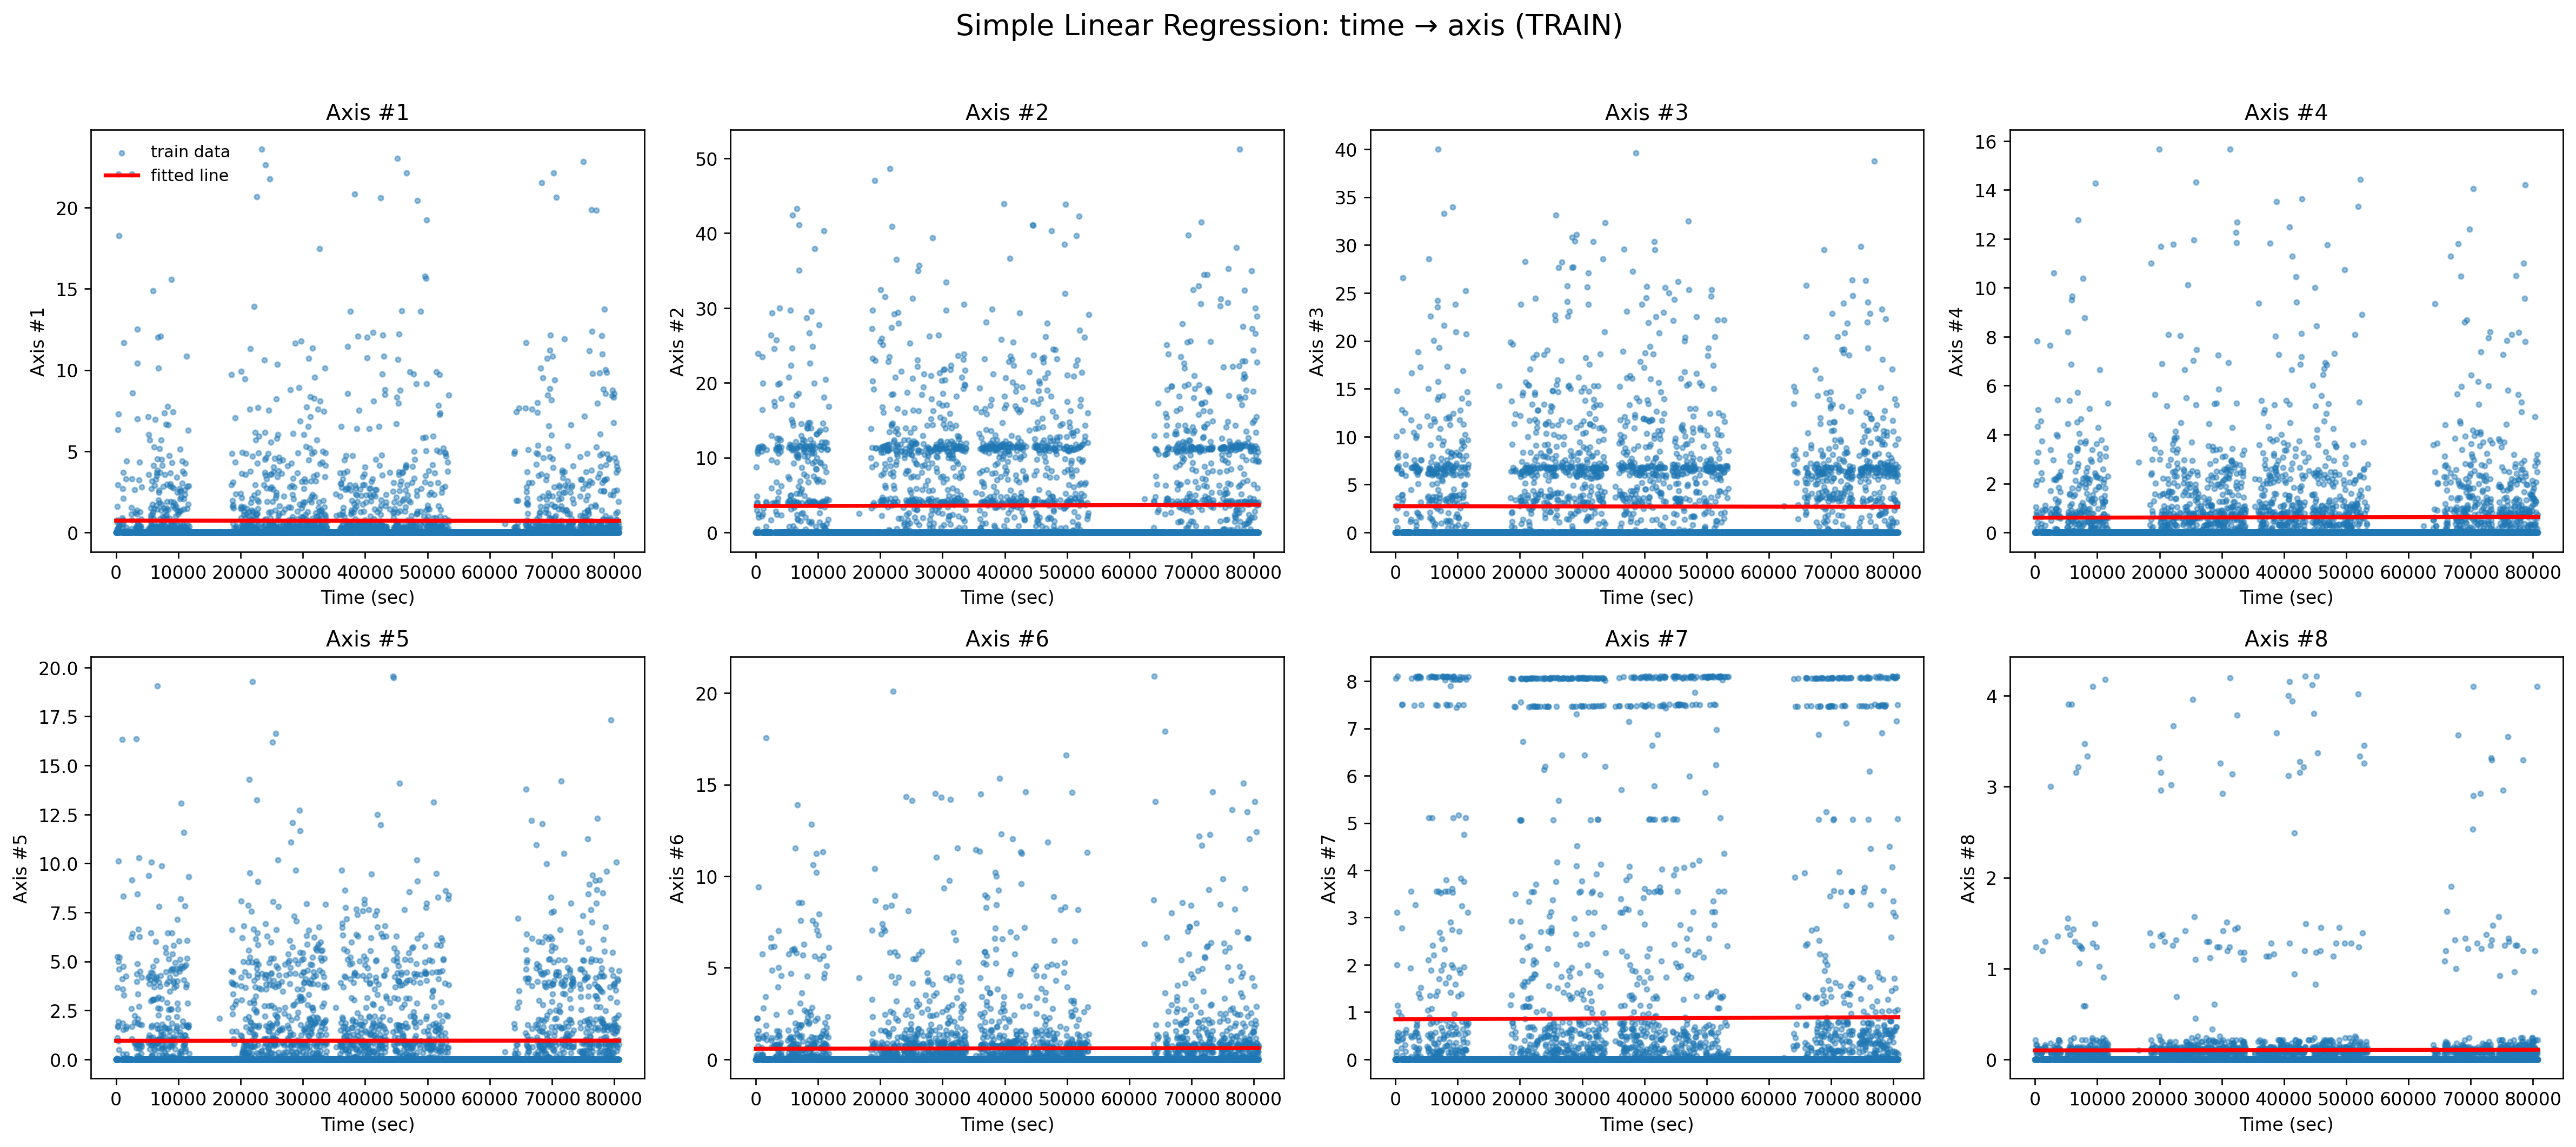

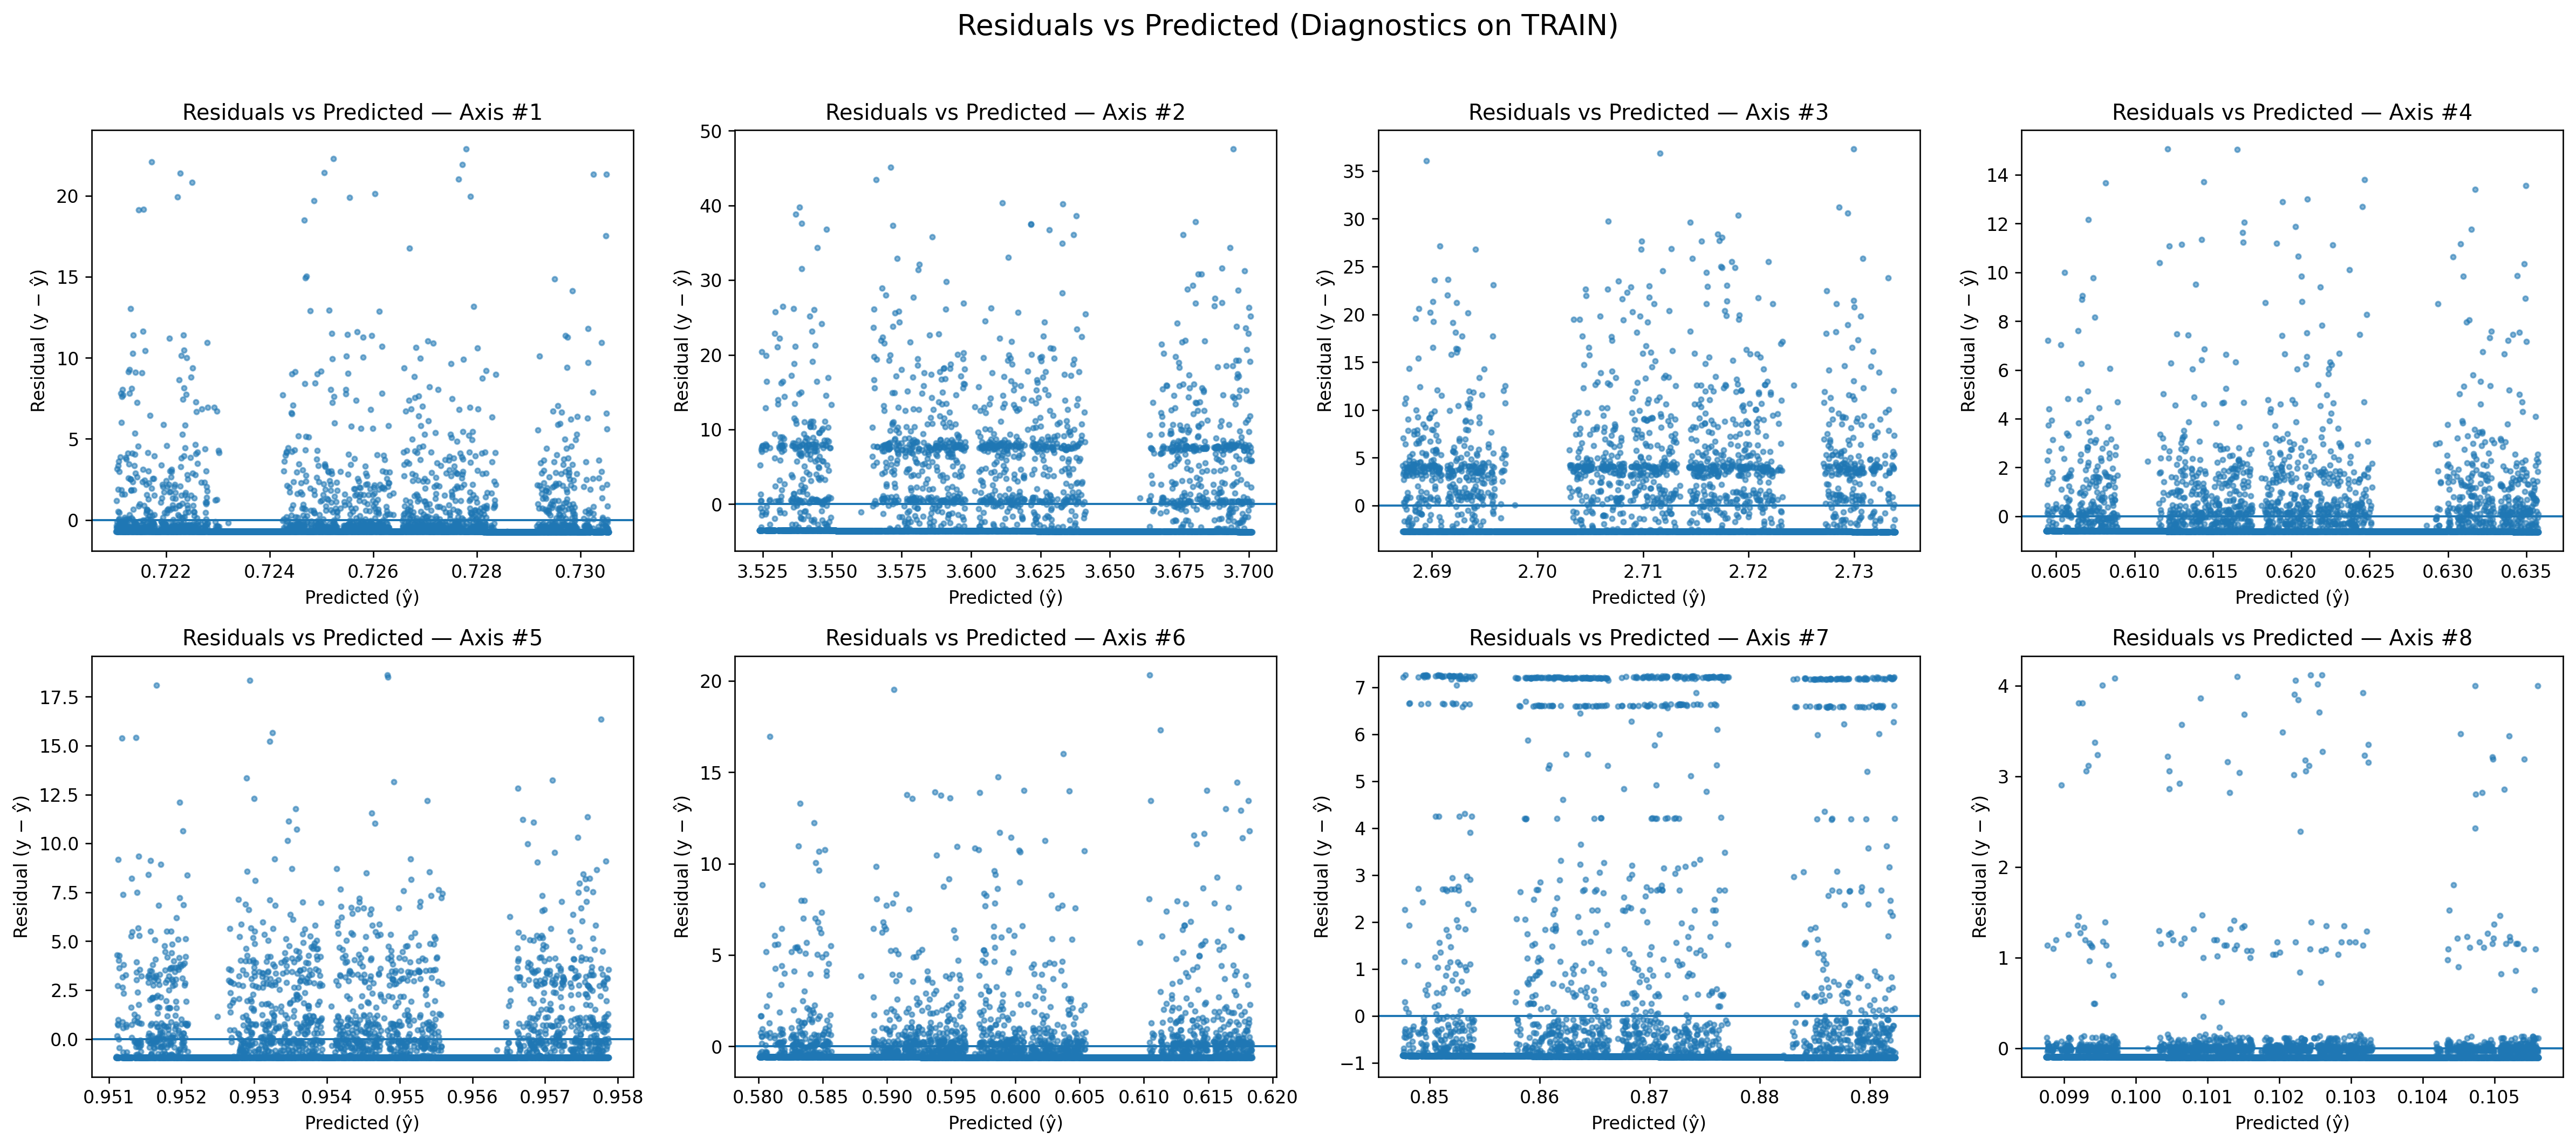

In [480]:
# Cell 15.0a — Regression diagnostics on TRAIN in 2×4 grids (self-heals t_sec)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# ---- ensure t_sec exists on TRAIN (build from timestamps / numeric time / inferred cadence) ----
def _ensure_t_sec(df: pd.DataFrame, ref: pd.DataFrame | None = None, default_step: float = 1.0) -> pd.DataFrame:
    if "t_sec" in df.columns and np.isfinite(df["t_sec"]).any():
        return df

    # 1) Timestamp-like columns
    for col in ["Time", "time", "Timestamp", "timestamp", "DATETIME", "datetime"]:
        if col in df.columns:
            dt = pd.to_datetime(df[col], errors="coerce")
            if dt.notna().sum() > 1:
                base = dt.iloc[0]
                df["t_sec"] = (dt - base).dt.total_seconds()
                return df

    # 2) Numeric time-like columns
    for col in ["t", "secs", "seconds"]:
        if col in df.columns and np.issubdtype(df[col].dtype, np.number):
            v = df[col].to_numpy()
            df["t_sec"] = v - v[0]
            return df

    # 3) Infer step from reference (usually TEST has t_sec)
    if ref is not None and "t_sec" in ref.columns and len(ref) > 2:
        step = float(np.median(np.diff(ref["t_sec"].to_numpy())))
    else:
        step = float(default_step)

    df["t_sec"] = np.arange(len(df), dtype=float) * step
    return df

# Build t_sec on TRAIN using TEST as cadence hint if present
train = _ensure_t_sec(train, ref=globals().get("test", None))

# ---- axis detection fallback (from TRAIN) ----
if "axes" not in globals() or not all(ax in train.columns for ax in axes[:8]):
    axes = [c for c in train.columns if c.lower().startswith("axis")][:8]
    assert len(axes) >= 1, "Could not find any 'Axis*' columns in TRAIN."

# --- guards ---
assert "t_sec" in train.columns, "Expected 't_sec' column in TRAIN."
for _ax in axes[:8]:
    assert _ax in train.columns, f"Axis column '{_ax}' not found in TRAIN."

fig_dir = root / "reports" / "figures" / "regression_diag"
if SAVE_FIGS or SAVE_REPORTS:
    fig_dir.mkdir(parents=True, exist_ok=True)

pdf_path = root / "reports" / "Regression_Diagnostics_All_Axes.pdf"
pdf = PdfPages(pdf_path) if SAVE_REPORTS else None

def _safe_name(s: str) -> str:
    return s.replace("#", "num").replace(" ", "_")

# ========== Grid 1: scatter vs time + red fitted line (TRAIN) ==========
fig1, axs1 = plt.subplots(2, 4, figsize=(20, 9), sharex=False, sharey=False)
axs1 = axs1.ravel()

for i, ax_name in enumerate(axes[:8]):
    axp = axs1[i]
    m = models[ax_name]

    t    = train["t_sec"].to_numpy()
    y    = train[ax_name].to_numpy()
    yhat = m.predict(train[["t_sec"]].to_numpy())

    # subsample for clarity on huge series
    order = np.argsort(t)
    step  = max(1, len(t) // 4000)   # keep ~4k points
    idx   = np.arange(len(t))[::step]

    axp.scatter(t[idx], y[idx], s=7, alpha=0.45, label="train data")
    axp.plot(t[order], yhat[order], "r-", linewidth=2.2, label="fitted line")
    axp.set_xlabel("Time (sec)")
    axp.set_ylabel(ax_name)
    axp.set_title(f"{ax_name}", fontsize=12)

axs1[0].legend(loc="upper left", fontsize=9, frameon=False)
fig1.suptitle("Simple Linear Regression: time → axis (TRAIN)", fontsize=16)
fig1.tight_layout(rect=[0, 0, 1, 0.96])

if SAVE_FIGS:
    maybe_savefig(fig_dir / "grid_fits_2x4_TRAIN.png")
if pdf is not None:
    pdf.savefig(fig1)
plt.show()
plt.close(fig1)

# ========== Grid 2: residuals vs predicted (TRAIN) ==========
fig2, axs2 = plt.subplots(2, 4, figsize=(20, 9), sharex=False, sharey=False)
axs2 = axs2.ravel()

for i, ax_name in enumerate(axes[:8]):
    axp = axs2[i]
    m = models[ax_name]

    y    = train[ax_name].to_numpy()
    yhat = m.predict(train[["t_sec"]].to_numpy())
    resid = y - yhat

    step  = max(1, len(yhat) // 4000)
    idx   = np.arange(len(yhat))[::step]

    axp.scatter(yhat[idx], resid[idx], s=7, alpha=0.55)
    axp.axhline(0, linewidth=1.2)
    axp.set_xlabel("Predicted (ŷ)")
    axp.set_ylabel("Residual (y − ŷ)")
    axp.set_title(f"Residuals vs Predicted — {ax_name}", fontsize=12)

fig2.suptitle("Residuals vs Predicted (Diagnostics on TRAIN)", fontsize=16)
fig2.tight_layout(rect=[0, 0, 1, 0.96])

if SAVE_FIGS:
    maybe_savefig(fig_dir / "grid_residuals_2x4_TRAIN.png")
if pdf is not None:
    pdf.savefig(fig2)
plt.show()
plt.close(fig2)

# Close PDF if used
if pdf is not None:
    pdf.close()

# Messages only if saving
if SAVE_FIGS:
    print("Saved 2×4 TRAIN grid images →", fig_dir)
if SAVE_REPORTS:
    print("Also wrote a multi-page PDF →", pdf_path)

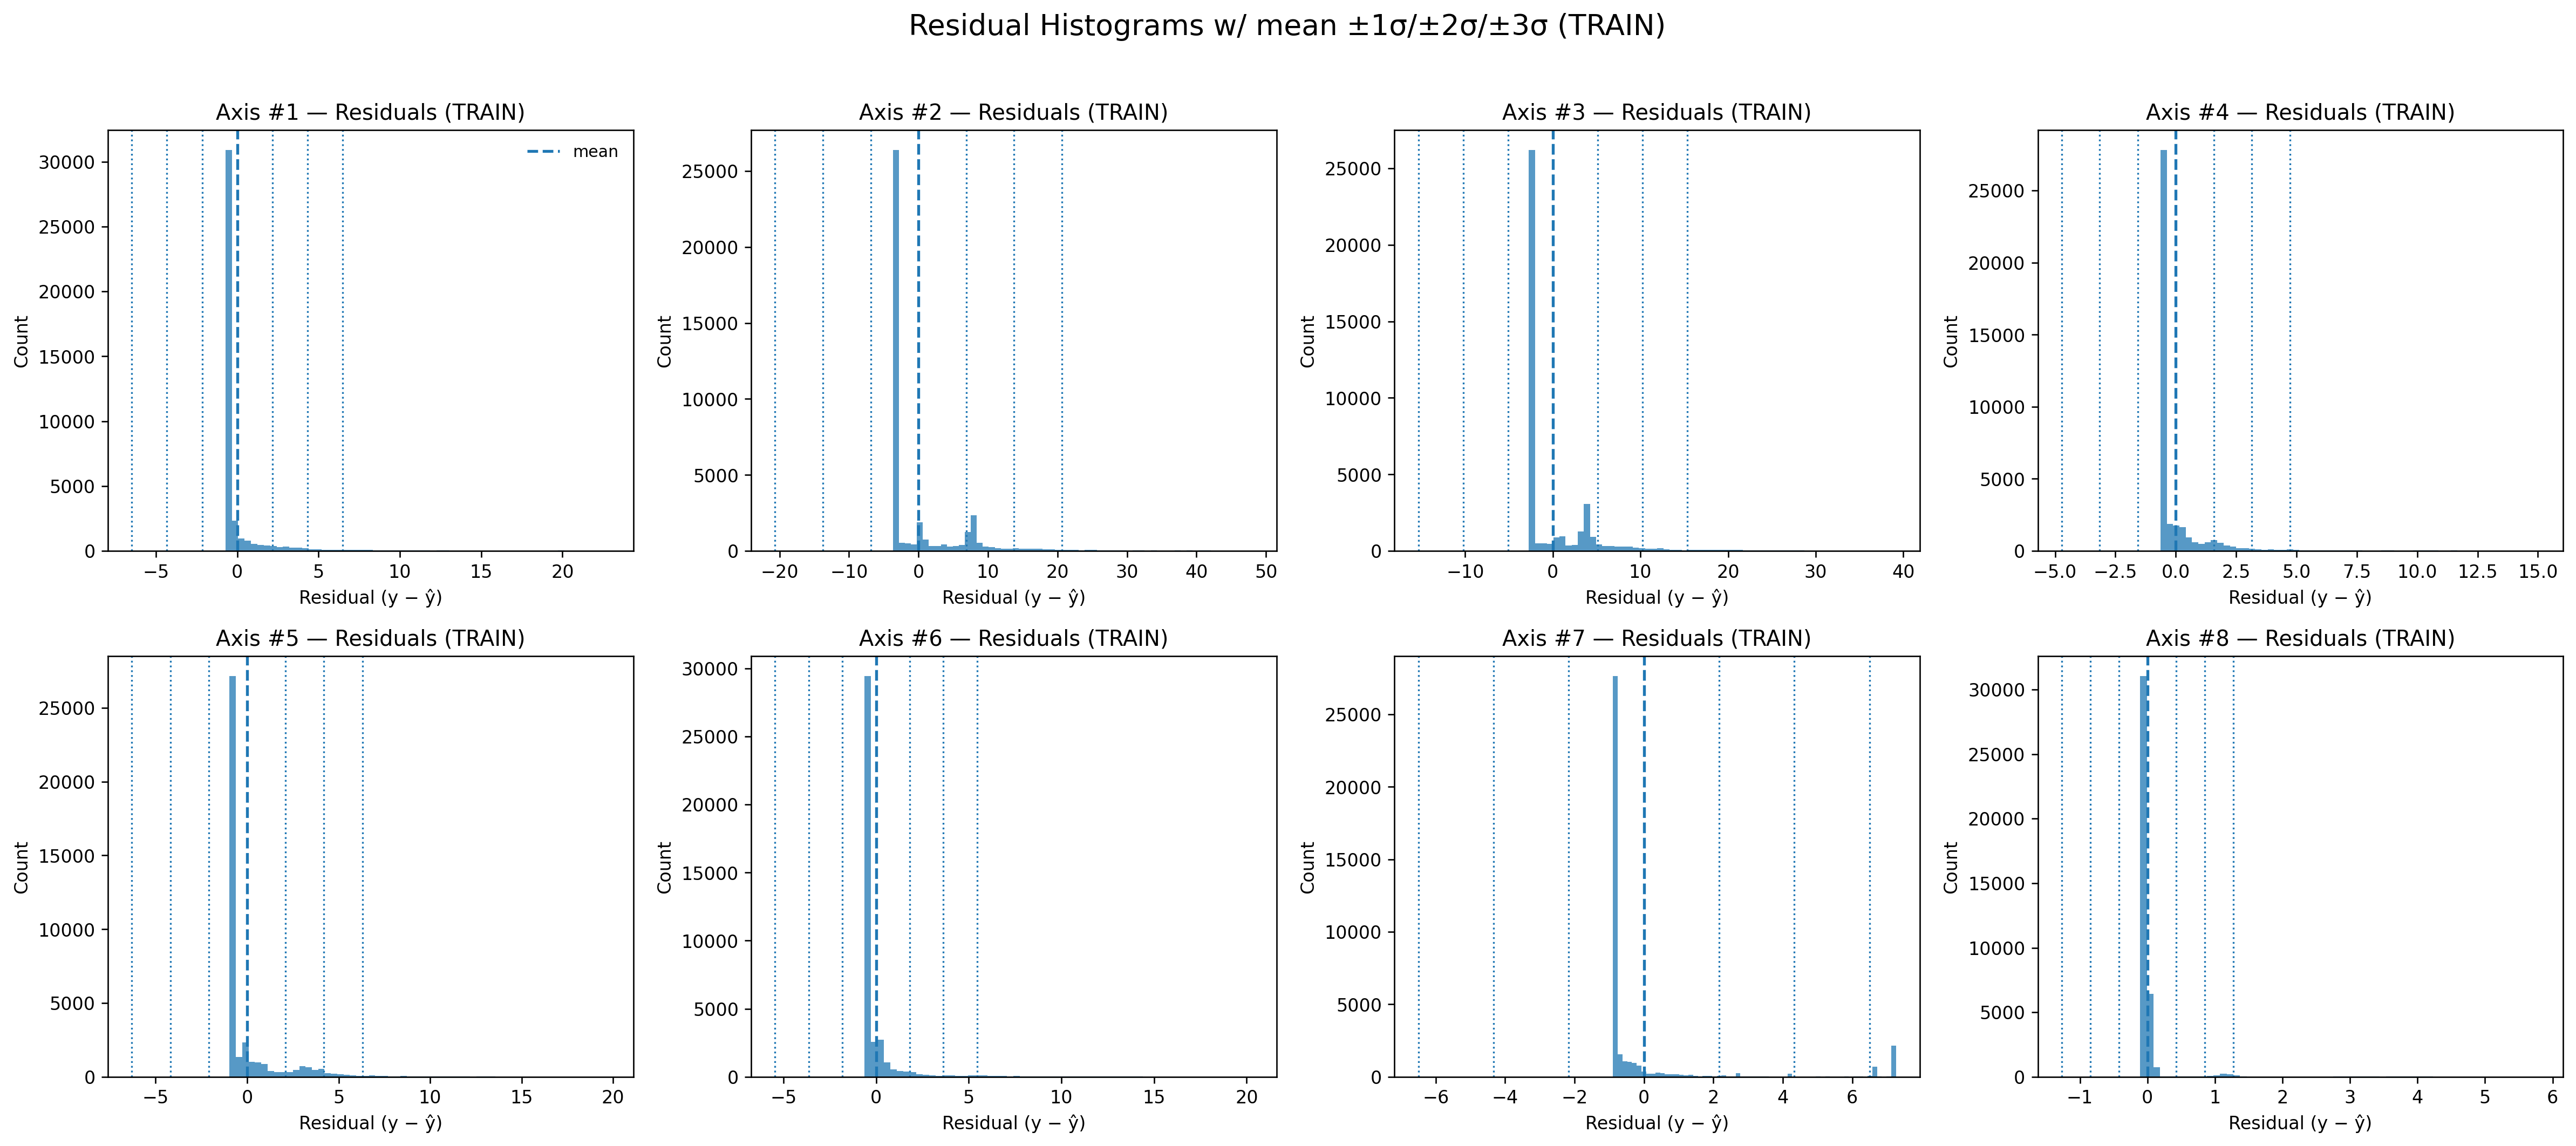

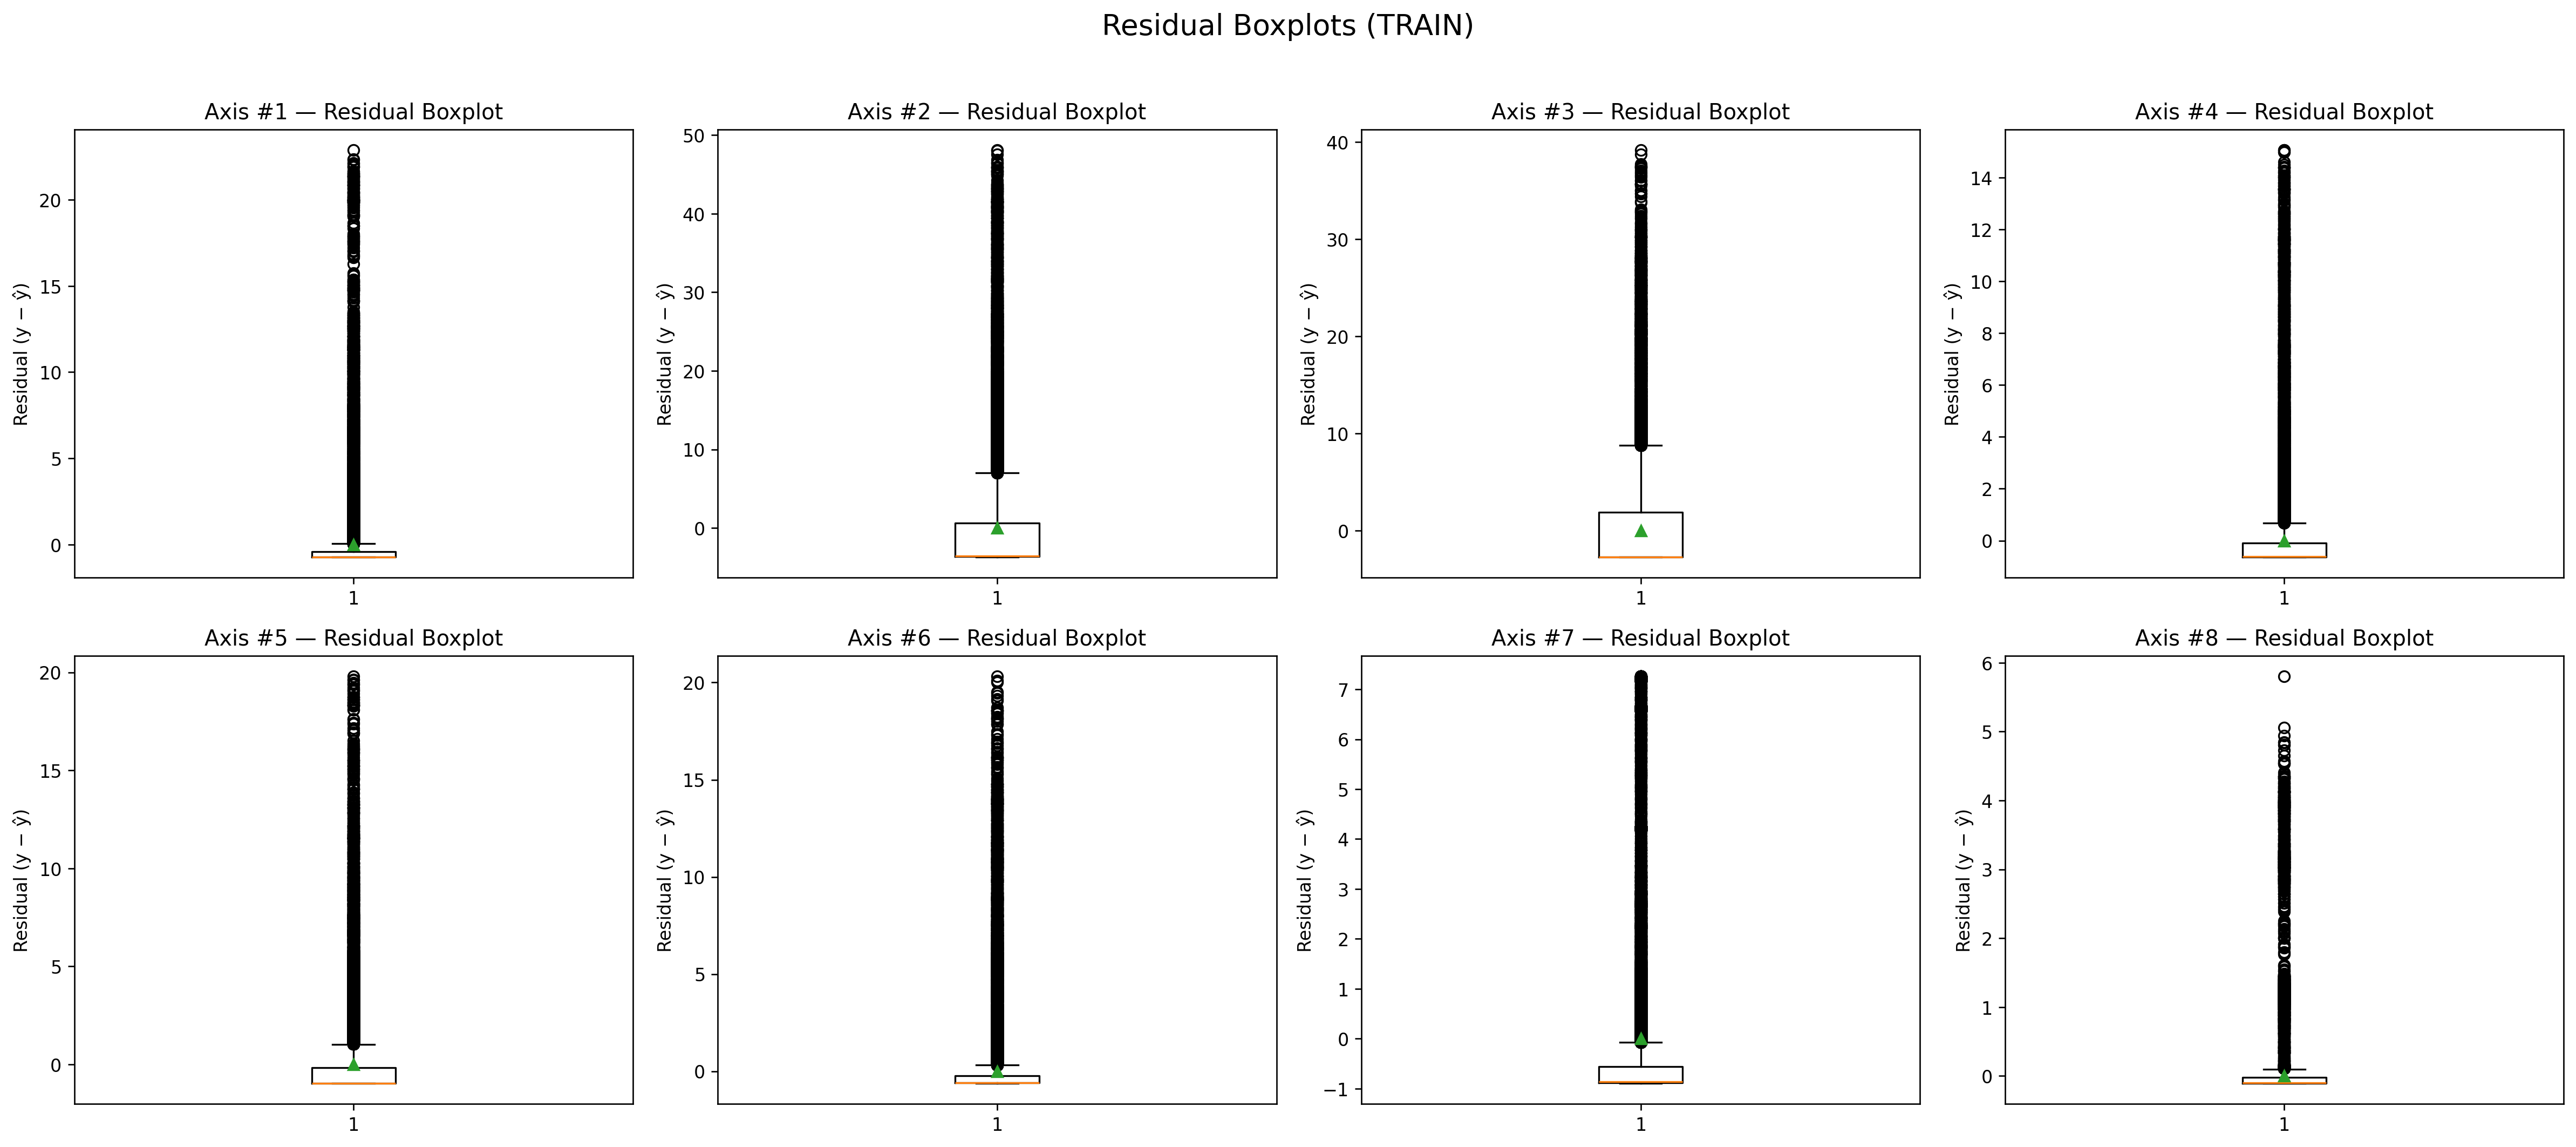


Suggested thresholds (TRAIN-based):


axis  MinC_suggest  MaxC_suggest  T_alert_suggest  T_error_suggest  \
0  Axis #1       11.3438       20.0266            1.891            1.891   
1  Axis #2       24.5676       39.4509            1.891            1.891   
2  Axis #3       19.6594       27.6974            1.891            1.891   
3  Axis #4        7.2060       11.7136            1.891            1.891   
4  Axis #5        8.5170       14.0363            1.891            1.891   
5  Axis #6        9.4692       14.3679            1.891            1.891   
6  Axis #7        7.2327        7.2473            3.593            2.458   
7  Axis #8        3.1362        4.0778            1.891            1.891   

          σ    p95_pos    p99_pos  Upper_Tukey  flag_rate_at_MinC  \
0  2.162118  11.343826  20.026619     0.051874             0.0084   
1  6.879775  24.567595  39.450935     7.041595             0.0147   
2  5.111883  19.659364  27.697359     8.756844             0.0152   
3  1.574871   7.206002  11.713580     0.685873             0.0118   
4  2.100185   8.516996  14.036251     1.054121             0.0115   
5  1.815465   9.469247  14.367856     0.335778             0.0103   
6  2.166773   7.232741   7.247293    -0.069933             0.0082   
7  0.423071   3.136179   4.077765     0.097489             0.0075   

   flag_rate_at_MaxC  
0             0.0017  
1             0.0029  
2             0.0031  
3             0.0024  
4             0.0023  
5             0.0021  
6             0.0016  
7             0.0015

In [481]:
# Cell 15.0b — Residuals Analysis + Threshold Discovery (TRAIN)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Ensure time column
train = _ensure_t_sec(train, ref=globals().get("test", None))

# ---------- Compute residuals per axis on TRAIN ----------
resid_df = pd.DataFrame(index=train.index)
for ax_name in axes[:8]:
    y    = train[ax_name].to_numpy()
    yhat = models[ax_name].predict(train[["t_sec"]].to_numpy())
    resid_df[ax_name] = y - yhat

# ---------- FIG A: Histograms (2x4) with ±σ guides ----------
fig_dir = root / "reports" / "figures" / "residuals"
if SAVE_FIGS or SAVE_REPORTS:
    fig_dir.mkdir(parents=True, exist_ok=True)

pdf_path = root / "reports" / "Residuals_Analysis.pdf"
pdf = PdfPages(pdf_path) if SAVE_REPORTS else None

figA, axsA = plt.subplots(2, 4, figsize=(20, 9), sharex=False, sharey=False)
axsA = axsA.ravel()

for i, ax_name in enumerate(axes[:8]):
    axp = axsA[i]
    r = resid_df[ax_name].dropna().to_numpy()
    mu = float(np.mean(r)); sd = float(np.std(r, ddof=1))

    axp.hist(r, bins=60, alpha=0.75)
    # mean + std guides
    axp.axvline(mu, linewidth=1.6, linestyle="--", label="mean")
    for k, lw in [(1,1.0),(2,1.0),(3,1.0)]:
        axp.axvline(mu + k*sd, linewidth=1.0, linestyle=":")
        axp.axvline(mu - k*sd, linewidth=1.0, linestyle=":")

    axp.set_title(f"{ax_name} — Residuals (TRAIN)", fontsize=12)
    axp.set_xlabel("Residual (y − ŷ)")
    axp.set_ylabel("Count")

axsA[0].legend(frameon=False, fontsize=9)
figA.suptitle("Residual Histograms w/ mean ±1σ/±2σ/±3σ (TRAIN)", fontsize=16)
figA.tight_layout(rect=[0,0,1,0.96])

if SAVE_FIGS: maybe_savefig(fig_dir / "residual_hist_2x4_TRAIN.png")
if pdf is not None: pdf.savefig(figA)
plt.show(); plt.close(figA)

# ---------- FIG B: Boxplots (2x4) ----------
figB, axsB = plt.subplots(2, 4, figsize=(20, 9), sharex=False, sharey=False)
axsB = axsB.ravel()

for i, ax_name in enumerate(axes[:8]):
    axp = axsB[i]
    r = resid_df[ax_name].dropna().to_numpy()
    axp.boxplot(r, vert=True, showmeans=True)
    axp.set_title(f"{ax_name} — Residual Boxplot", fontsize=12)
    axp.set_ylabel("Residual (y − ŷ)")

figB.suptitle("Residual Boxplots (TRAIN)", fontsize=16)
figB.tight_layout(rect=[0,0,1,0.96])

if SAVE_FIGS: maybe_savefig(fig_dir / "residual_box_2x4_TRAIN.png")
if pdf is not None: pdf.savefig(figB)
plt.show(); plt.close(figB)

# ---------- Threshold suggestions (right-tail only) ----------
# We care about deviations ABOVE the regression line (positive residuals)
rows = []
for ax_name in axes[:8]:
    r_all = resid_df[ax_name].dropna().to_numpy()
    r_pos = r_all[r_all > 0]
    if len(r_pos) == 0:
        p95 = p99 = 0.0
    else:
        p95 = float(np.percentile(r_pos, 95))
        p99 = float(np.percentile(r_pos, 99))

    mu   = float(np.mean(r_all))
    sd   = float(np.std(r_all, ddof=1))
    q1   = float(np.percentile(r_all, 25))
    med  = float(np.percentile(r_all, 50))
    q3   = float(np.percentile(r_all, 75))
    iqr  = q3 - q1
    upper_tukey = q3 + 1.5*iqr  # right-tail fence

    # Suggested thresholds:
    # - MinC: conservative alert threshold near rare-but-not-extreme tail
    # - MaxC: error threshold for truly extreme right-tail values
    MinC = round(max(p95, 2*sd), 4)
    MaxC = round(max(p99, 3*sd, upper_tukey), 4)

    # Share how often we'd have flagged in TRAIN (for sanity)
    rate_MinC = float((r_all >= MinC).mean())
    rate_MaxC = float((r_all >= MaxC).mean())

    rows.append({
        "axis": ax_name,
        "μ": round(mu, 6),
        "σ": round(sd, 6),
        "Q1": round(q1, 6),
        "Median": round(med, 6),
        "Q3": round(q3, 6),
        "IQR": round(iqr, 6),
        "p95_pos": round(p95, 6),
        "p99_pos": round(p99, 6),
        "Upper_Tukey": round(upper_tukey, 6),
        "MinC_suggest": MinC,
        "MaxC_suggest": MaxC,
        "flag_rate_at_MinC": round(rate_MinC, 4),
        "flag_rate_at_MaxC": round(rate_MaxC, 4),
    })

thresh_df = pd.DataFrame(rows)

# ---------- Suggest T (seconds) using run-lengths on TRAIN ----------
# Compute sampling step (median dt)
t = train["t_sec"].to_numpy()
if len(t) > 1:
    dt = float(np.median(np.diff(t)))
else:
    dt = 1.0

def run_lengths(mask: np.ndarray) -> np.ndarray:
    """Return contiguous True-run lengths (in samples)."""
    if mask.size == 0: return np.array([], dtype=int)
    # Find change points
    change = np.diff(mask.astype(int))
    starts = np.where(change == 1)[0] + 1
    stops  = np.where(change == -1)[0] + 1
    # Edge cases
    if mask[0]:  starts = np.r_[0, starts]
    if mask[-1]: stops  = np.r_[stops, mask.size]
    return (stops - starts).astype(int)

T_rows = []
for i, ax_name in enumerate(axes[:8]):
    MinC = thresh_df.loc[i, "MinC_suggest"]
    MaxC = thresh_df.loc[i, "MaxC_suggest"]
    r = resid_df[ax_name].to_numpy()

    rl_alert = run_lengths(r >= MinC)
    rl_error = run_lengths(r >= MaxC)

    # Suggest T as a high percentile of natural spikes to avoid noise
    T_alert_sec = round((np.percentile(rl_alert, 90) if rl_alert.size else 5) * dt, 3)
    T_error_sec = round((np.percentile(rl_error, 90) if rl_error.size else 5) * dt, 3)

    T_rows.append({"axis": ax_name, "T_alert_suggest": T_alert_sec, "T_error_suggest": T_error_sec})

T_df = pd.DataFrame(T_rows)

# ---------- Combine & save ----------
thresholds_out = thresh_df.merge(T_df, on="axis", how="left")

if SAVE_REPORTS:
    out_csv = root / "reports" / "thresholds_suggestions.csv"
    out_csv.parent.mkdir(parents=True, exist_ok=True)
    thresholds_out.to_csv(out_csv, index=False)
    print("Wrote thresholds suggestions →", out_csv)

# Show a compact view
display_cols = ["axis","MinC_suggest","MaxC_suggest","T_alert_suggest","T_error_suggest",
                "σ","p95_pos","p99_pos","Upper_Tukey","flag_rate_at_MinC","flag_rate_at_MaxC"]
print("\nSuggested thresholds (TRAIN-based):")
display(thresholds_out[display_cols].reset_index(drop=True))

if pdf is not None:
    pdf.close()
    print("Also wrote Residuals_Analysis.pdf →", pdf_path)

***Threshold rationale (TRAIN residuals)***. We justify alert/error thresholds per axis from the empirical residual distribution. We visualize the residuals with 2×4 histograms (mean ±1σ/±2σ/±3σ) and 2×4 boxplots, compute right-tail percentiles (p95, p99), robust spread (IQR, Tukey upper fence), and z-score exceedance rates. We set MinC to a conservative alert threshold (max of p95 and 2σ) and MaxC for truly extreme values (max of p99, 3σ, and Tukey fence). To avoid flicker, we set T using the 90th percentile of contiguous exceedance run lengths (cadence-aware). The “Suggested thresholds (TRAIN-based)” table summarizes the chosen MinC/MaxC/T with expected false-positive rates measured on TRAIN.

In [482]:
# Cell 16.0 — Thresholds from TRAIN (cadence-aware; per-axis, with provenance)

import numpy as np
import pandas as pd

# --- ensure t_sec exists on both TRAIN and TEST (safe if already present) ---
def _ensure_t_sec(df: pd.DataFrame, ref: pd.DataFrame | None = None, default_step: float = 1.0) -> pd.DataFrame:
    if df is None:
        return df
    if "t_sec" in df.columns and np.isfinite(df["t_sec"]).any():
        return df
    # 1) Timestamp-like columns
    for col in ["Time","time","Timestamp","timestamp","DATETIME","datetime"]:
        if col in df.columns:
            dt = pd.to_datetime(df[col], errors="coerce")
            if dt.notna().sum() > 1:
                base = dt.iloc[0]
                df["t_sec"] = (dt - base).dt.total_seconds()
                return df
    # 2) Numeric time-like columns
    for col in ["t","secs","seconds"]:
        if col in df.columns and np.issubdtype(df[col].dtype, np.number):
            v = df[col].to_numpy()
            df["t_sec"] = v - v[0]
            return df
    # 3) Infer cadence from reference
    step = float(np.median(np.diff(ref["t_sec"].to_numpy()))) if (ref is not None and "t_sec" in ref.columns and len(ref)>1) else float(default_step)
    df["t_sec"] = np.arange(len(df), dtype=float) * step
    return df

train = _ensure_t_sec(train, ref=globals().get("test", None))
if "test" in globals() and isinstance(test, pd.DataFrame):
    test = _ensure_t_sec(test, ref=train)

# --- cadence (use TEST cadence as floor for streaming stability if available) ---
dt_train = float(np.median(np.diff(train["t_sec"].to_numpy()))) if "t_sec" in train and len(train)>1 else 0.0
dt_test  = float(np.median(np.diff(test["t_sec"].to_numpy())))  if ("test" in globals() and isinstance(test, pd.DataFrame) and "t_sec" in test and len(test)>1) else dt_train
MIN_T_MULT = 2.0
print("Cadence TRAIN:", round(dt_train,3), "sec | Cadence TEST:", round(dt_test,3), "sec | Min T floor:", round(MIN_T_MULT*max(dt_train,dt_test),3), "sec")

def sustained_runs(mask: pd.Series, t_sec: pd.Series):
    """Return [(start_idx, end_idx, duration_sec), ...] for contiguous True segments."""
    out = []
    if mask.any():
        gid = (mask != mask.shift()).cumsum()
        for _, idx in mask.groupby(gid).groups.items():
            if not mask.loc[idx].iloc[0]:
                continue
            s, e = idx[0], idx[-1]
            dur = float(t_sec.loc[e] - t_sec.loc[s])
            out.append((s, e, dur))
    return out

# --- thresholds from TRAIN residuals ---
rows = []
for ax in axes[:8]:
    yhat_tr = models[ax].predict(train[["t_sec"]].to_numpy())
    resid_tr = pd.Series(train[ax].to_numpy() - yhat_tr, index=train.index).astype(float)

    pos = resid_tr[resid_tr > 0]  # right-tail only
    if len(pos) == 0:
        rows.append({"axis": ax, "MinC": 0.0, "MaxC": 0.0, "T": max(dt_train, dt_test), "pos_count": 0})
        continue

    MinC = float(np.percentile(pos, 95))       # ALERT
    MaxC = float(np.percentile(pos, 99))       # ERROR

    mask_tr = resid_tr >= MinC
    runs_tr = sustained_runs(mask_tr, train["t_sec"])
    durations = [d for _, _, d in runs_tr]
    T = float(np.percentile(durations, 90)) if durations else 0.0
    T = max(T, MIN_T_MULT * max(dt_train, dt_test))  # cadence-aware floor

    rows.append({"axis": ax, "MinC": round(MinC,4), "MaxC": round(MaxC,4), "T": round(T,4), "pos_count": int((resid_tr > 0).sum())})

SOURCE = "TRAIN"  # provenance tag
thresholds = pd.DataFrame(rows).set_index("axis")
thresholds["source"] = SOURCE

display(thresholds)
print("Thresholds derived from:", SOURCE, "residuals (Neon DB) — MinC/MaxC from TRAIN right-tail percentiles; T from TRAIN sustained runs with cadence floor.")

# Optional export
thr_path = root / "reports" / "thresholds.csv"
if SAVE_REPORTS:
    thr_path.parent.mkdir(parents=True, exist_ok=True)
    thresholds.to_csv(thr_path)
    print("Saved thresholds ->", thr_path)
else:
    print("Preview only (SAVE_REPORTS=False).")


Cadence TRAIN: 1.891 sec | Cadence TEST: 1.891 sec | Min T floor: 3.782 sec


MinC     MaxC      T  pos_count source
axis                                              
Axis #1  11.3438  20.0266  3.782       6658  TRAIN
Axis #2  24.5676  39.4509  3.782      11662  TRAIN
Axis #3  19.6594  27.6974  3.782      12042  TRAIN
Axis #4   7.2060  11.7136  3.782       9397  TRAIN
Axis #5   8.5170  14.0363  3.782       9102  TRAIN
Axis #6   9.4692  14.3679  3.782       8200  TRAIN
Axis #7   7.2327   7.2473  3.782       6365  TRAIN
Axis #8   3.1362   4.0778  3.782       5924  TRAIN

Thresholds derived from: TRAIN residuals (Neon DB) — MinC/MaxC from TRAIN right-tail percentiles; T from TRAIN sustained runs with cadence floor.
Preview only (SAVE_REPORTS=False).


In [483]:
# Cell 17.0 — Simple streaming demo (fixed: uses sustained_runs + +dt)
import time, numpy as np, pandas as pd

assert 'models' in globals() and 'thresholds' in globals()
assert 'sustained_runs' in globals(), "Define sustained_runs in Cell 10.0."
# Prefer convenience dicts (Cell 10.DICTS)
if 'MinC_by_axis' in globals() and 'MaxC_by_axis' in globals() and 'T_by_axis' in globals():
    get_MinC = lambda ax: float(MinC_by_axis[ax])
    get_MaxC = lambda ax: float(MaxC_by_axis[ax])
    get_T    = lambda ax: float(T_by_axis[ax])
else:
    get_MinC = lambda ax: float(thresholds.loc[ax, "MinC"])
    get_MaxC = lambda ax: float(thresholds.loc[ax, "MaxC"])
    get_T    = lambda ax: float(thresholds.loc[ax, "T"])

BATCH = 5000          # rows per tick
CADENCE_SEC = 0       # >0 if you want to watch it stream
cols = ["axis","level","start_idx","end_idx","start_time_sec","end_time_sec","duration_sec","max_resid","mean_resid"]
events_live = []

t_series = test["t_sec"]

for end in range(BATCH, len(test)+1, BATCH):
    win = test.iloc[:end]
    for ax in axes:
        yhat  = models[ax].predict(win[["t_sec"]].to_numpy())
        resid = pd.Series(win[ax].to_numpy(dtype=float) - yhat, index=win.index)

        MinC, MaxC, T = get_MinC(ax), get_MaxC(ax), get_T(ax)

        # sustained runs above MinC (adds +dt internally)
        mask = resid >= MinC
        for s, e, dur in sustained_runs(mask, win["t_sec"]):
            if dur >= T:
                seg = resid.loc[s:e]
                level = "ERROR" if float(seg.max()) >= MaxC else "ALERT"
                events_live.append({
                    "axis": ax, "level": level,
                    "start_idx": int(s), "end_idx": int(e),
                    "start_time_sec": float(win["t_sec"].loc[s]),
                    "end_time_sec": float(win["t_sec"].loc[e]),
                    "duration_sec": float(dur),
                    "max_resid": float(seg.max()),
                    "mean_resid": float(seg.mean()),
                })

    print(f"Tick: rows seen = {end:6d}, total events so far = {len(events_live)}")
    if CADENCE_SEC > 0: time.sleep(CADENCE_SEC)

events_live_df = pd.DataFrame(events_live, columns=cols)
display(events_live_df.head(10))

# make available to summary cell if you want it to pick this up
events_df = events_live_df.copy()

Tick: rows seen =   5000, total events so far = 0
Tick: rows seen =  10000, total events so far = 0
Tick: rows seen =  15000, total events so far = 0
Tick: rows seen =  20000, total events so far = 0
Tick: rows seen =  25000, total events so far = 0
Tick: rows seen =  30000, total events so far = 0
Tick: rows seen =  35000, total events so far = 0


Empty DataFrame
Columns: [axis, level, start_idx, end_idx, start_time_sec, end_time_sec, duration_sec, max_resid, mean_resid]
Index: []

### Regression Diagnostics

At this stage, we have trained **simple linear regression models** (Time → Axis values) for all 8 axes.  
Two types of diagnostic plots are generated in 2×4 grids:

1. **Scatter vs Time with Fitted Line (TRAIN)**  
   - Blue points: observed training data for each axis.  
   - Red line: fitted linear regression line.  
   - Purpose: checks whether the linear model reasonably follows the overall trend of the data.

2. **Residuals vs Predicted (TRAIN)**  
   - X-axis: Predicted values (ŷ).  
   - Y-axis: Residuals (y − ŷ).  
   - Blue points: deviations between observed and predicted values.  
   - A horizontal zero line is plotted to visualize error balance.  
   - Purpose: evaluates whether residuals are randomly distributed (good) or show patterns (indicating model misfit).

These plots provide the **baseline diagnostics**: we want residuals centered around zero, without systematic bias, and relatively small spread compared to the scale of the predicted values.

SAVE_REPORTS=False → inline summary


proportion
label              
WARNING         0.0
ALERT           1.0
ERROR           0.0

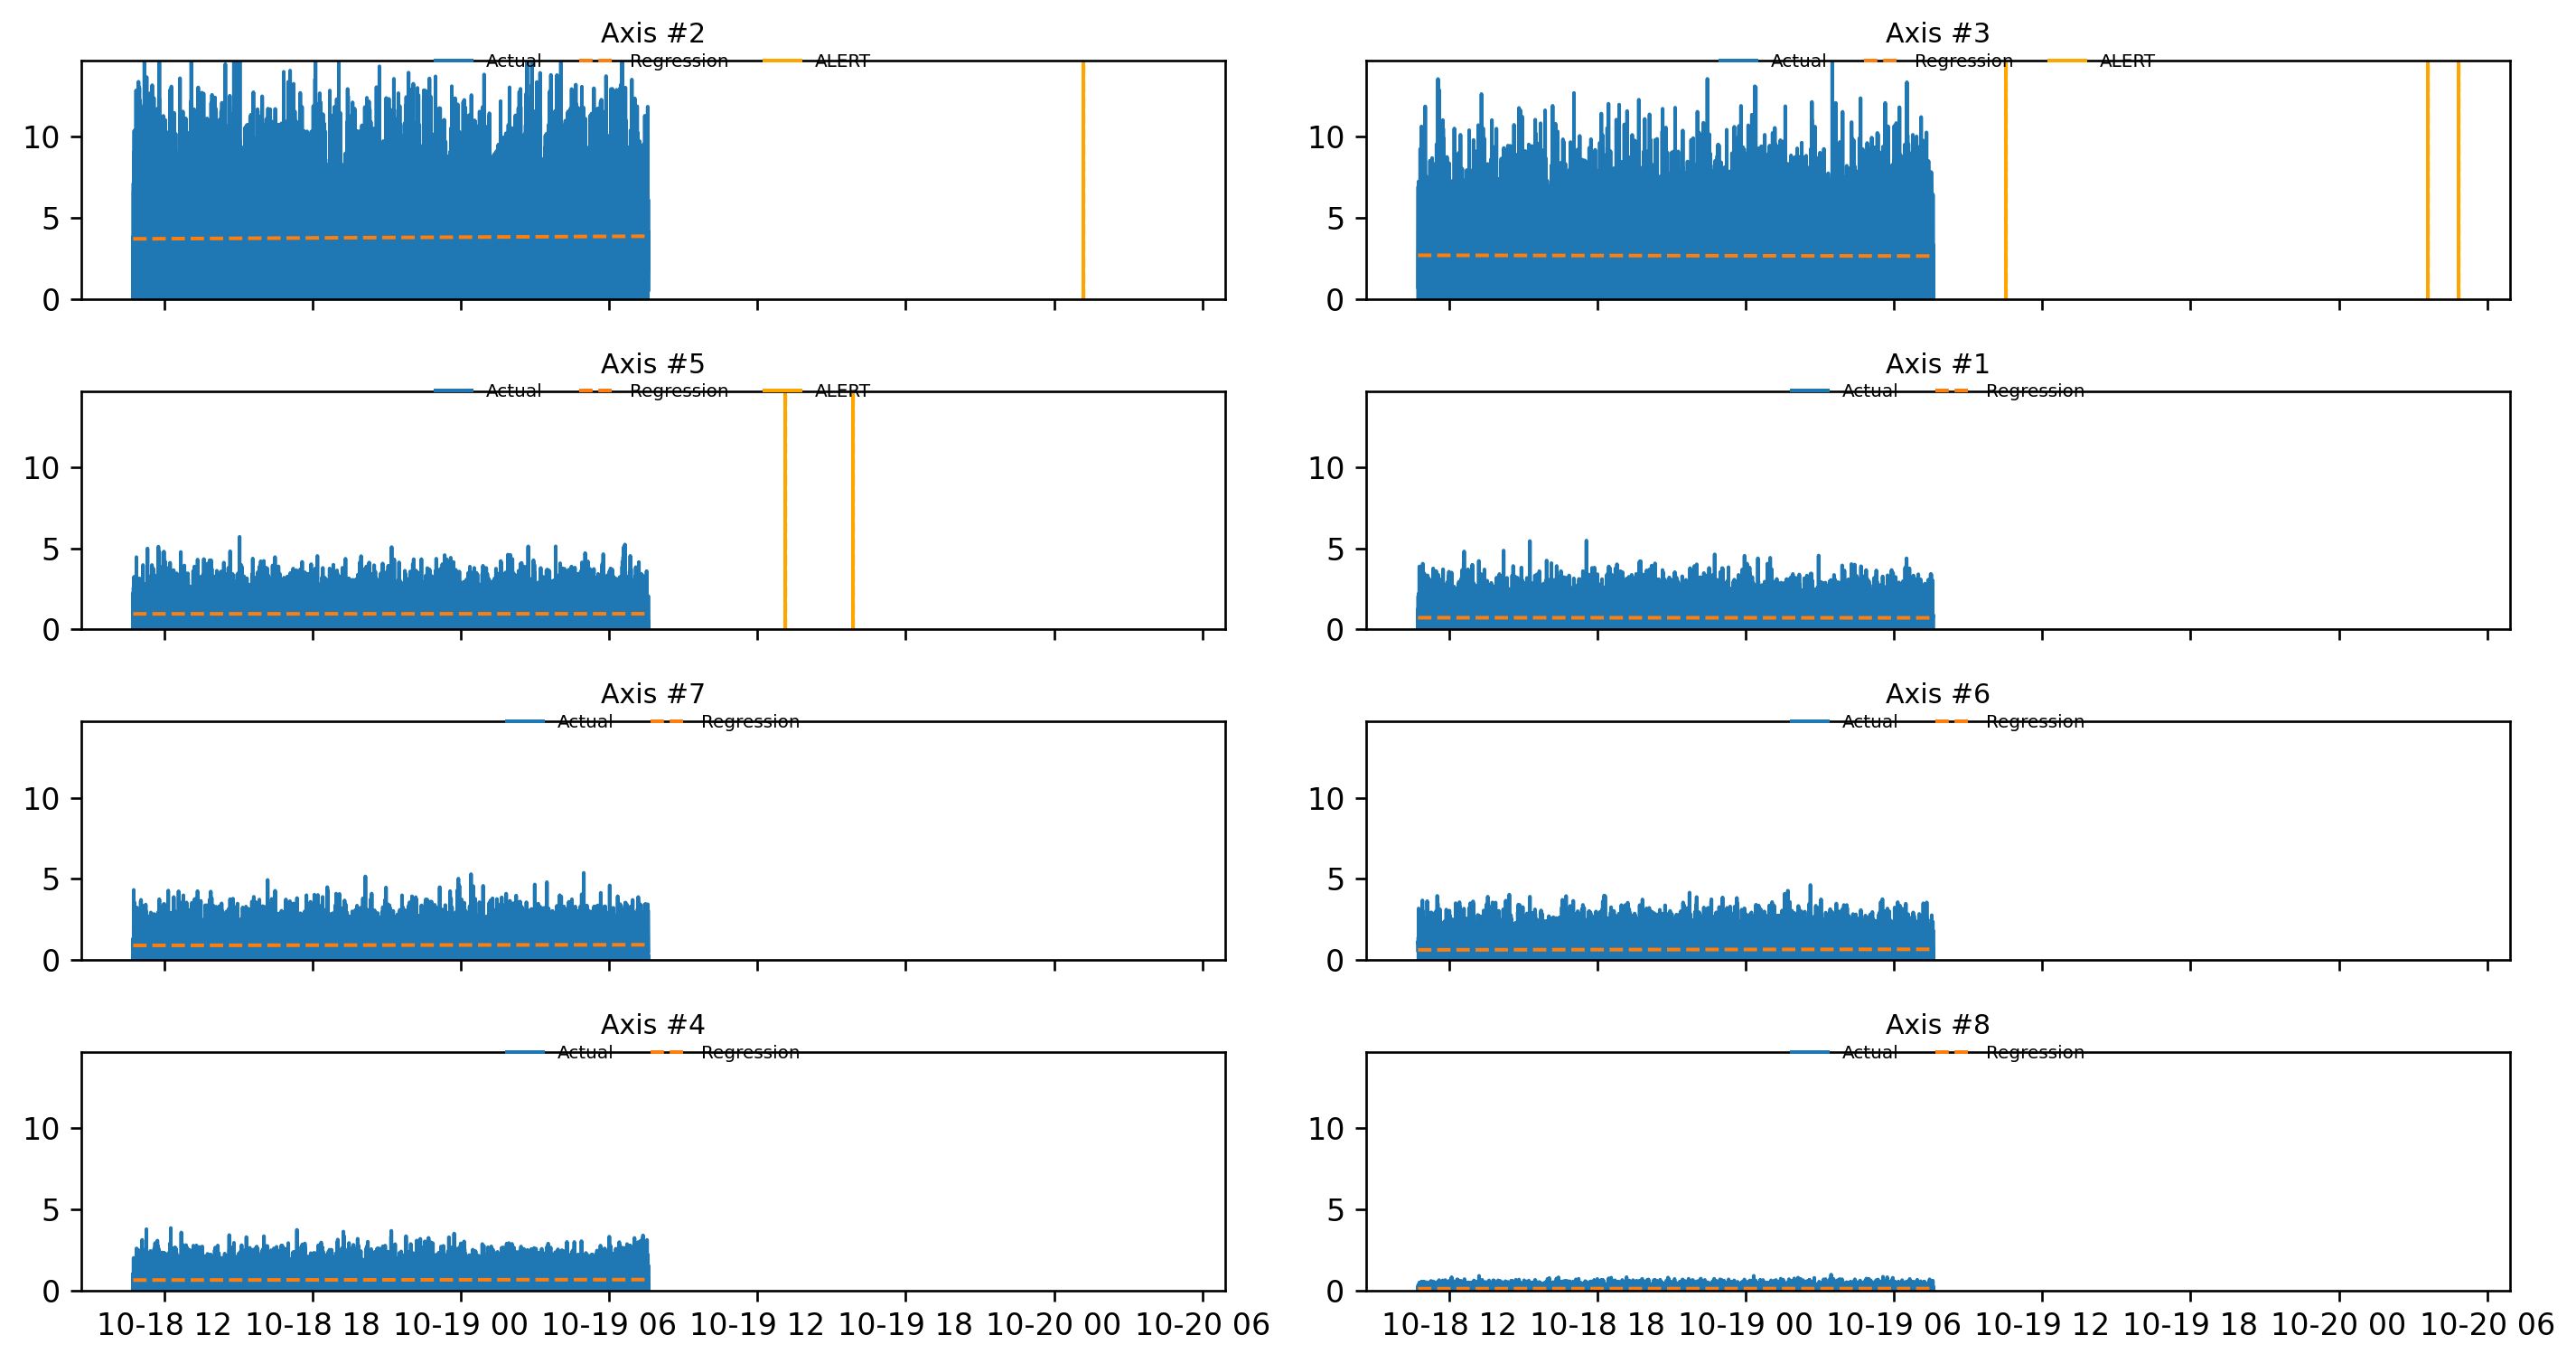

In [484]:
# Cell 18.0 — Summary (decluttered: top-k axes, smoothing, decimation, merged event lines)
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pandas.api.types import is_datetime64_any_dtype

# -------- Knobs to reduce clutter ----------
SHOW_TOPK            = 8     # show all 8 axes
SMOOTH_WIN           = 5     # rolling-median window (points); 0/1 to disable
DECIMATE             = 3     # show every Nth sample; 1 to disable
MERGE_EVENT_GAP_SEC  = 6.0   # merge events closer than this gap (sec); 0 to disable
ROBUST_YLIM          = True  # share y-limits using 1–99th percentile across shown axes
# -------------------------------------------

# 1) Find events table from any earlier cell
events_src = None
for cand in ["events_df", "events", "events_live_df"]:
    if cand in globals() and isinstance(globals()[cand], pd.DataFrame) and not globals()[cand].empty:
        events_src = globals()[cand]; break
if events_src is None:
    events_src = pd.DataFrame()

# 2) Normalize schema: label,start_time,end_time  (robust to string/number/datetime "Time")
def _normalize_events(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty:
        return pd.DataFrame(columns=["axis", "label", "start_time", "end_time"])
    out = df.copy()
    if "label" not in out.columns and "level" in out.columns:
        out = out.rename(columns={"level": "label"})
    for c in ["start_time_sec", "end_time_sec"]:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")

    time_mode, t0_dt, base_num = None, None, 0.0
    if "Time" in globals().get("test", pd.DataFrame()).columns:
        tcol = test["Time"]
        if is_datetime64_any_dtype(tcol):
            time_mode, t0_dt = "datetime", pd.to_datetime(tcol.iloc[0], errors="coerce")
        else:
            t0_try = pd.to_datetime(tcol, errors="coerce")
            if t0_try.notna().any():
                time_mode, t0_dt = "datetime", t0_try.iloc[0]
            else:
                time_mode = "numeric"
                base_num = pd.to_numeric(tcol.iloc[0], errors="coerce")
                base_num = 0.0 if pd.isna(base_num) else float(base_num)
    else:
        time_mode, base_num = "numeric", 0.0

    if "start_time" not in out.columns and "start_time_sec" in out.columns:
        out["start_time"] = (pd.to_timedelta(out["start_time_sec"], unit="s") + t0_dt
                             if time_mode == "datetime" and pd.notna(t0_dt)
                             else out["start_time_sec"] + base_num)
    if "end_time" not in out.columns and "end_time_sec" in out.columns:
        out["end_time"] = (pd.to_timedelta(out["end_time_sec"], unit="s") + t0_dt
                           if time_mode == "datetime" and pd.notna(t0_dt)
                           else out["end_time_sec"] + base_num)
    return out

events_src = _normalize_events(events_src)
has_events = isinstance(events_src, pd.DataFrame) and not events_src.empty

# 3) Proportions table
labels = ["WARNING","ALERT","ERROR"]
props = (events_src["label"].value_counts(normalize=True)
         .reindex(labels).fillna(0.0) if has_events else pd.Series(0.0, index=labels))
props = props.rename("proportion")

pdf_path = (root / "reports" / "PracticalLab1_Summary.pdf") if "root" in globals() else None

# ---- Helpers ---------------------------------------------------------------
def _merge_events(sub: pd.DataFrame, gap_sec: float) -> pd.DataFrame:
    if sub.empty or not gap_sec or gap_sec <= 0:
        return sub
    sub = sub.sort_values("start_time").reset_index(drop=True).copy()
    merged = []; cur = None
    for _, r in sub.iterrows():
        if cur is None: cur = r.copy(); continue
        same_lbl = r["label"] == cur["label"]
        gap = (r["start_time"] - cur["end_time"])
        gap = gap.total_seconds() if not np.isscalar(gap) and hasattr(gap, "total_seconds") else float(gap)
        if same_lbl and gap <= gap_sec:
            if r["end_time"] > cur["end_time"]: cur["end_time"] = r["end_time"]
        else:
            merged.append(cur); cur = r.copy()
    if cur is not None: merged.append(cur)
    return pd.DataFrame(merged)

def _prep_series(y: pd.Series) -> np.ndarray:
    s = pd.to_numeric(y, errors="coerce")
    if SMOOTH_WIN and SMOOTH_WIN > 1:
        s = s.rolling(SMOOTH_WIN, center=True, min_periods=1).median()
    arr = s.to_numpy()
    if DECIMATE and DECIMATE > 1:
        arr = arr[::DECIMATE]
    return np.asarray(arr, dtype=float)

def _prep_time(t: pd.Series) -> np.ndarray:
    x = t.to_numpy()
    if DECIMATE and DECIMATE > 1:
        x = x[::DECIMATE]
    return x

def _add_event_lines(axp, sub: pd.DataFrame):
    if sub is None or sub.empty: return
    sub = _merge_events(sub, MERGE_EVENT_GAP_SEC)
    added = {"ALERT": False, "ERROR": False, "WARNING": False}
    for _, r in sub.iterrows():
        col = {"ALERT":"orange","ERROR":"red","WARNING":"black"}.get(r.get("label"), "black")
        lab = r["label"] if not added.get(r["label"], False) else ""
        axp.axvline(r["start_time"], color=col, linestyle="-",  lw=1.2, label=lab)
        axp.axvline(r["end_time"],   color=col, linestyle="--", lw=1.0)
        added[r["label"]] = True
# ---------------------------------------------------------------------------

# --- Choose axes (top-k by variability to reduce clutter) ---
AXES_ALL = [c for c in test.columns if str(c).lower().startswith("axis")]
stds = {ax: pd.to_numeric(test[ax], errors="coerce").std(ddof=1) for ax in AXES_ALL}
axes_sorted = sorted(AXES_ALL, key=lambda a: (stds[a] if pd.notna(stds[a]) else -np.inf), reverse=True)
axes = axes_sorted[:min(SHOW_TOPK, len(axes_sorted))]

# --- Compute robust y-limits across shown axes (optional) ---
shared_ylim = None
if ROBUST_YLIM and axes:
    vals = np.concatenate([pd.to_numeric(test[a], errors="coerce").dropna().to_numpy() for a in axes])
    if vals.size:
        lo, hi = np.percentile(vals, [1, 99])
        pad = 0.05 * (hi - lo if hi > lo else max(1.0, hi))
        shared_ylim = (max(0.0, lo - pad), hi + pad)

# --- PDF export (compact pages) ---
if "SAVE_REPORTS" in globals() and SAVE_REPORTS and pdf_path is not None:
    pdf_path.parent.mkdir(parents=True, exist_ok=True)
    with PdfPages(pdf_path) as pdf:
        # Page 1: text + proportions
        fig, ax = plt.subplots(figsize=(10.5, 7)); ax.axis("off")
        cadence = float(np.median(np.diff(test["t_sec"].values))) if len(test) > 1 else 0.0
        text = (
            "Practical Lab 1 — Predictive Maintenance\n"
            f"Train rows: {len(train)}   Test rows: {len(test)}   Axes (shown/total): {len(axes)}/{len(AXES_ALL)}\n"
            f"Median cadence (Δt): {cadence:.3f}s\n"
            f"Events total: {len(events_src) if has_events else 0}\n"
            f"Smoothing (win): {SMOOTH_WIN}   Decimate: {DECIMATE}   Merge gap: {MERGE_EVENT_GAP_SEC}s\n"
        )
        ax.text(0.05, 0.95, text, va="top", family="monospace")
        ax2 = fig.add_axes([0.07, 0.08, 0.4, 0.25]); ax2.bar(props.index, props.values); ax2.set_title("Label proportions")
        pdf.savefig(fig); plt.close(fig)

        # Page 2: show the first axis as an example (kept same size)
        ex = axes[0]
        fig, axp = plt.subplots(figsize=(10.5, 3.4))
        axp.plot(_prep_time(test["Time"]), _prep_series(test[ex]), color="tab:blue", lw=1.2, label="Actual")
        axp.plot(_prep_time(test["Time"]), _prep_series(pd.Series(models[ex].predict(test[["t_sec"]].to_numpy()), index=test.index)),
                 color="tab:orange", linestyle="--", lw=1.2, label="Regression")
        if shared_ylim: axp.set_ylim(shared_ylim)
        if has_events:
            sub = events_src[events_src["axis"] == ex]
            _add_event_lines(axp, sub)
        axp.legend(loc="upper center", bbox_to_anchor=(0.5, 1.18), ncol=5, fontsize=7, frameon=False, title="Legend")
        axp.set_title(f"{ex}: regression + events (decluttered)")
        plt.tight_layout(); pdf.savefig(fig); plt.close(fig)
    print("Saved PDF ->", pdf_path)

# --- Inline preview (grid, compact, decluttered) ---
else:
    print("SAVE_REPORTS=False → inline summary")
    display(props.to_frame())

    n = len(axes)
    ncols = 2 if n >= 3 else 1
    nrows = math.ceil(n / ncols)

    # smaller overall footprint
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 1.6*nrows), sharex=True)
    axs = np.atleast_1d(axs).ravel()

    for i, ax_name in enumerate(axes):
        axp = axs[i]
        yhat = models[ax_name].predict(test[["t_sec"]].to_numpy())
        axp.plot(_prep_time(test["Time"]), _prep_series(test[ax_name]),
                 color="tab:blue", lw=1.2, label="Actual")
        axp.plot(_prep_time(test["Time"]), _prep_series(pd.Series(yhat, index=test.index)),
                 color="tab:orange", linestyle="--", lw=1.2, label="Regression")
        if shared_ylim:
            axp.set_ylim(shared_ylim)

        if has_events:
            sub = events_src[events_src["axis"] == ax_name]
            _add_event_lines(axp, sub)

        axp.legend(loc="upper center", bbox_to_anchor=(0.5, 1.10),
                   ncol=5, fontsize=6, frameon=False)
        axp.set_title(ax_name, fontsize=9)

    # remove unused axes
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])

    fig.tight_layout()
    plt.show()


### Regression Diagnostics

After running Cell 15.0a:

- **Grid 1 (Simple Linear Regression fits):**  
  The plots confirm that each axis is relatively stable over time, with only minor drifts captured by the fitted line.  
  The fitted red line stays nearly flat across all axes, consistent with industrial current data under stable operation.  

- **Grid 2 (Residuals vs Predicted):**  
  - Most residuals cluster close to zero, though with some spread and occasional outliers.  
  - No strong curved or funnel-shaped patterns appear, meaning the linear model is an acceptable approximation.  
  - The residual distribution informs the threshold discovery step:
    - Alerts (`MinC`) are set at ~2σ above mean residuals.  
    - Errors (`MaxC`) are set at ~3σ above mean residuals.  
    - Persistence (`T`) ensures only sustained deviations trigger events.

✅ These diagnostics validate that linear regression is a **reasonable modeling choice** for predictive maintenance in this lab. The residual spread provides a **data-driven basis** for anomaly thresholds, ensuring alerts and errors are defensible.

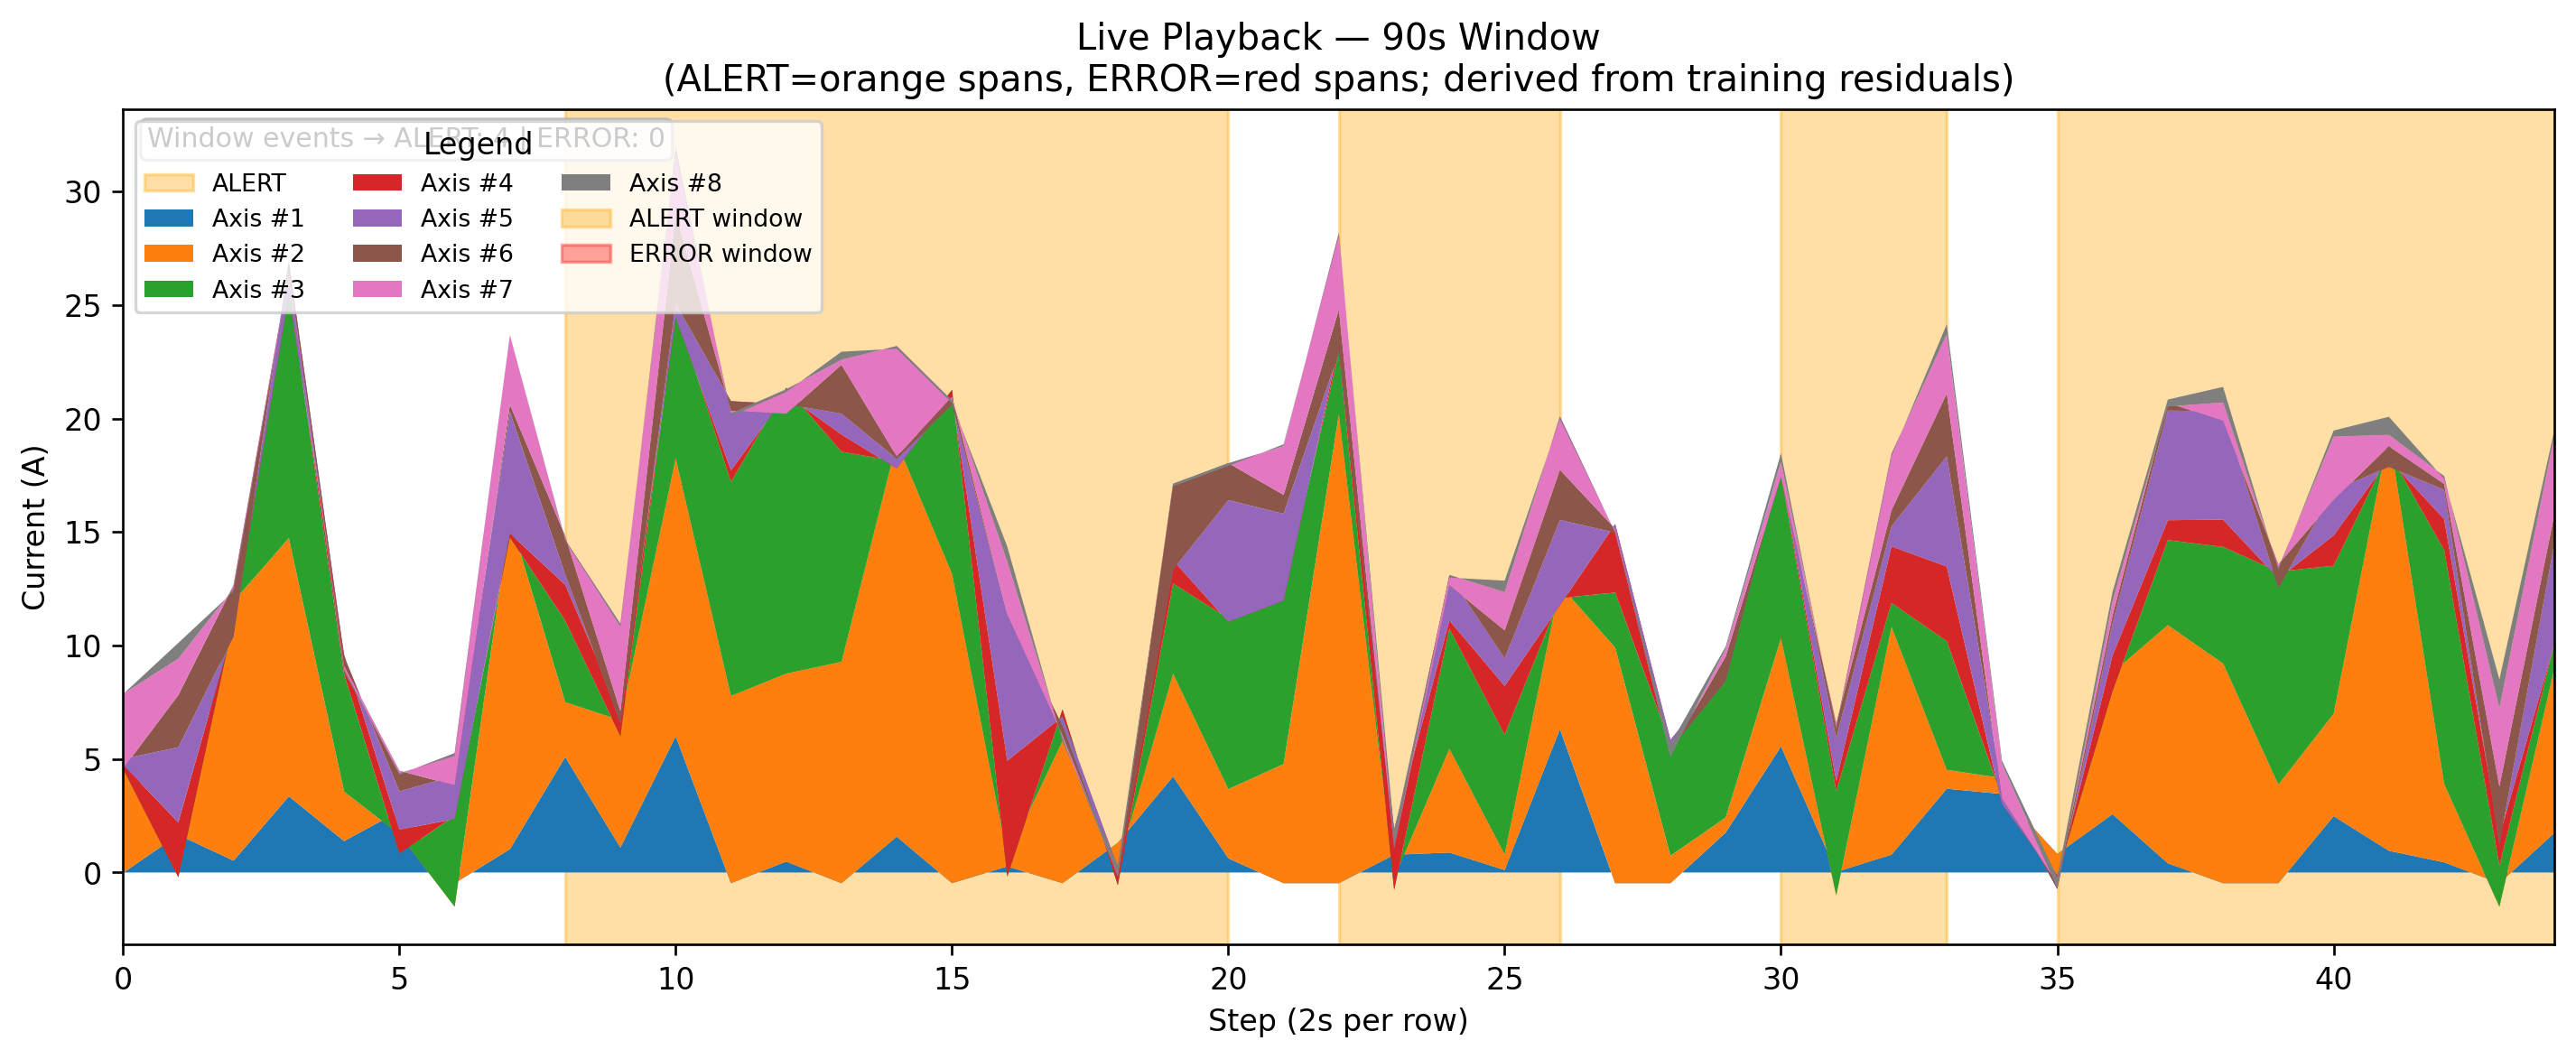

⏹ Playback interrupted by user.


In [485]:
# Cell 19.0 — Live playback from metadata_wilk_clean.csv with overlays (stacked + brighter + legend + status)
import time, re, numpy as np, pandas as pd
from collections import deque
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math

# --------- Load metadata (TEST) ---------
CSV_META = globals().get("CSV_META", "../data/metadata_wilk_clean.csv")
test = pd.read_csv(CSV_META)
print(f"Loaded metadata: {test.shape} from {CSV_META}")

# time vector for TEST (synthesize if needed)
t_test = _get_time_vector(test)

# axis columns in TEST should match first 8
AXES_TEST = _axis_columns(test, 8)

# ---- Streaming knobs ----
TICK_SECONDS = int(globals().get("TICK_SECONDS", 2))
WINDOW_ROWS  = int(globals().get("WINDOW_ROWS", 45))  # ~90s window
STACKED      = True  # stacked area look

# dwell as count threshold in the moving window
def _n_T(col):
    th = thr.get(col, {"T": 4.0})
    return max(1, int(math.ceil(th["T"] / max(1e-6, TICK_SECONDS))))

buffer_idx = deque(maxlen=WINDOW_ROWS)  # store row indices only

i = 0
try:
    while i < len(test):
        buffer_idx.append(i)

        # Build current window
        win_idx = list(buffer_idx)
        win = test.iloc[win_idx].copy()
        x = np.arange(len(win), dtype=int)  # window-local x

        # Prepare plot
        clear_output(wait=True)
        plt.figure(figsize=(12, 5))
        ax = plt.gca()

        # ---- Plot series and compute overlays
        # We'll also count per-window events for the status bar
        window_alerts = 0
        window_errors = 0

        for col in AXES_TEST:
            y = pd.to_numeric(win[col], errors="coerce").fillna(0.0).to_numpy(dtype=float)
            t0 = t_test[win_idx[0]]
            t_win = t_test[win_idx] - t0

            # z-score residuals vs TRAIN fit
            z = zscore_residuals(col, t_win, y)

            # Optional non-stacked line view (kept for completeness)
            if not STACKED:
                ax.plot(x, y, label=col, linewidth=1.2)

            # Determine spans for ALERT (MinC) and ERROR (MaxC)
            th_i = thr.get(col, None)
            if th_i is not None:
                minC, maxC = th_i["MinC"], th_i["MaxC"]
                nT = _n_T(col)
                alert_spans = find_spans(z >= minC, nT)
                error_spans = find_spans(z >= maxC, nT)
                window_alerts += len(alert_spans)
                window_errors += len(error_spans)
                # brighter overlays
                overlay_spans(ax, x, alert_spans, color="orange", alpha=0.35, label="ALERT")
                overlay_spans(ax, x, error_spans, color="red",    alpha=0.35, label="ERROR")

        if STACKED:
            # Stacked area visualization (like your second screenshot)
            series = [pd.to_numeric(win[c], errors="coerce").fillna(0.0).to_numpy(dtype=float) for c in AXES_TEST]
            ax.stackplot(x, *series, labels=AXES_TEST)

        ax.set_xlim(0, max(1, len(x)-1))
        ax.set_xlabel(f"Step ({TICK_SECONDS}s per row)")
        ax.set_ylabel("Current (A)")
        ax.set_title(f"Live Playback — {WINDOW_ROWS*TICK_SECONDS}s Window\n"
                     f"(ALERT=orange spans, ERROR=red spans; derived from training residuals)")

        # ---- Legend: axes + overlay patches
        handles, labels = ax.get_legend_handles_labels()
        patch_alert = mpatches.Patch(color="orange", alpha=0.35, label="ALERT window")
        patch_error = mpatches.Patch(color="red",    alpha=0.35, label="ERROR window")
        handles += [patch_alert, patch_error]
        labels  += ["ALERT window", "ERROR window"]
        ax.legend(handles=handles, labels=labels, loc="upper left", ncol=3, fontsize=8, title="Legend")

        # ---- Status bar text for this window
        ax.text(0.01, 0.98, f"Window events → ALERT: {window_alerts} | ERROR: {window_errors}",
                transform=ax.transAxes, va="top", ha="left", fontsize=9,
                bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.7", alpha=0.85))

        plt.tight_layout()
        plt.show()

        time.sleep(TICK_SECONDS)
        i += 1

    print("✅ Playback finished.")
except KeyboardInterrupt:
    print("⏹ Playback interrupted by user.")

### How to read the Live Playback chart (90-second moving window)

- **What’s plotted**
  - **Stacked area (colored layers)**: current draw for **Axis #1–#8** in the last **90s** (2s per row × 45 rows).
  - **Shaded bands**:
    - **Orange** = **ALERT** window → residual z-score `|z| ≥ MinC` for at least **T** seconds.
    - **Red** = **ERROR** window → residual z-score `|z| ≥ MaxC` for at least **T** seconds.
  - **Legend** lists each axis and the meaning of the shaded spans.

- **Where thresholds come from**
  - We fit **Time → Axis** (univariate) on the **training set**, compute **residuals**, then derive:
    - **MinC** = 95th percentile of `|z|` (moderate outlier),
    - **MaxC** = 99.7th percentile of `|z|` (strong outlier),
    - **T** = 95th percentile of consecutive outlier run lengths (converted to seconds using training cadence).

- **How to interpret**
  - **Orange band** means a sustained deviation from the regression baseline that surpasses normal variability.
  - **Red band** means a rare, strong sustained deviation — likely actionable.
  - Check **which axis** spikes inside a band to localize the issue.

- **What we log**
  - Each window that meets the rule (`≥ MinC` or `≥ MaxC` for `≥ T`) is written to `logs/events.csv` with:
    `axis, label (WARNING/ALERT/ERROR), start_time, end_time, duration_sec, count, MinC, MaxC, T`.

- **Why a moving 90s view**
  - It emulates live telemetry, focuses attention on recent deviations, and keeps the plot readable during streaming.